In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, Image
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# 处理中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 坐标轴负号的处理
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

# 问题二

#### 这一题所用数据暂时是问题一三次样条插值之前的数据，由于本题分析属性较多，全部进行插值计算量较大但并不是完全不可行

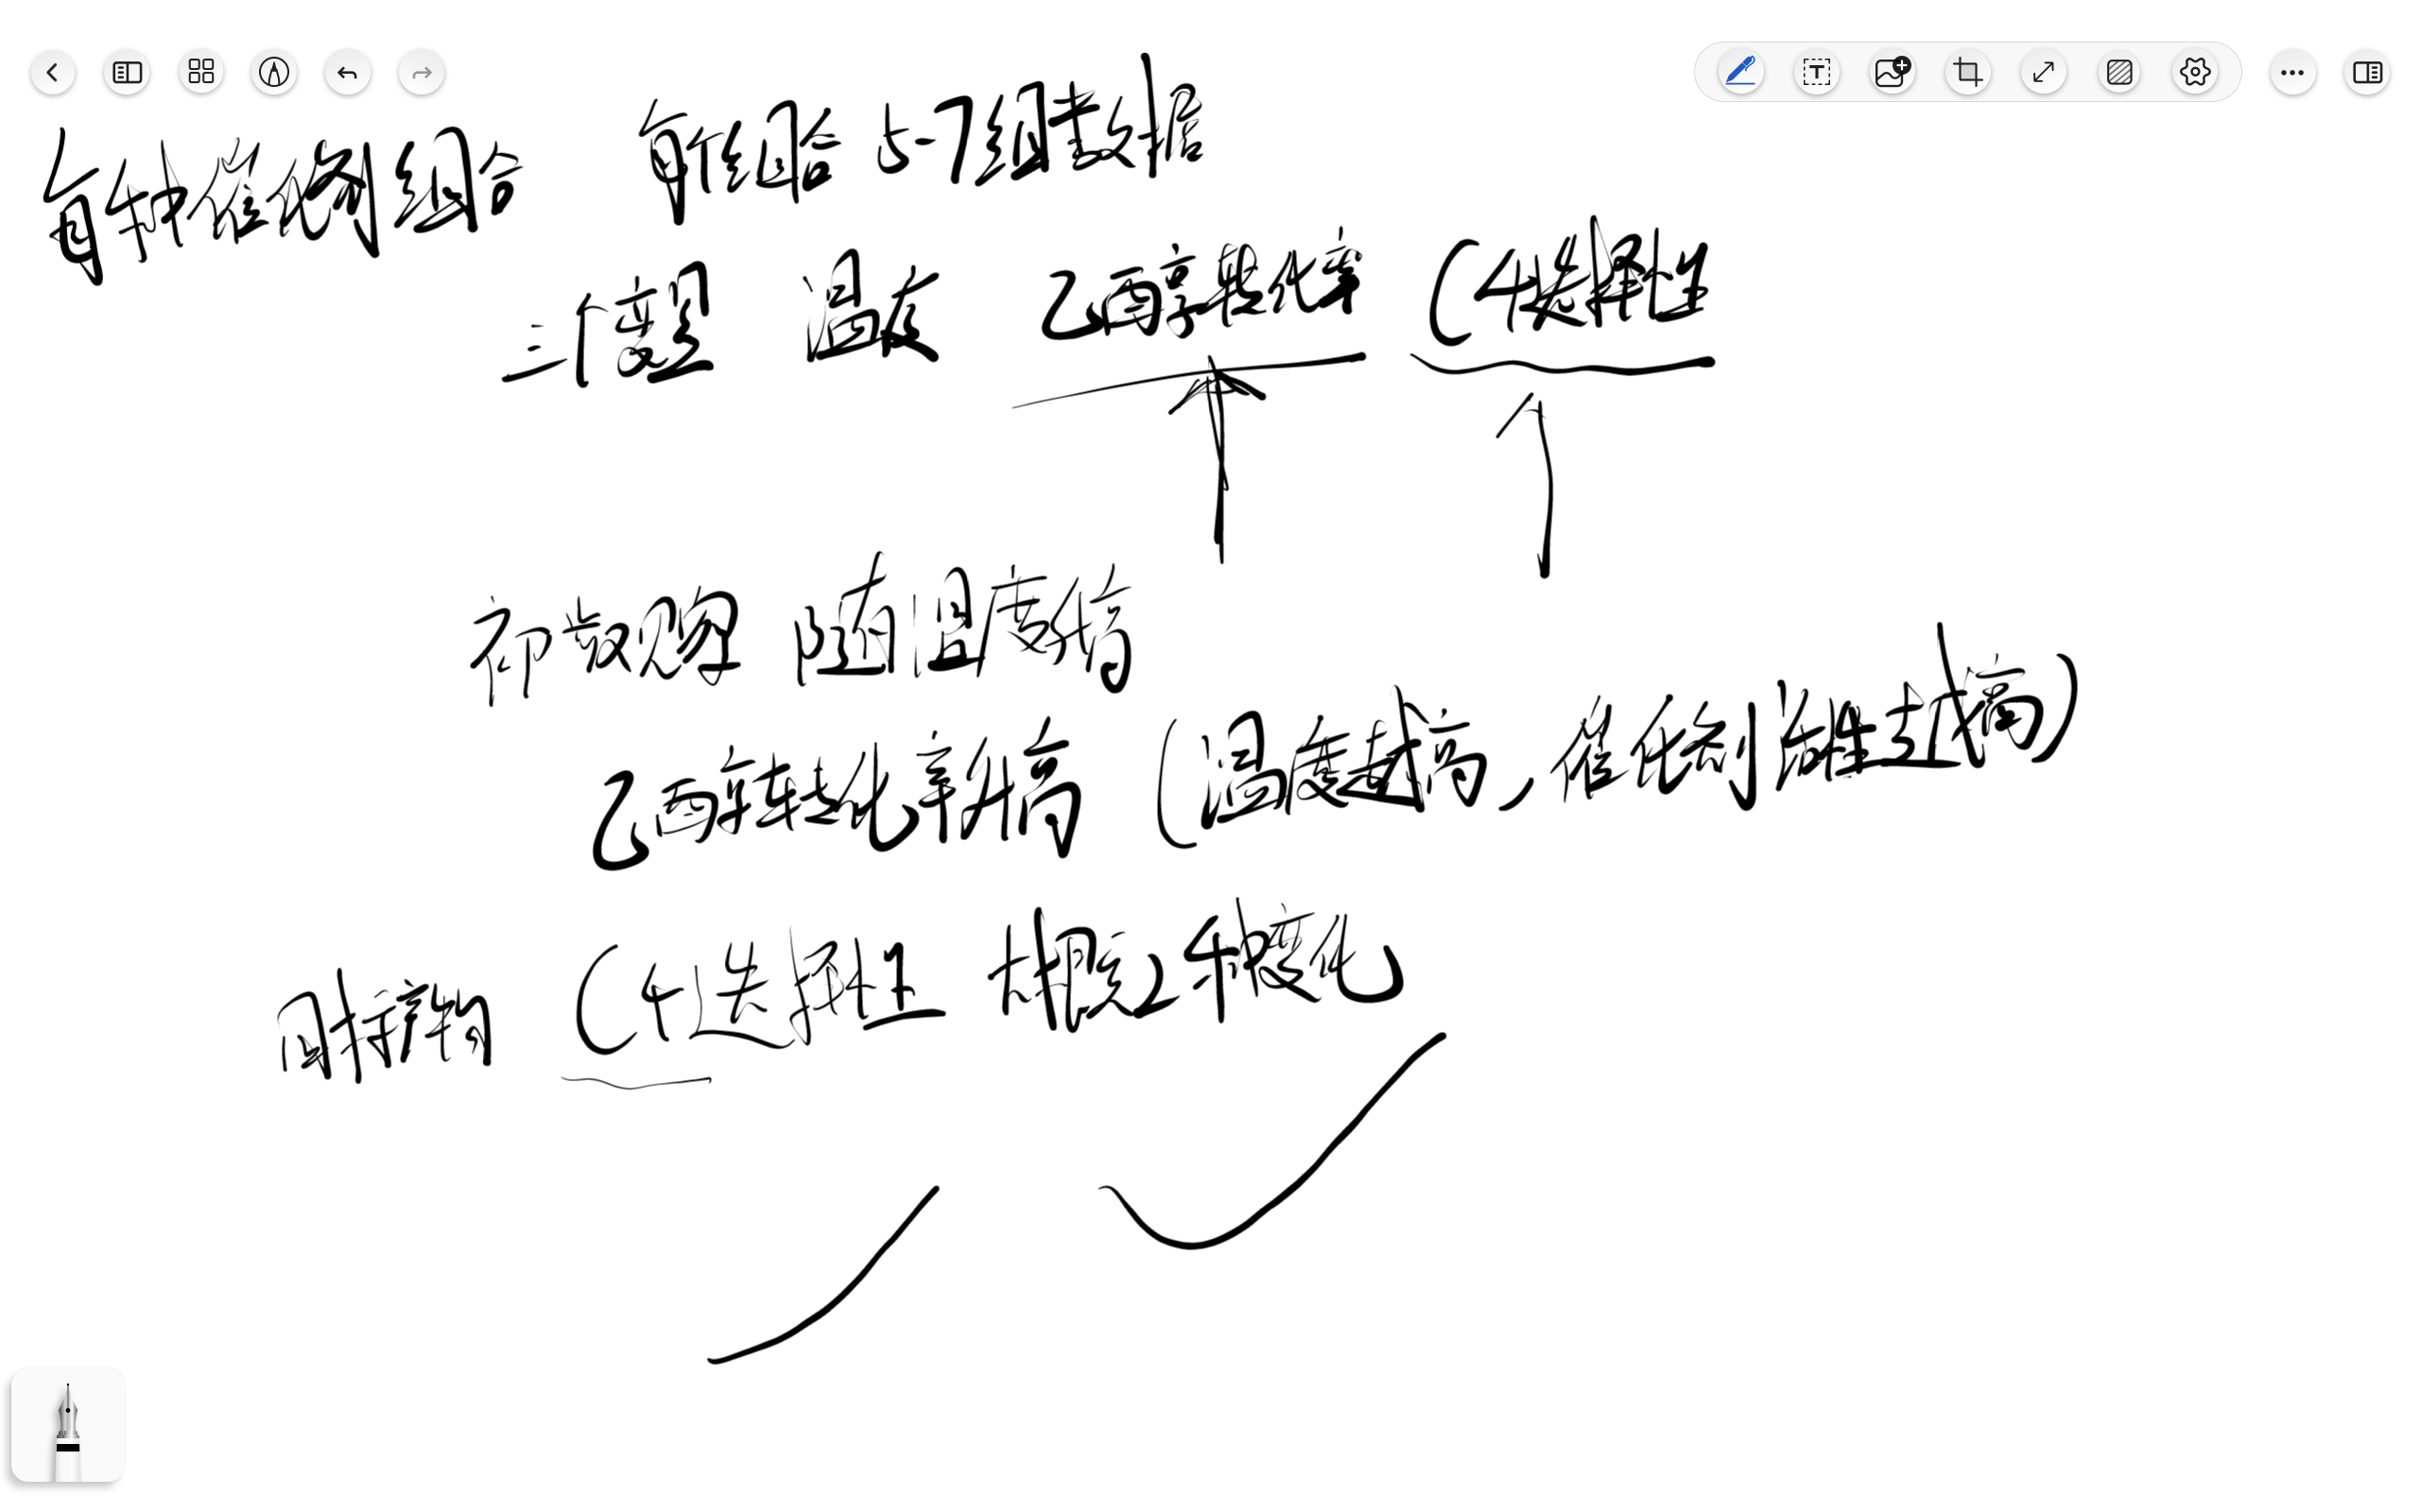

In [2]:
display(Image(filename='图/微信图片_20250723120310_279.jpg'))

## 控制变量，在每一组内分别探究温度与乙醇转化率和温度与C4选择性的关系

## 分组按照催化剂组别，事实上两种不同的装料方式中催化剂有两组重复，这两组可以作为独立的变量进行分析。

1. 装料方式不同：A9+B5，A12+B1
2. 乙醇浓度不同：A1+A3，A2+A5，A7+A8+A9+A12，B1+B5，B2+B7，
3. Co负载量不同：A1+A2+A4+A6，A9+A10，
4. 有无HAP：A11+A12
5. 总质量不变，Co与HAP质量比不同：A12+A13+A14
6. Co与HAP质量比1:1，总质量不同：B1+B2+B3+B4+B6，A1+A12

#### 后来的后来发现，由于是对不同的催化剂组合进行比较，那么乙醇浓度不同没有必要进行比较，就注释掉了

#### 再后来的后来，发现题目里标注了“催化剂组合（即：Co负载量、Co/SiO2和HAP装料比、乙醇浓度的组合）”，也就是说包括乙醇浓度，在题目里也算做不同催化剂组合进行比较，又从注释黑名单拉出来了

In [3]:
df = pd.read_excel('附件1.xlsx', sheet_name='性能数据表')

# 向下填充合并单元格
df['催化剂组合编号'] = df['催化剂组合编号'].ffill()
df['催化剂组合'] = df['催化剂组合'].ffill()

# 清理列名
df.columns = df.columns.str.strip().str.replace('\n', '').str.replace('\r', '')

# 存储清洗后的数据
data_rows = []

# 用于保存当前催化剂组合的解析结果
current_id = None
current_info = {}

for idx, row in df.iterrows():
    if pd.notna(row['催化剂组合编号']) and 'mg' in str(row['催化剂组合']):
        current_id = row['催化剂组合编号']
        combo_str = row['催化剂组合']

        # 解析信息
        co_match = re.search(r'(\d+\.?\d*)wt%Co/SiO2', combo_str)
        co_loading = float(co_match.group(1)) if co_match else np.nan

        co_sio2_match = re.search(r'(\d+)mg\s+[^\s]+Co/SiO2', combo_str)
        co_sio2_mass = float(co_sio2_match.group(1)) if co_sio2_match else np.nan

        hap_match = re.search(r'(\d+)mg\s+HAP', combo_str)
        hap_mass = float(hap_match.group(1)) if hap_match else 0
        has_hap = 1 if hap_match else 0

        ethanol_match = re.search(r'乙醇浓度\s*(\d+\.?\d*)\s*ml/min', combo_str)
        ethanol_conc = float(ethanol_match.group(1)) if ethanol_match else np.nan

        total_mass = co_sio2_mass + hap_mass
        mass_ratio = co_sio2_mass / hap_mass if hap_mass != 0 else np.nan

        current_info = {
            '编号': current_id,
            'Co负载量(wt%)': co_loading,
            'Co/SiO2质量(mg)': co_sio2_mass,
            'HAP质量(mg)': hap_mass,
            '总质量(mg)': total_mass,
            '质量比(Co/SiO2:HAP)': mass_ratio,
            '乙醇浓度(ml/min)': ethanol_conc,
            '装料方式': 'I' if str(current_id).startswith('A') else 'II',
            '有无HAP': has_hap
        }

        if pd.notna(row.get('温度')) and np.isfinite(row['温度']):  # 确保温度是有效数值
            # 合并催化剂信息 + 当前行的性能数据
            record = current_info.copy()  # 复制当前催化剂信息
            record['温度'] = row['温度']
            record['乙醇转化率(%)'] = row['乙醇转化率(%)']
            record['C4烯烃选择性(%)'] = row['C4烯烃选择性(%)']

            data_rows.append(record)

df_clean = pd.DataFrame(data_rows)

## 为了进行对照分析，定义一个绘图函数

In [4]:
def plot_comparison(df, group_ids, title, y_var, hue_col='编号'):
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'FangSong']
    plt.rcParams['axes.unicode_minus'] = False
    """
    绘制对照组的性能对比图
    """
    plt.figure(figsize=(10, 6))
    subset = df[df['编号'].isin(group_ids)]
    sns.lineplot(data=subset, x='温度', y=y_var, hue=hue_col, marker='o', linewidth=2.5)
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('温度 (°C)', fontsize=12)
    plt.ylabel(y_var, fontsize=12)
    plt.legend(title='实验编号')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 1. 装料方式不同，完全相同的催化剂组合和浓度

### A12 vs B1 

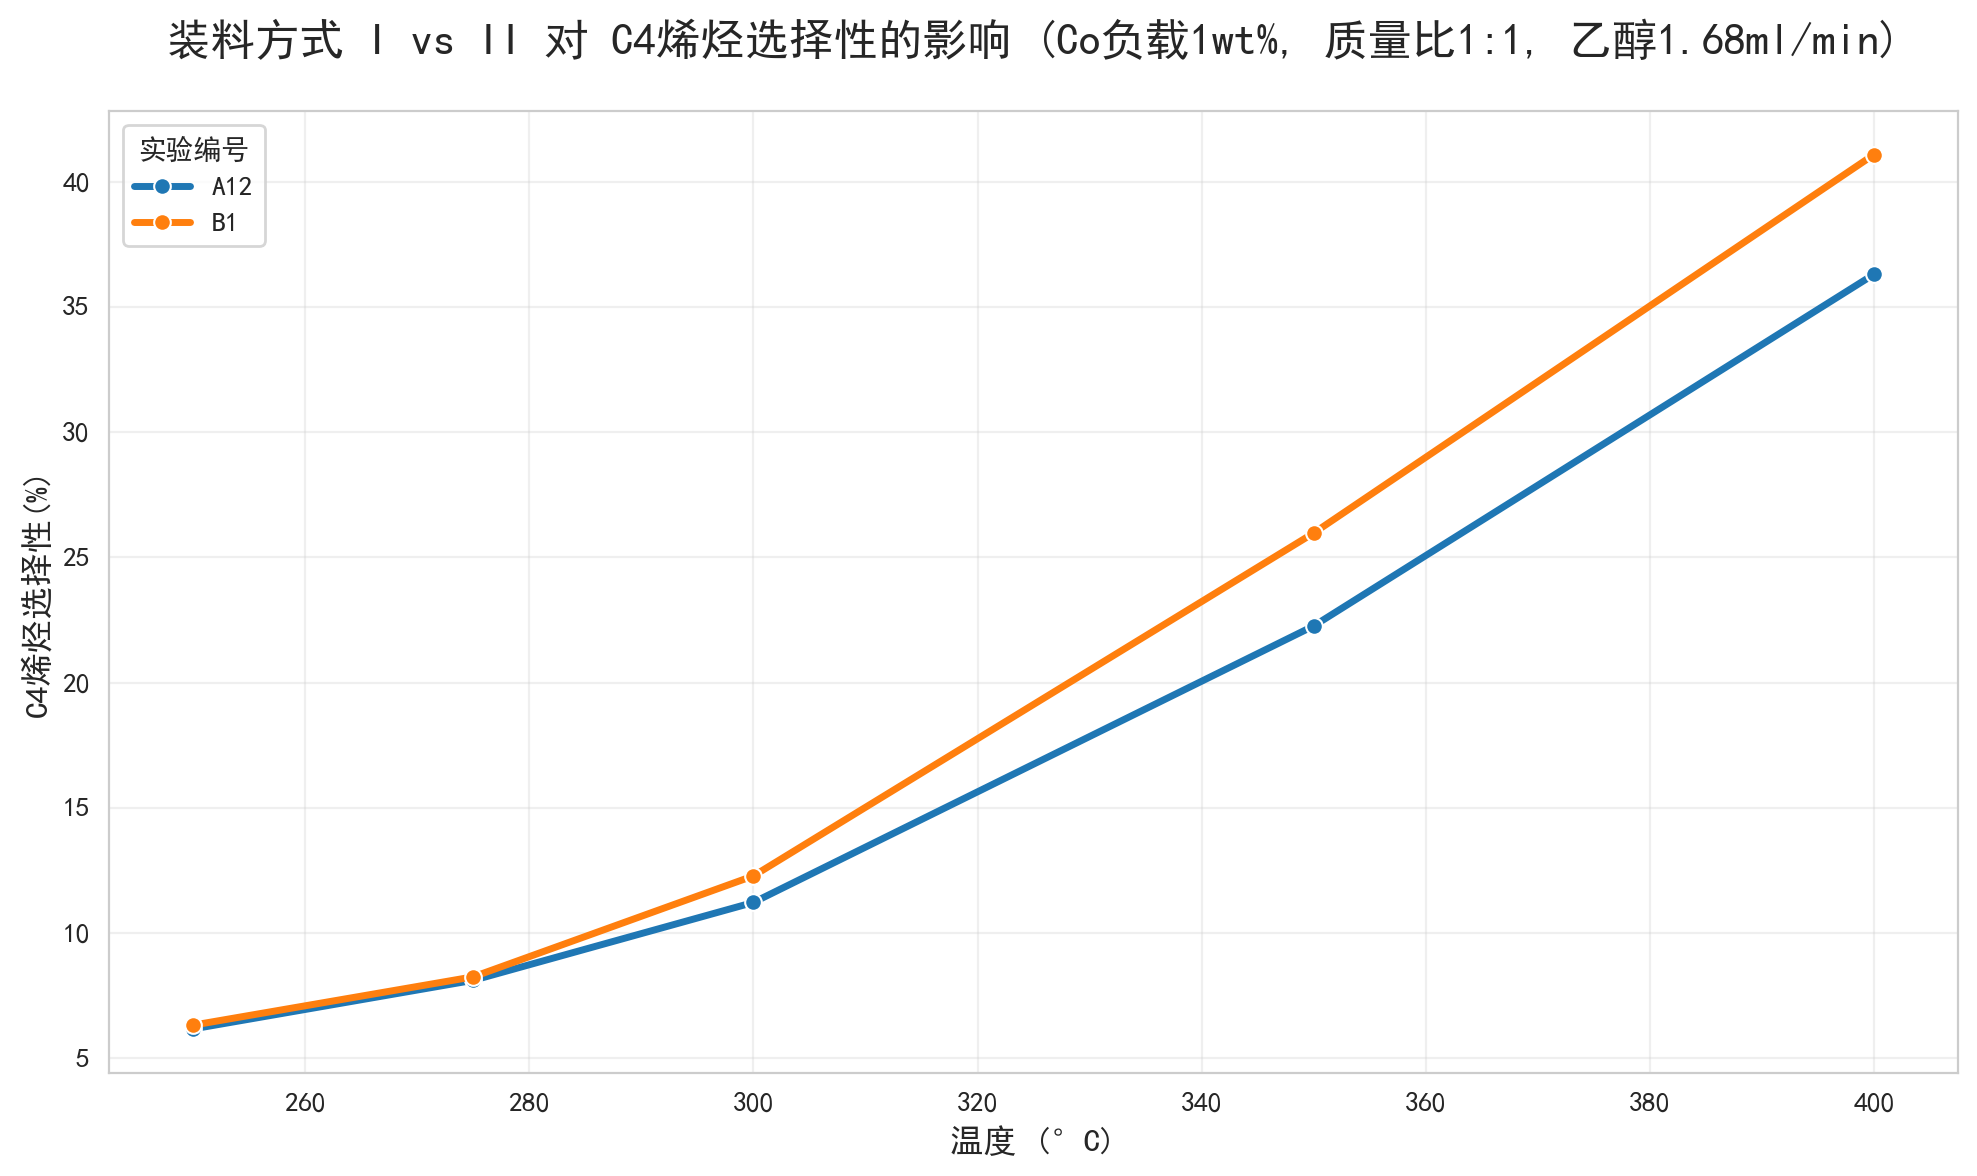

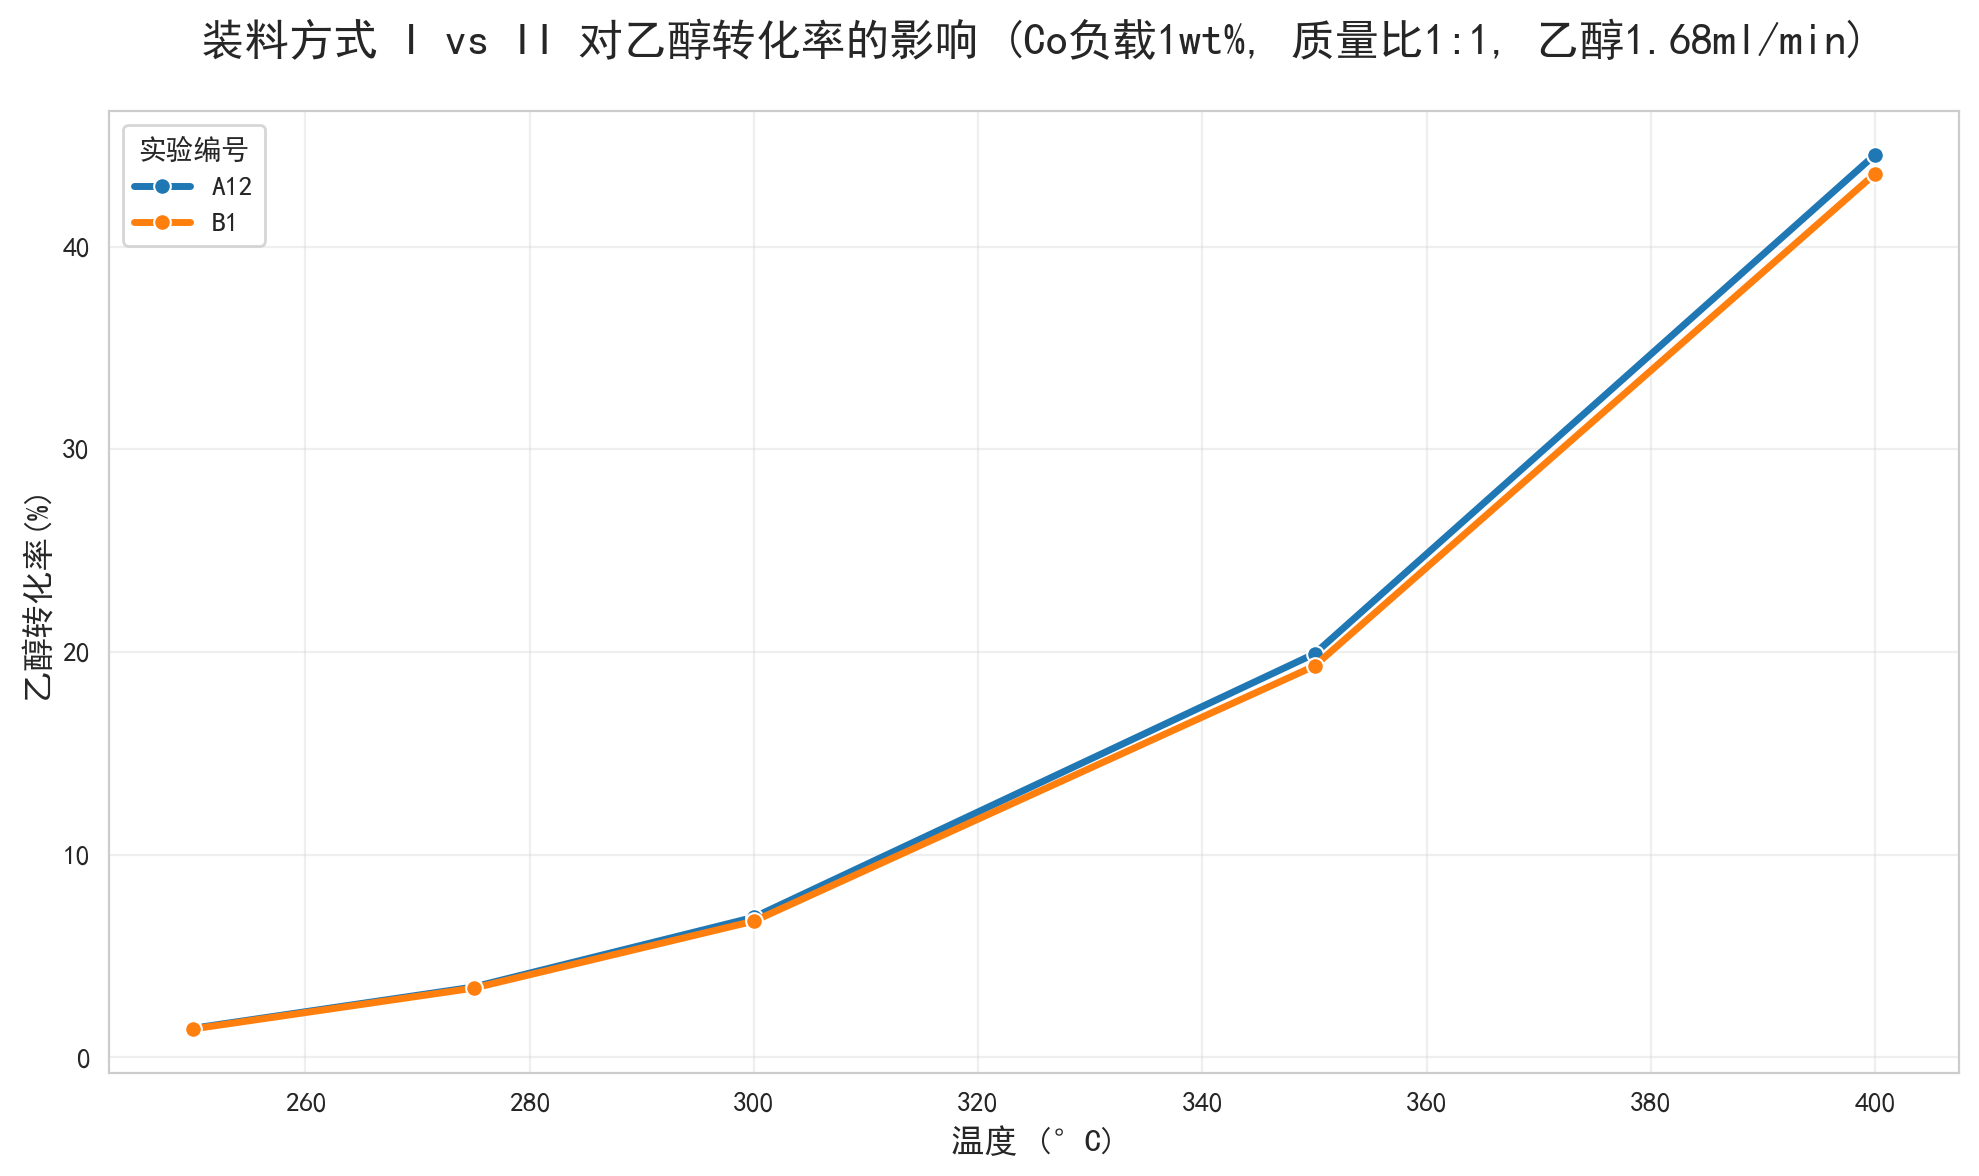

--- 装料方式对照 (A12 vs B1) 在 400°C ---
A12 (方式I): 转化率=44.5%, C4选择性=36.30%
B1 (方式II): 转化率=43.6%, C4选择性=41.08%
方式II 使 乙醇转化率 提高了 -0.94 个百分点,使 C4选择性 提高了 4.78 个百分点


In [5]:
group_1_2 = ['A12', 'B1']
plot_comparison(df_clean, group_1_2, '装料方式 I vs II 对 C4烯烃选择性的影响 (Co负载1wt%, 质量比1:1, 乙醇1.68ml/min)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_1_2, '装料方式 I vs II 对乙醇转化率的影响 (Co负载1wt%, 质量比1:1, 乙醇1.68ml/min)', '乙醇转化率(%)')

# 量化差异 (以400°C为例)
a12_350 = df_clean[(df_clean['编号']=='A12') & (df_clean['温度']==400)]
b1_350 = df_clean[(df_clean['编号']=='B1') & (df_clean['温度']==400)]
print(f"--- 装料方式对照 (A12 vs B1) 在 400°C ---")
print(f"A12 (方式I): 转化率={a12_350['乙醇转化率(%)'].values[0]:.1f}%, C4选择性={a12_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"B1 (方式II): 转化率={b1_350['乙醇转化率(%)'].values[0]:.1f}%, C4选择性={b1_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"方式II 使 乙醇转化率 提高了 {b1_350['乙醇转化率(%)'].values[0] - a12_350['乙醇转化率(%)'].values[0]:.2f} 个百分点,使 C4选择性 提高了 {b1_350['C4烯烃选择性(%)'].values[0] - a12_350['C4烯烃选择性(%)'].values[0]:.2f} 个百分点")

### A9 vs B5

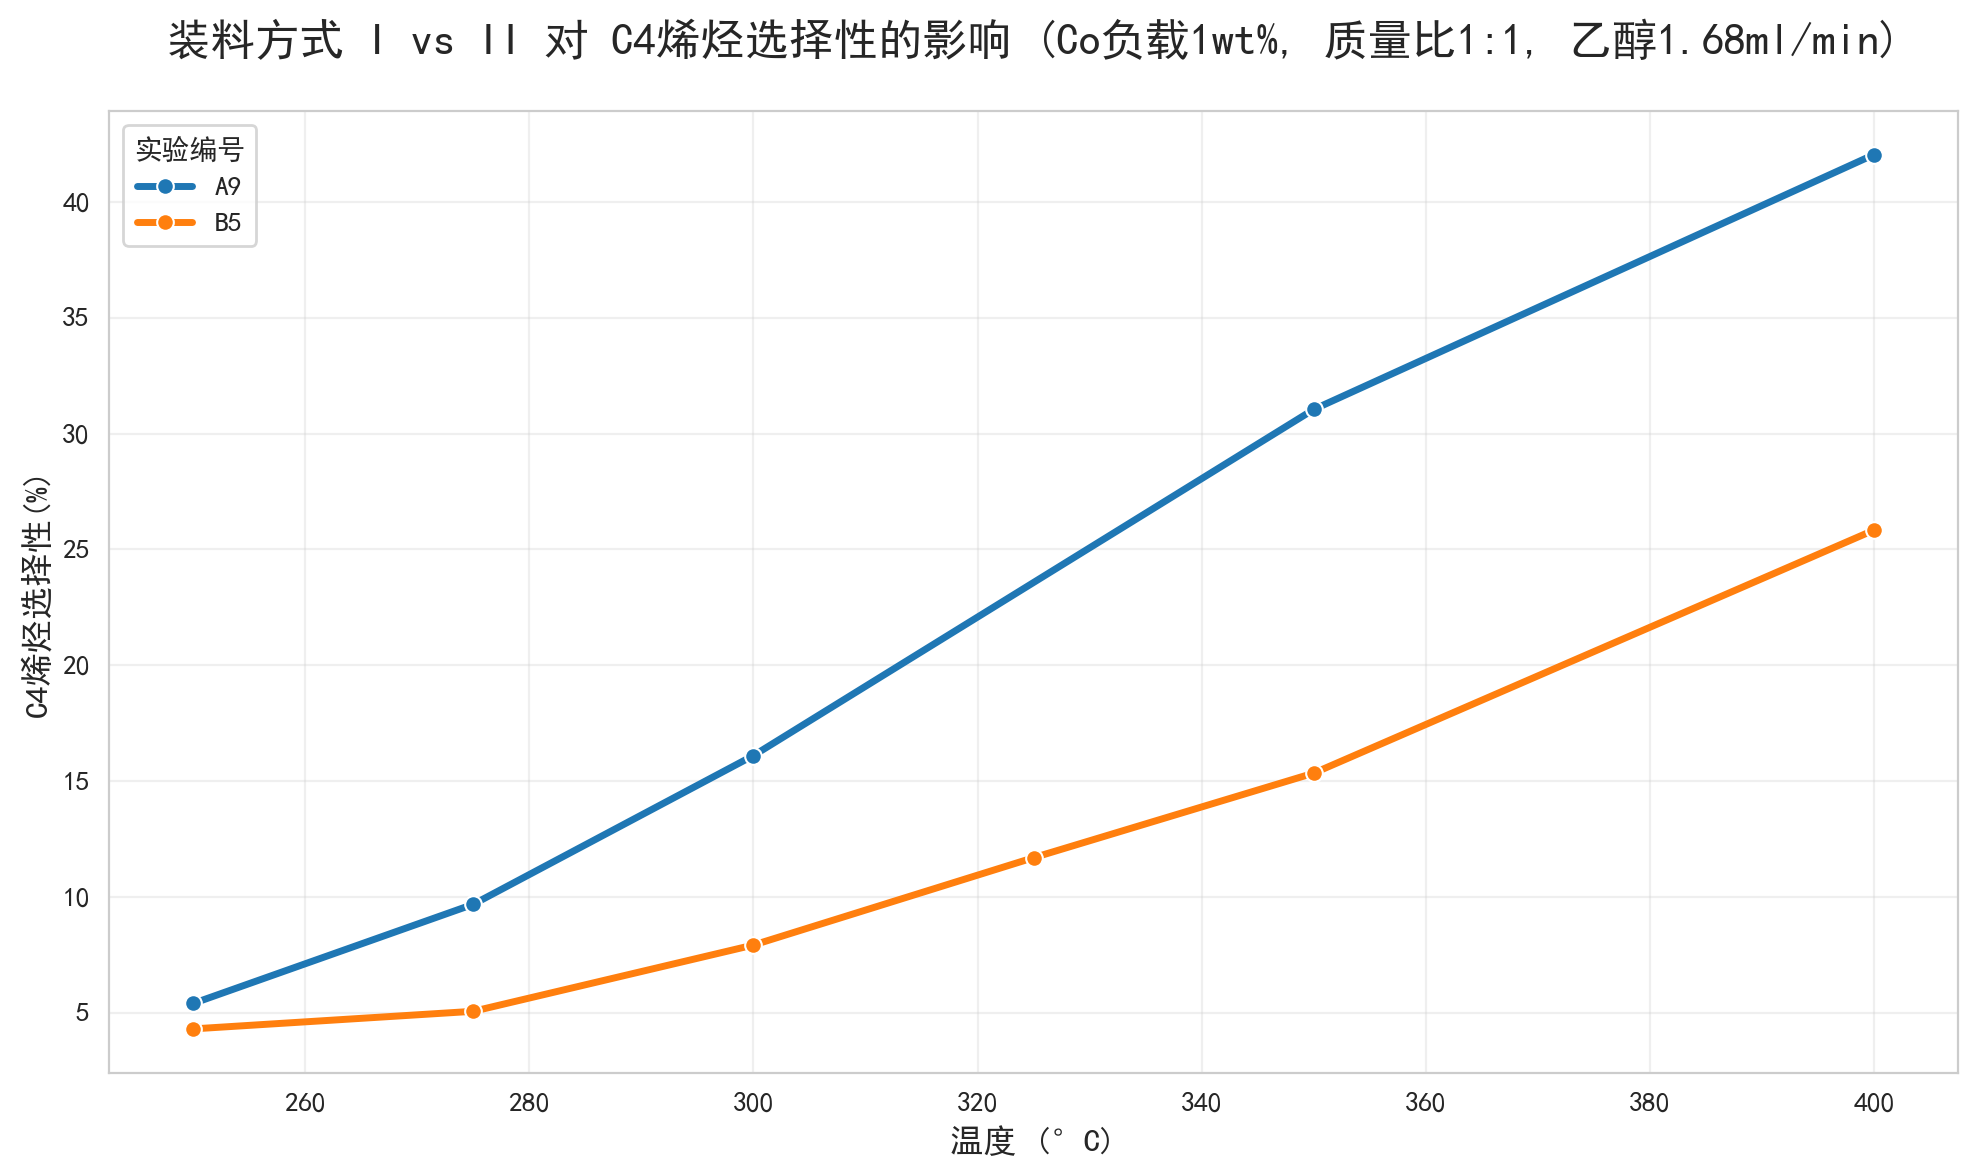

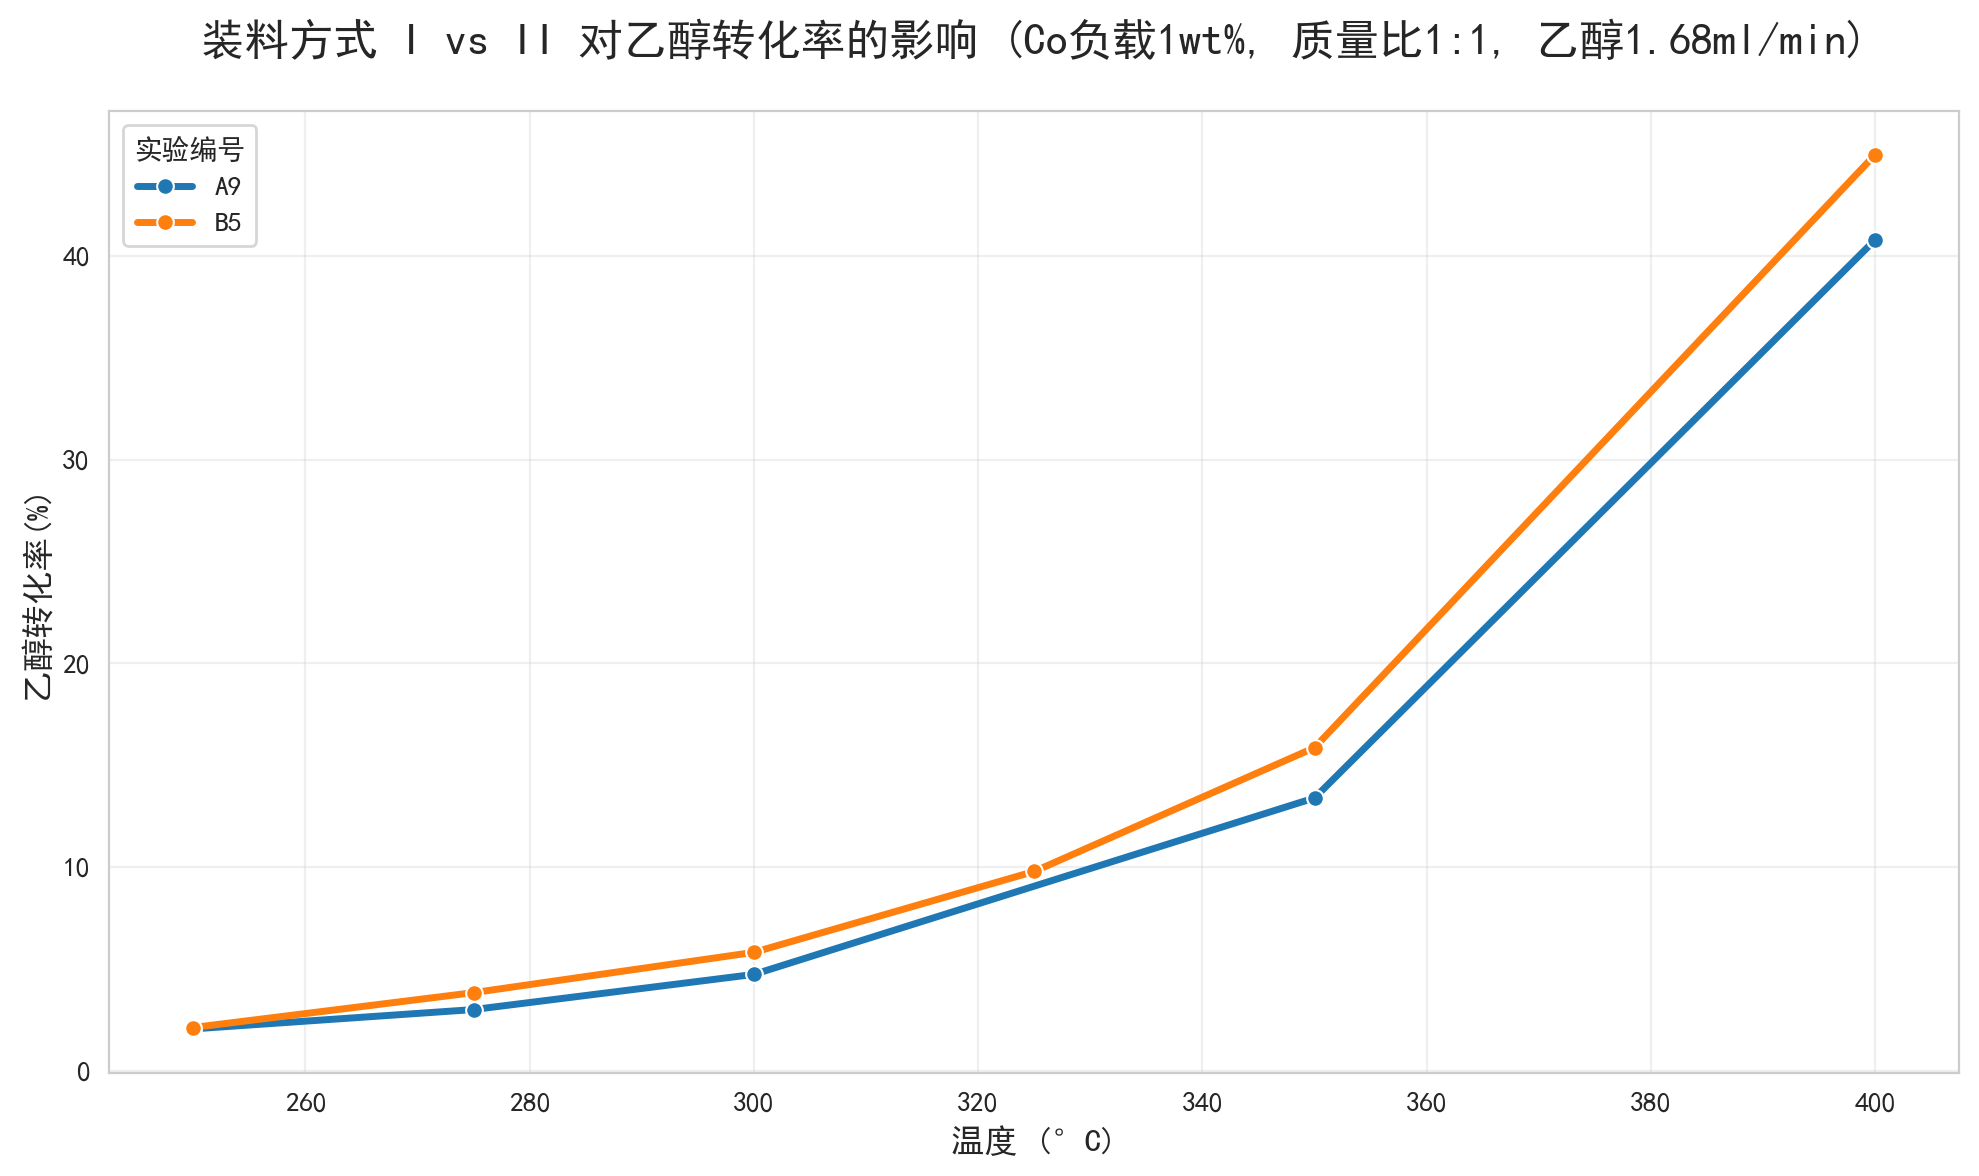

--- 装料方式对照 (A9 vs B5) 在 400°C ---
A9 (方式I): 转化率=40.8%, C4选择性=42.04%
B5 (方式II): 转化率=45.0%, C4选择性=25.83%
方式II 使 乙醇转化率 提高了 4.18 个百分点,使 C4选择性 提高了 -16.21 个百分点


In [6]:
group_1_1 = ['A9', 'B5']
plot_comparison(df_clean, group_1_1, '装料方式 I vs II 对 C4烯烃选择性的影响 (Co负载1wt%, 质量比1:1, 乙醇1.68ml/min)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_1_1, '装料方式 I vs II 对乙醇转化率的影响 (Co负载1wt%, 质量比1:1, 乙醇1.68ml/min)', '乙醇转化率(%)')

# 量化差异 (以400°C为例)
a9_350 = df_clean[(df_clean['编号']=='A9') & (df_clean['温度']==400)]
b5_350 = df_clean[(df_clean['编号']=='B5') & (df_clean['温度']==400)]
print(f"--- 装料方式对照 (A9 vs B5) 在 400°C ---")
print(f"A9 (方式I): 转化率={a9_350['乙醇转化率(%)'].values[0]:.1f}%, C4选择性={a9_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"B5 (方式II): 转化率={b5_350['乙醇转化率(%)'].values[0]:.1f}%, C4选择性={b5_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"方式II 使 乙醇转化率 提高了 {b5_350['乙醇转化率(%)'].values[0] - a9_350['乙醇转化率(%)'].values[0]:.2f} 个百分点,使 C4选择性 提高了 {b5_350['C4烯烃选择性(%)'].values[0] - a9_350['C4烯烃选择性(%)'].values[0]:.2f} 个百分点")

## 2. 乙醇浓度不同

### A1 vs A3 

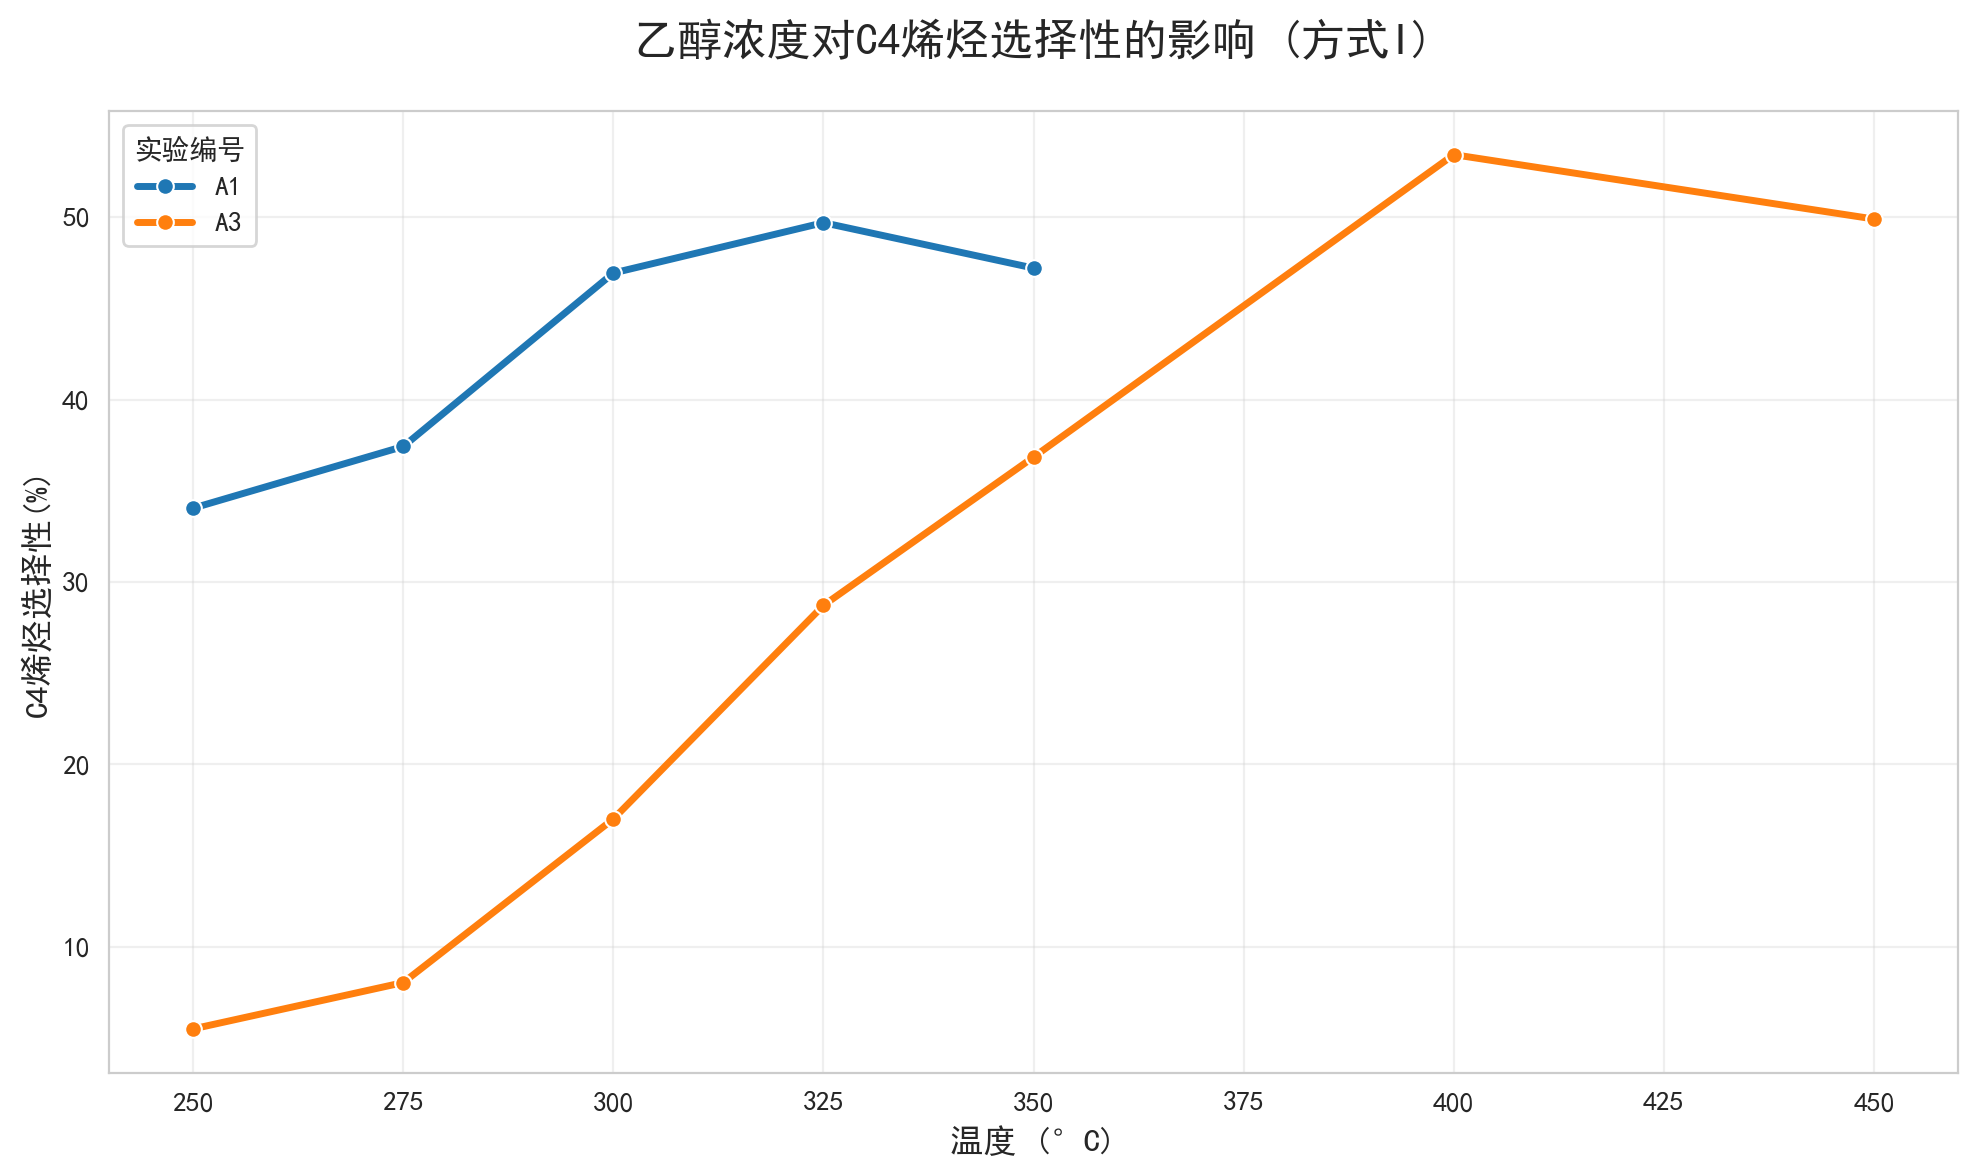

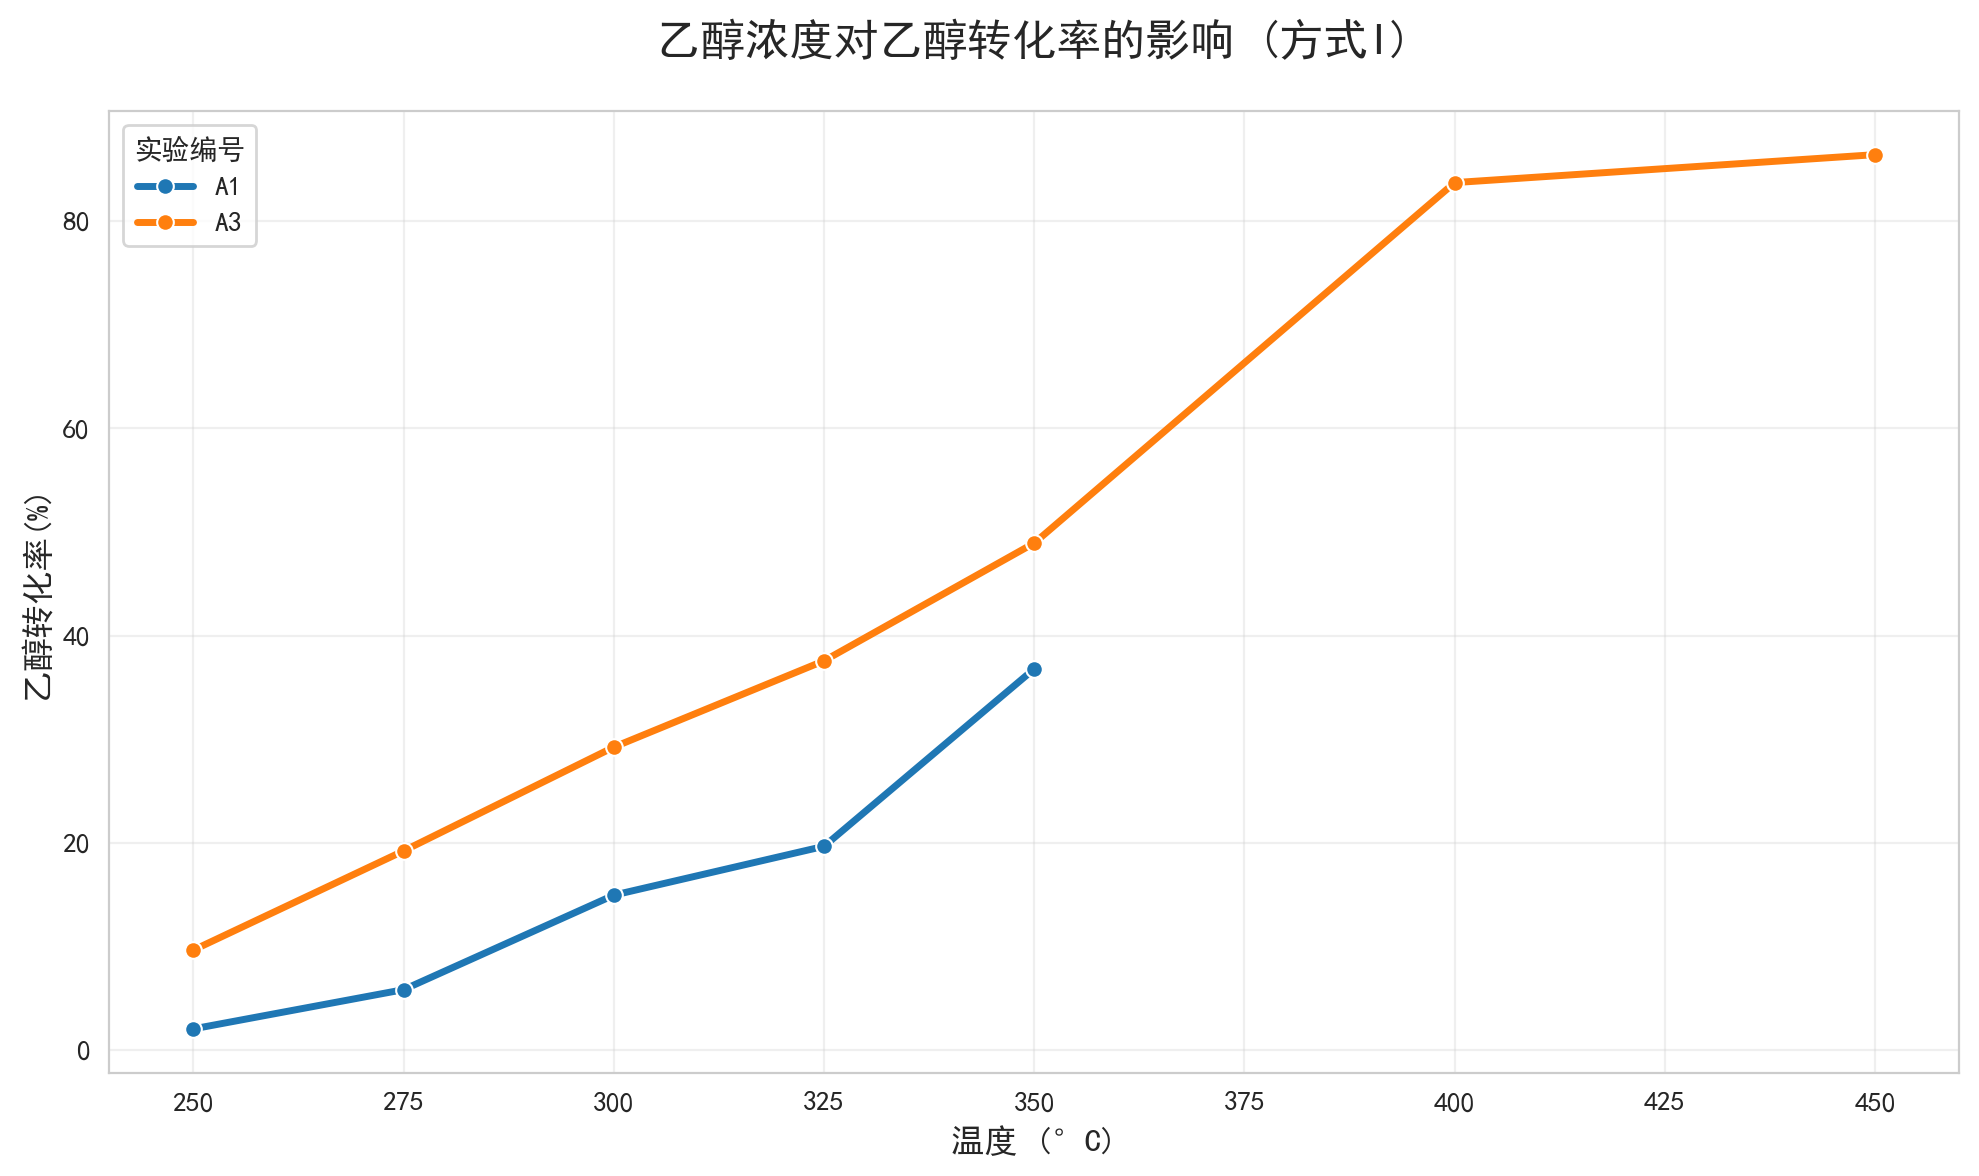

--- 乙醇浓度对照 (A1 vs A3) 在 350°C ---
A1 (1.68ml/min): 转化率=36.8%，C4选择性=47.21%
A3 (0.9ml/min): 转化率=48.9%，C4选择性=36.85%


In [7]:
group_2a = ['A1', 'A3']
plot_comparison(df_clean, group_2a, '乙醇浓度对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_2a, '乙醇浓度对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 乙醇浓度对照 (A1 vs A3) 在 350°C ---")
a1_350 = df_clean[(df_clean['编号']=='A1') & (df_clean['温度']==350)]
a3_350 = df_clean[(df_clean['编号']=='A3') & (df_clean['温度']==350)]
print(f"A1 (1.68ml/min): 转化率={a1_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a1_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A3 (0.9ml/min): 转化率={a3_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a3_350['C4烯烃选择性(%)'].values[0]:.2f}%")

### A2 vs A5

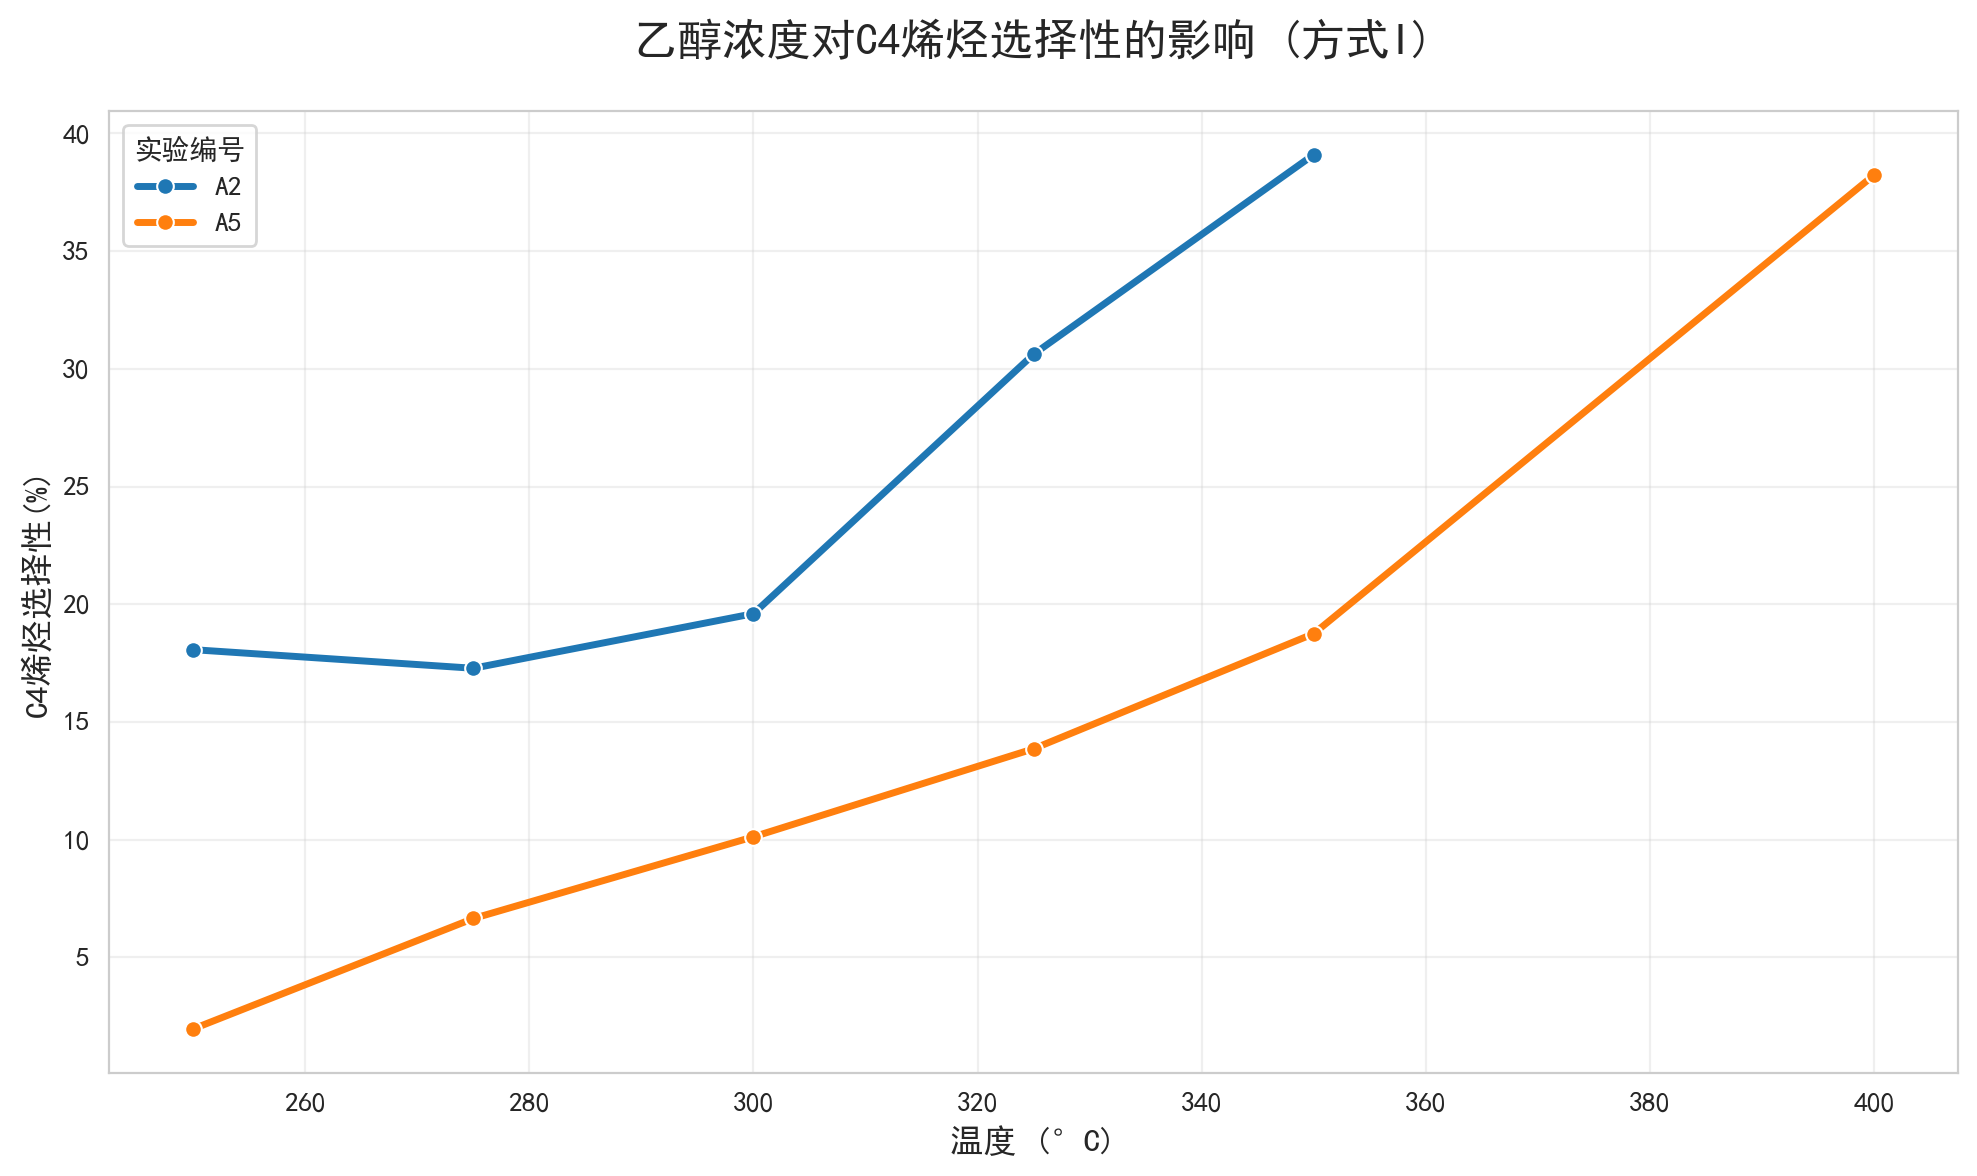

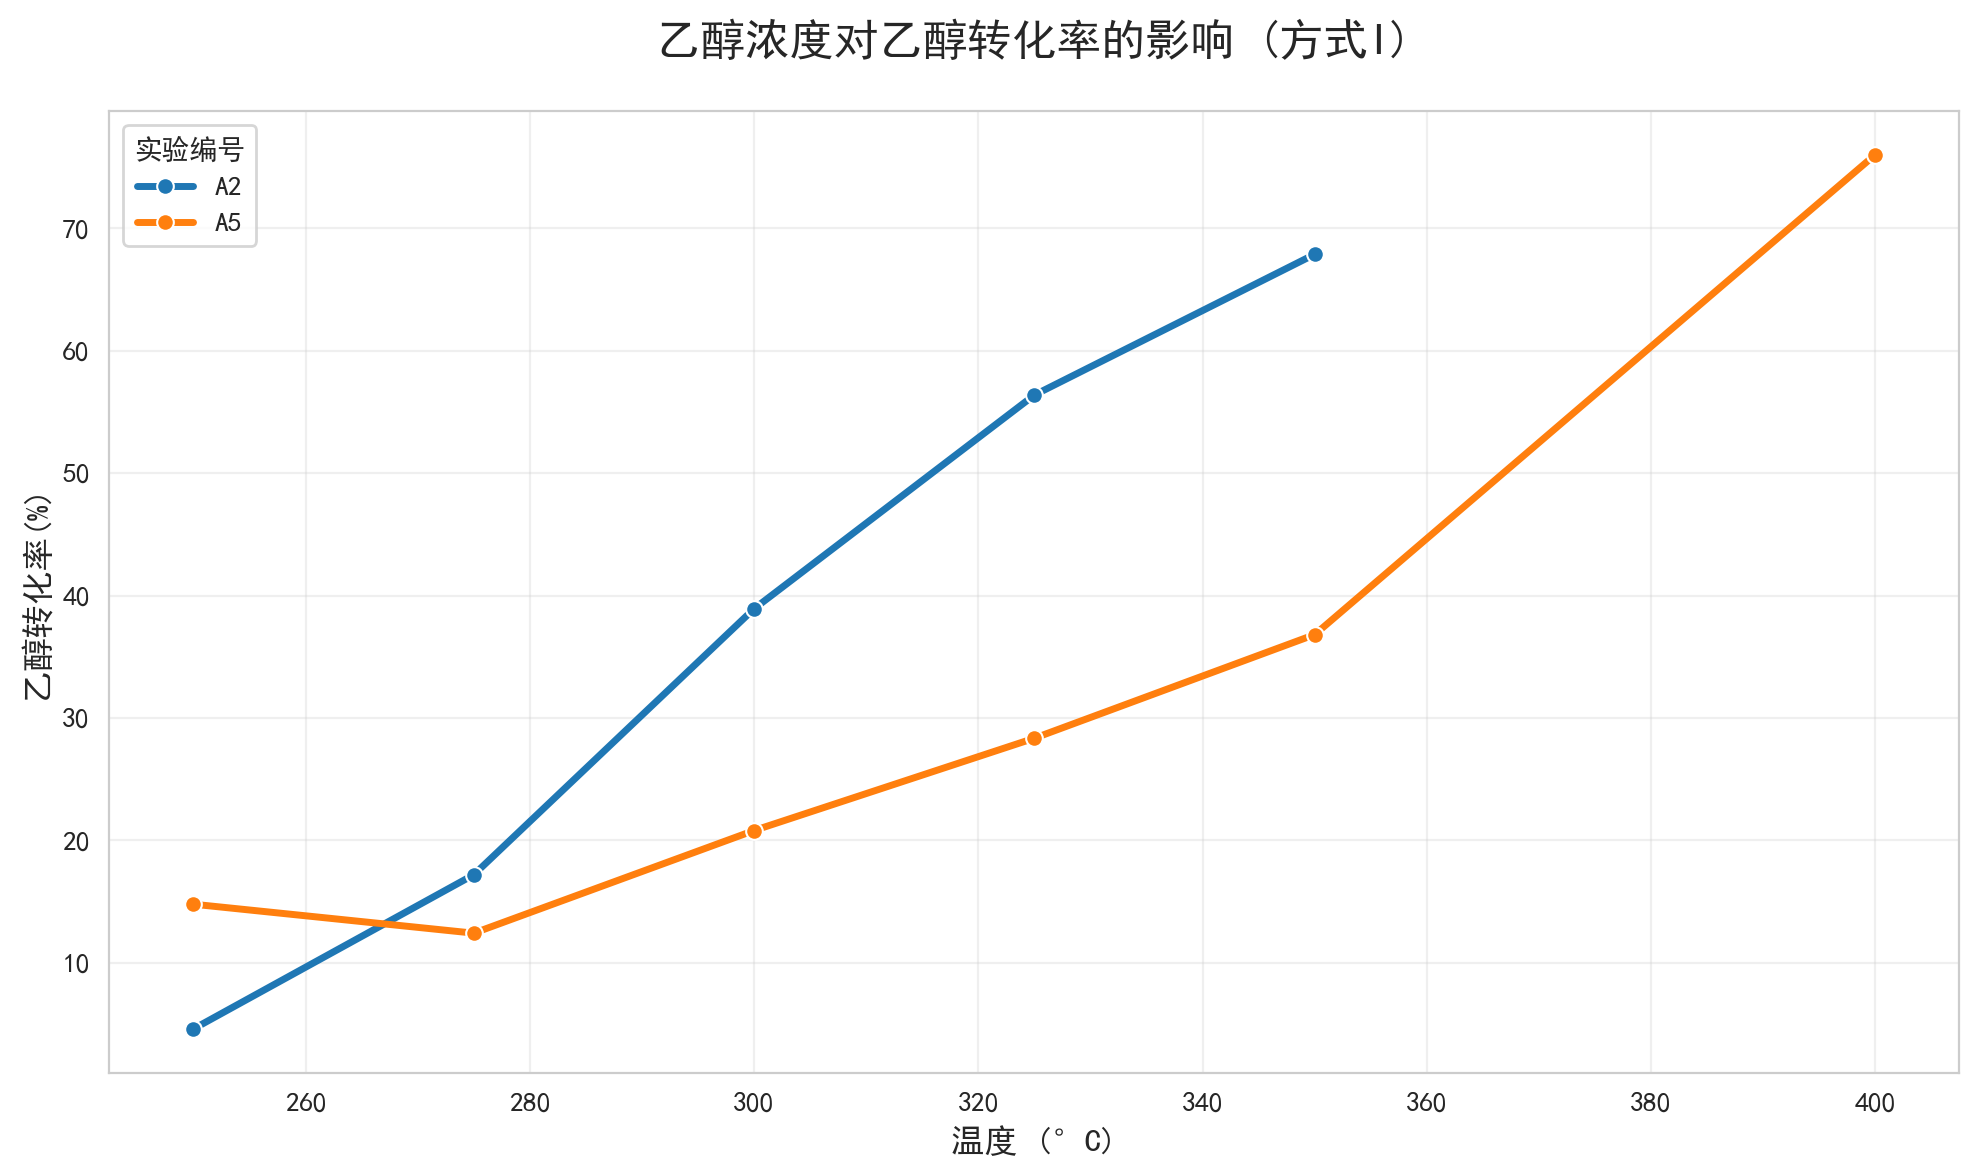

--- 乙醇浓度对照 (A2 vs A5) 在 350°C ---
A2 (1.68ml/min): 转化率=67.9%，C4选择性=39.10%
A5 (0.3ml/min): 转化率=36.8%，C4选择性=18.75%


In [8]:
group_2b = ['A2', 'A5']
plot_comparison(df_clean, group_2b, '乙醇浓度对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_2b, '乙醇浓度对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 乙醇浓度对照 (A2 vs A5) 在 350°C ---")
a2_350 = df_clean[(df_clean['编号']=='A2') & (df_clean['温度']==350)]
a5_350 = df_clean[(df_clean['编号']=='A5') & (df_clean['温度']==350)]
print(f"A2 (1.68ml/min): 转化率={a2_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a2_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A5 (0.3ml/min): 转化率={a5_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a5_350['C4烯烃选择性(%)'].values[0]:.2f}%")

### A7 vs A8 vs A9 vs A12


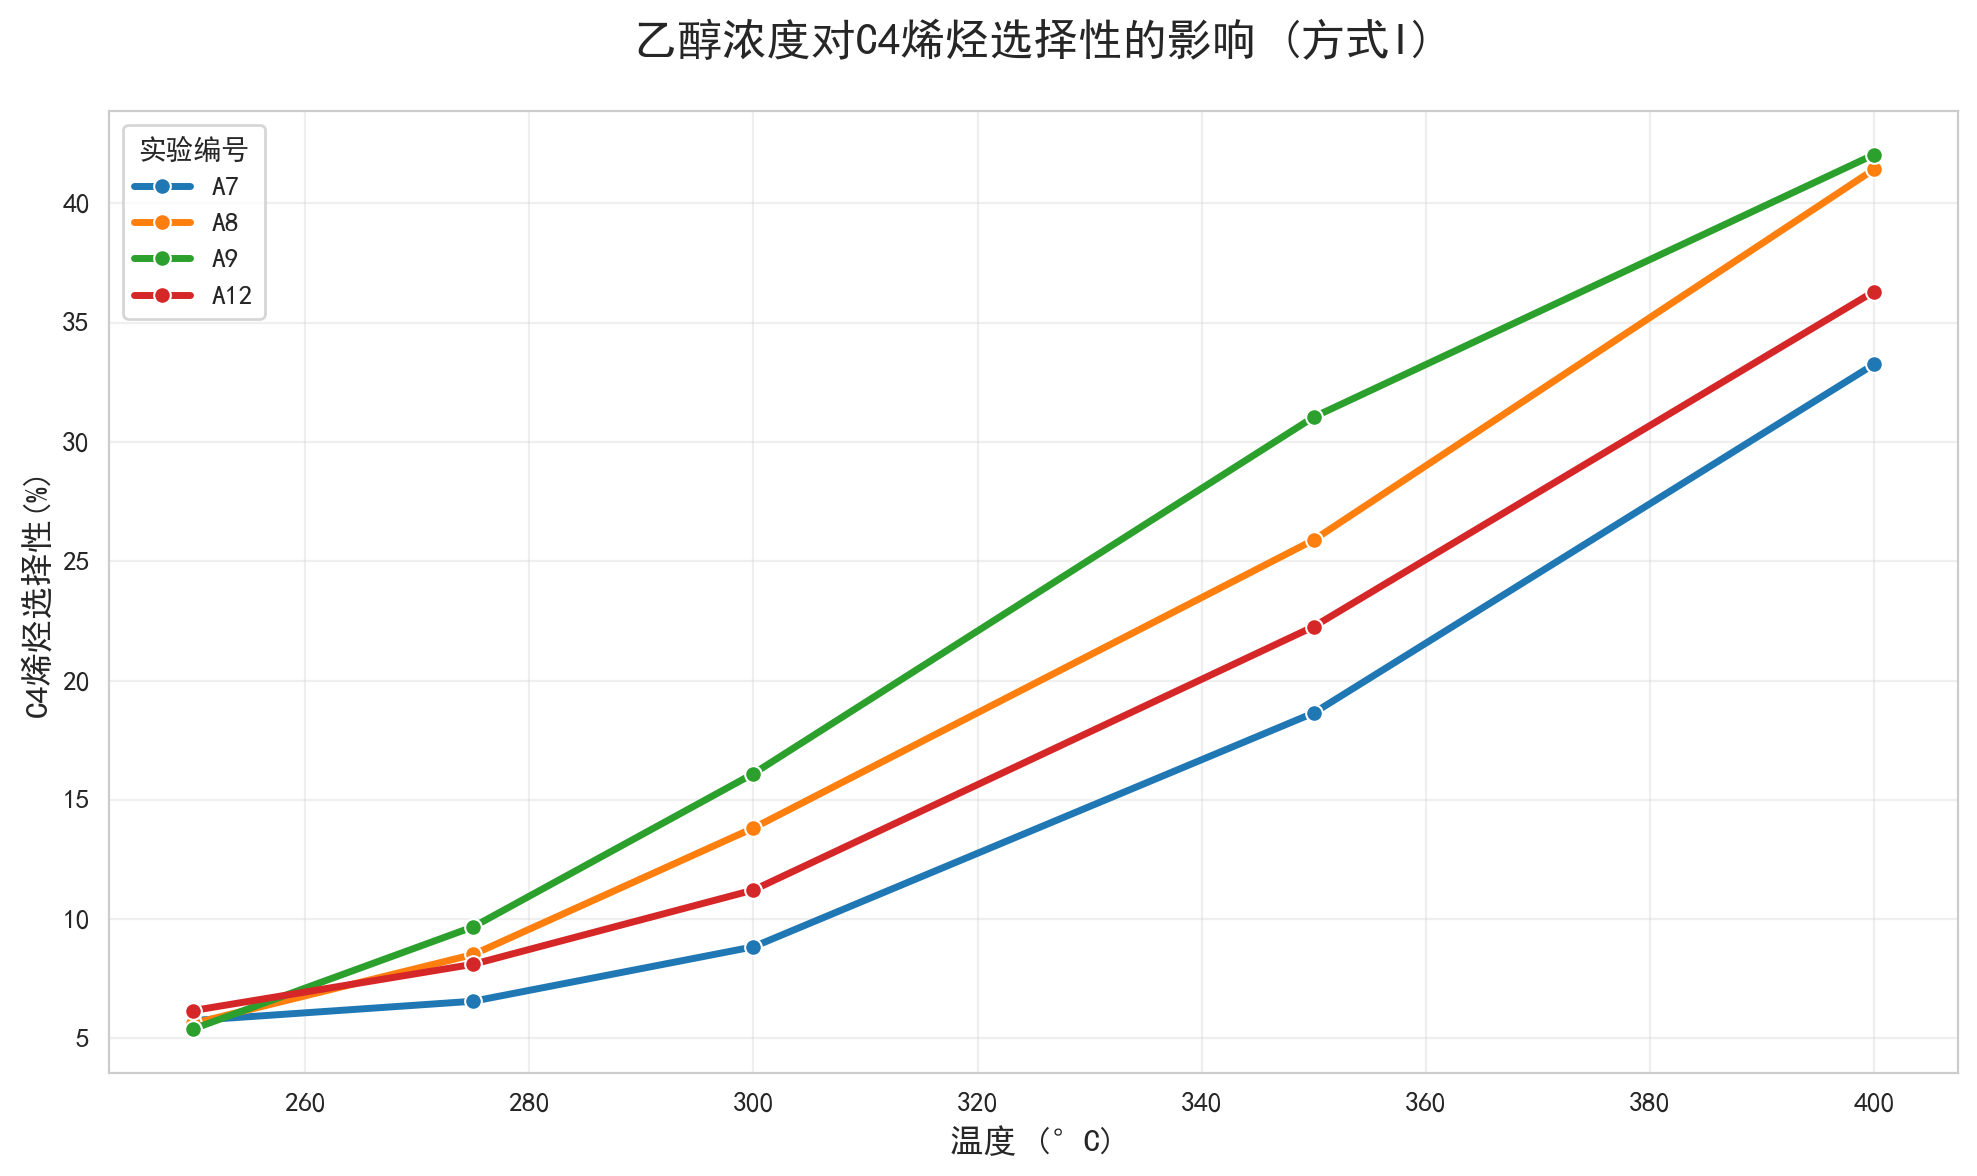

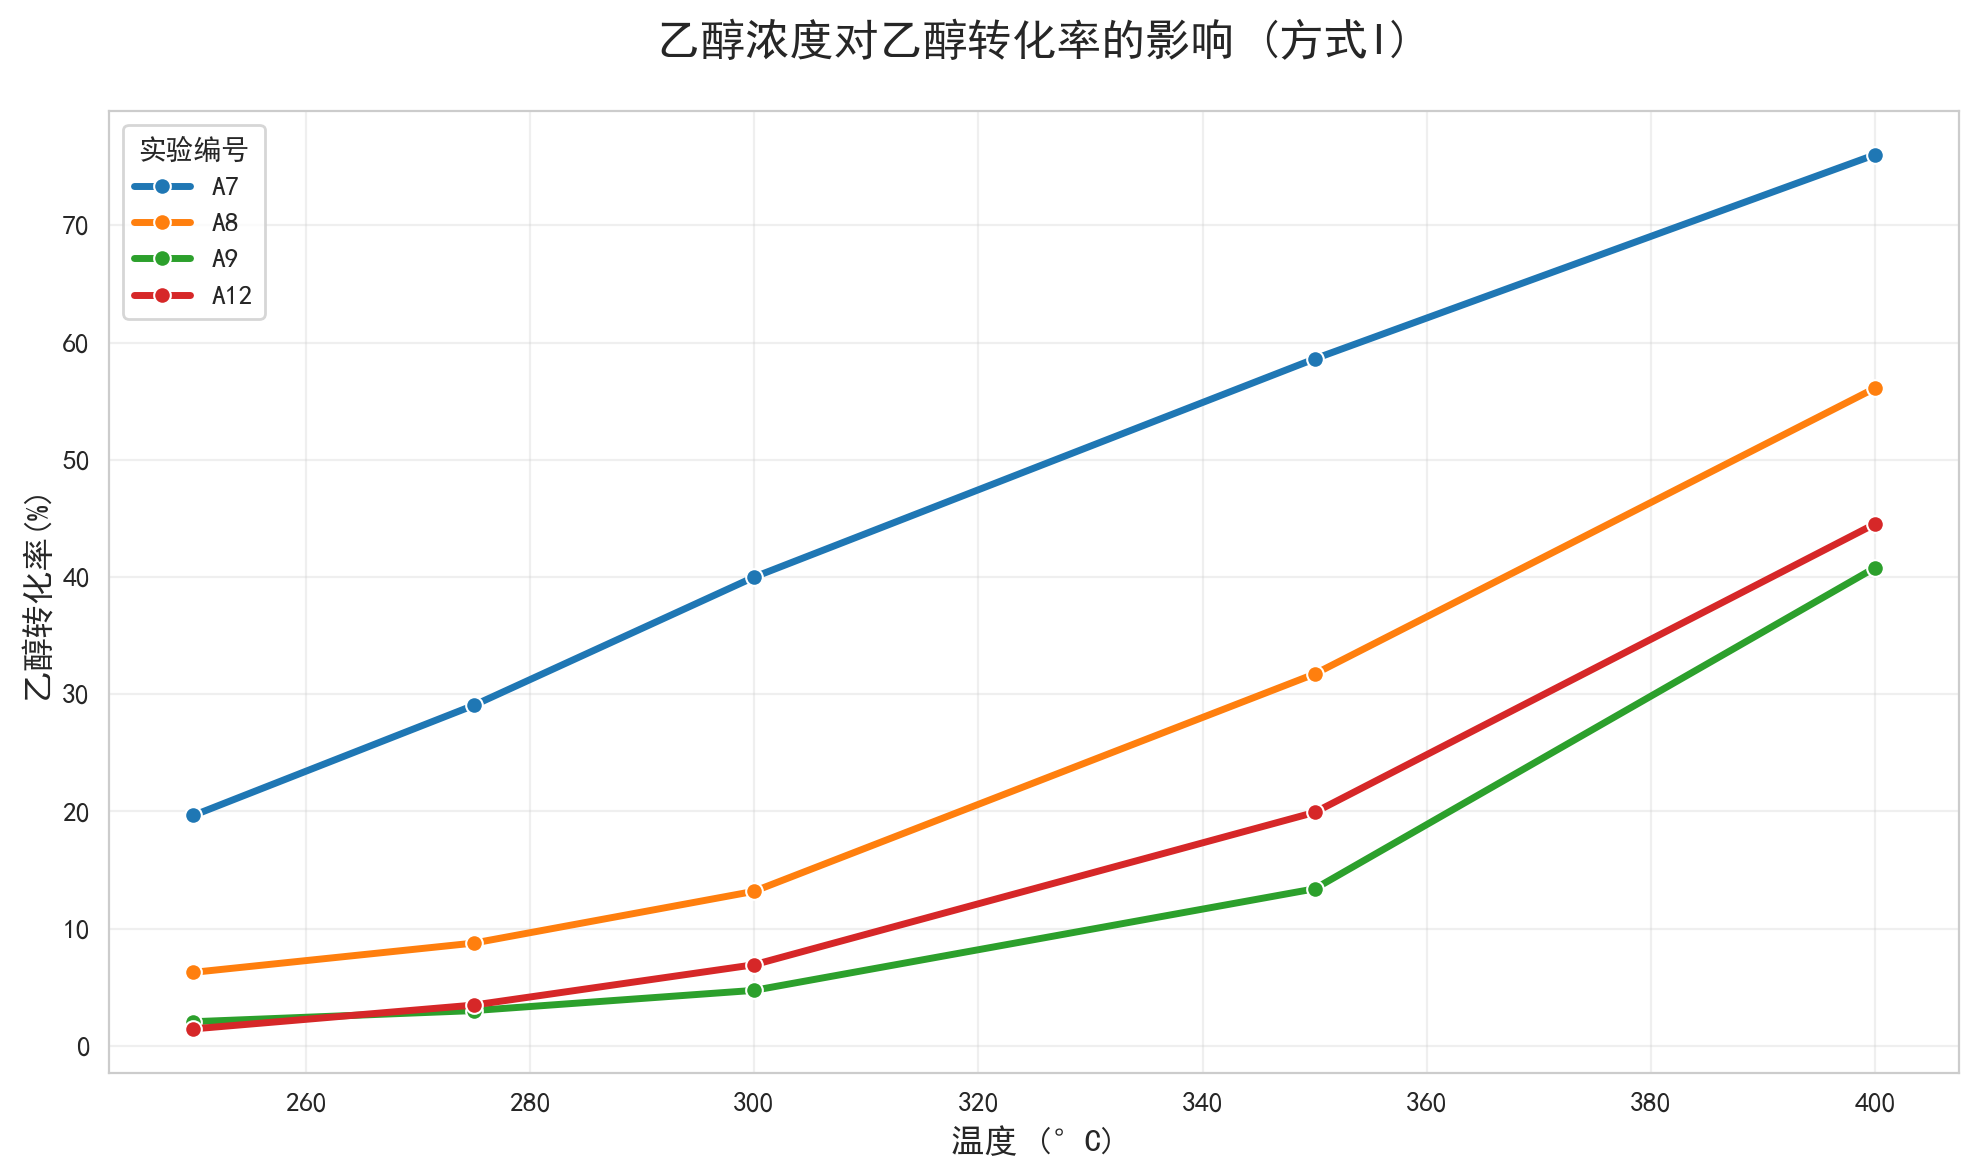

--- 乙醇浓度对照 (A7 vs A8 vs A9 vs A12) 在 350°C ---
A7 (0.3ml/min)：转化率=58.6%，C4选择性=18.64%
A8 (0.9ml/min)：转化率=31.7%，C4选择性=25.89%
A9 (2.1ml/min)：转化率=13.4%，C4选择性=31.04%
A12 (1.68ml/min)：转化率=19.9%，C4选择性=22.26%


In [9]:
group_2c = ['A7', 'A8', 'A9', 'A12']
plot_comparison(df_clean, group_2c, '乙醇浓度对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_2c, '乙醇浓度对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 乙醇浓度对照 (A7 vs A8 vs A9 vs A12) 在 350°C ---")
a7_350 = df_clean[(df_clean['编号']=='A7') & (df_clean['温度']==350)]
a8_350 = df_clean[(df_clean['编号']=='A8') & (df_clean['温度']==350)]
a9_350 = df_clean[(df_clean['编号']=='A9') & (df_clean['温度']==350)]
a12_350 = df_clean[(df_clean['编号']=='A12') & (df_clean['温度']==350)]
print(f"A7 (0.3ml/min)：转化率={a7_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a7_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A8 (0.9ml/min)：转化率={a8_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a8_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A9 (2.1ml/min)：转化率={a9_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a9_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A12 (1.68ml/min)：转化率={a12_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a12_350['C4烯烃选择性(%)'].values[0]:.2f}%")

### B1 vs B5


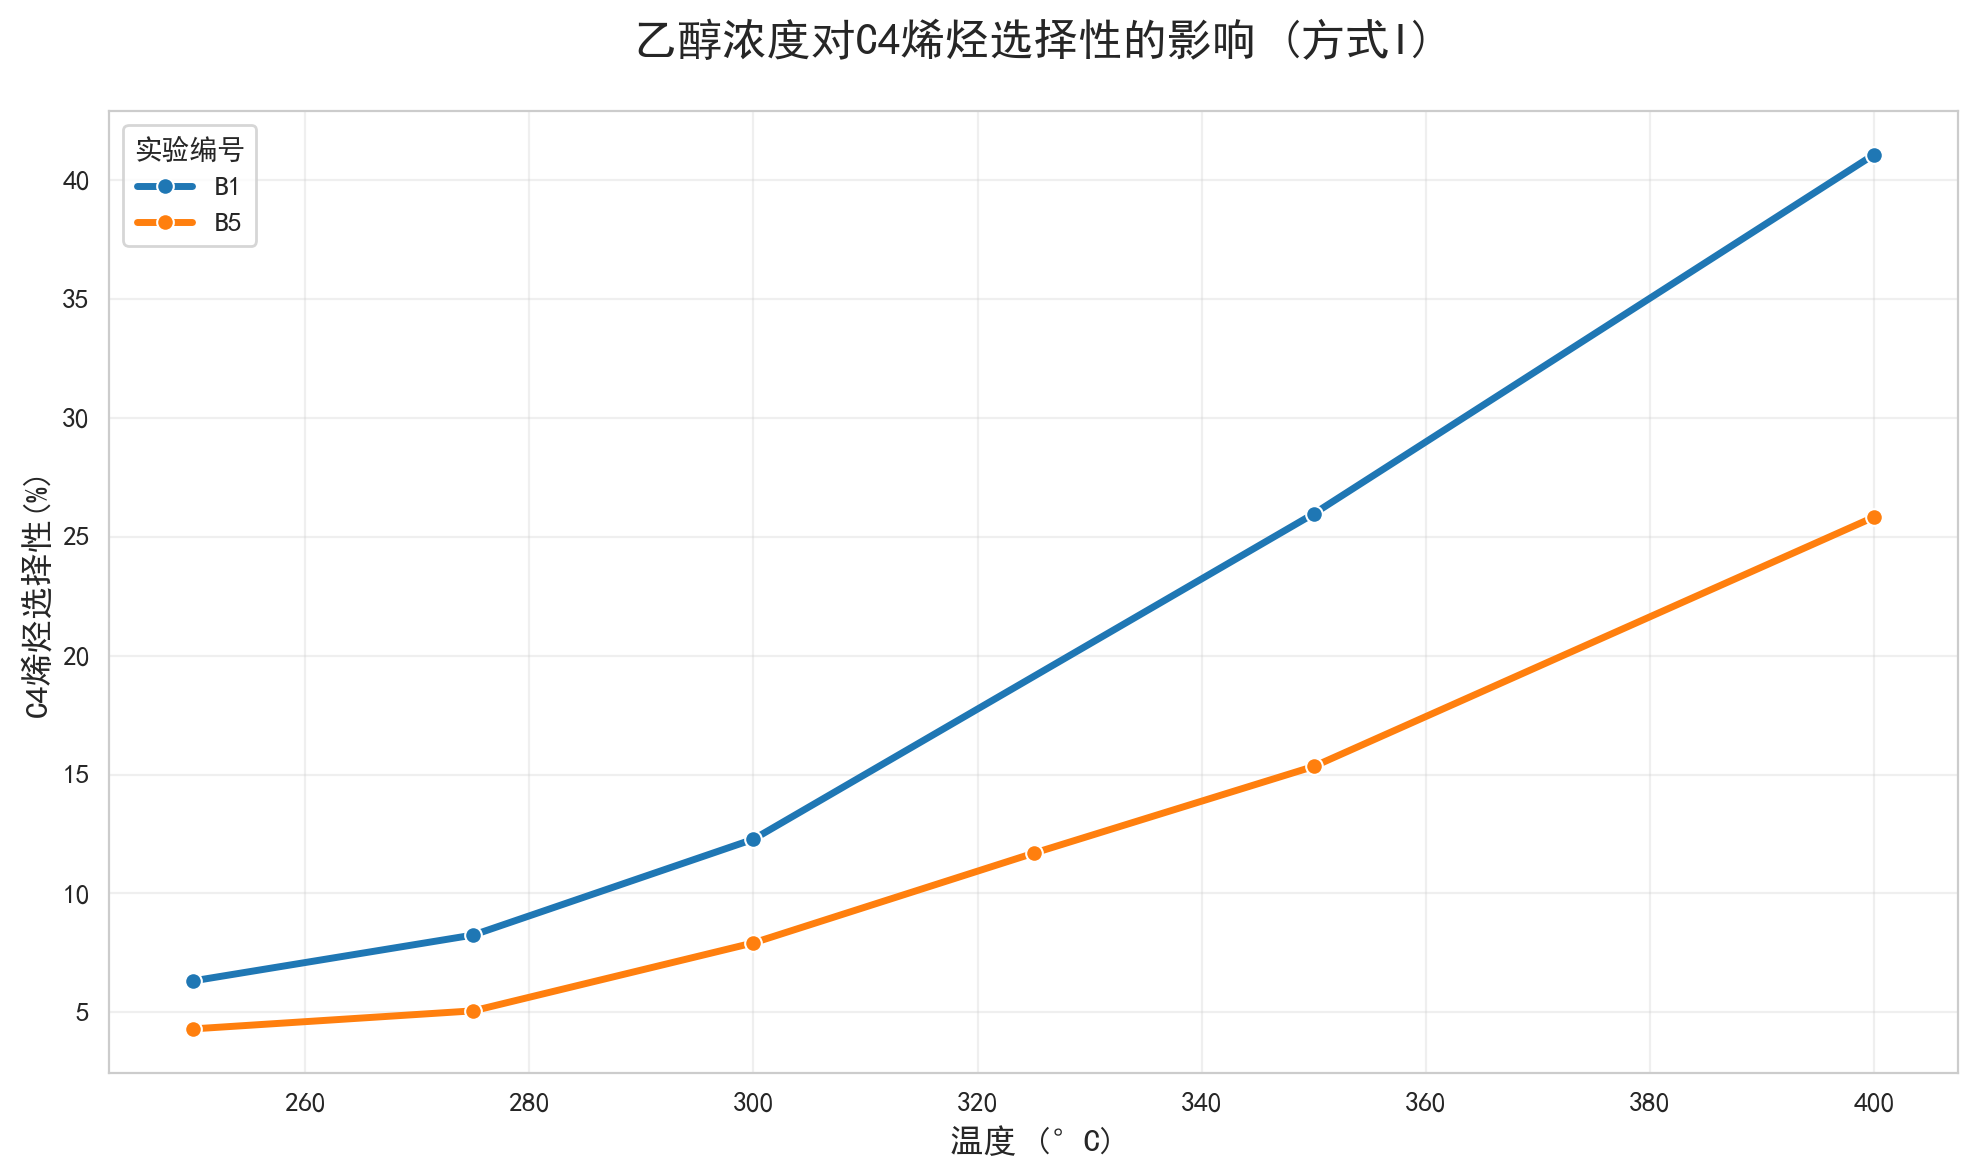

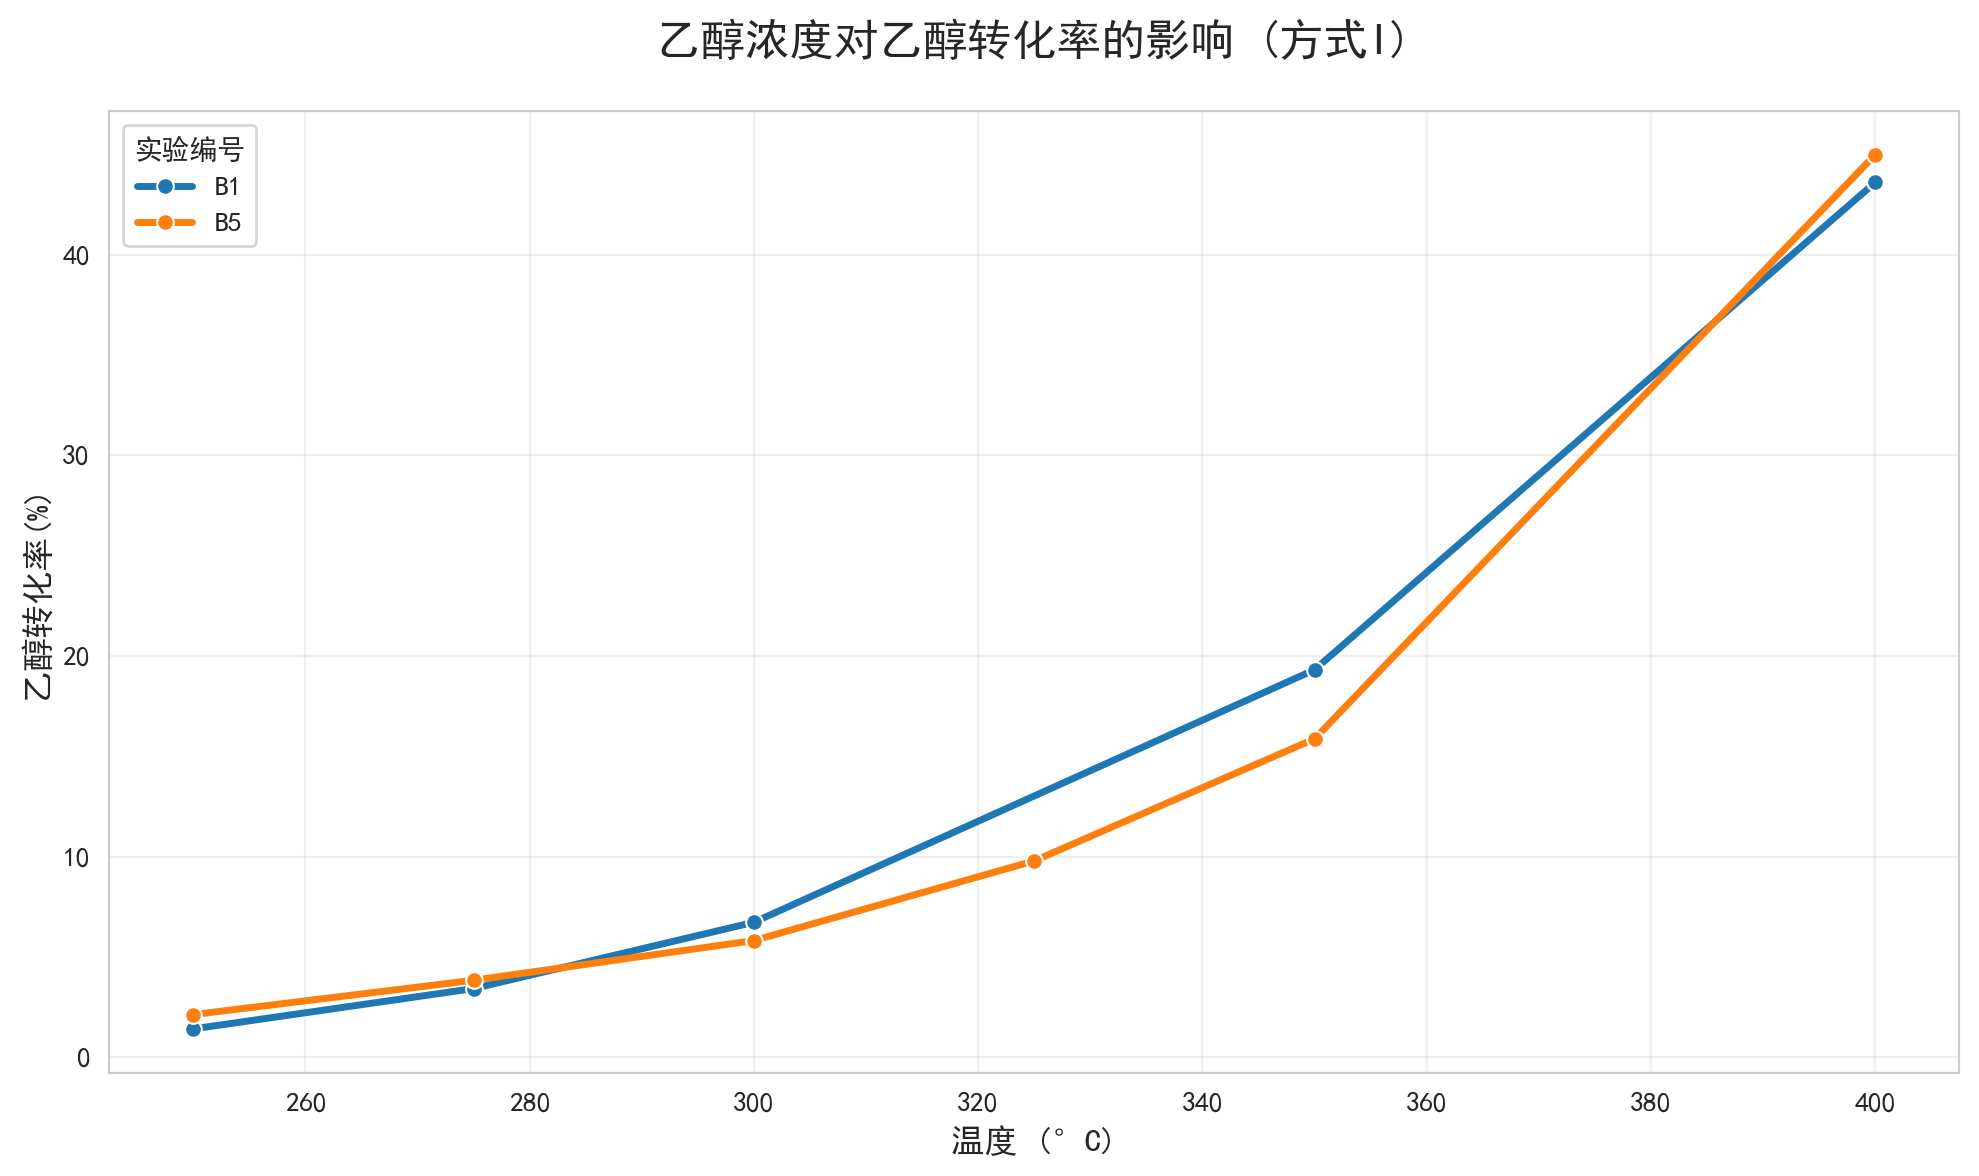

--- 乙醇浓度对照 (B1 vs B5) 在 350°C ---
B1 (1.68ml/min): 转化率=19.3%，C4选择性=25.97%
B5 (2.1ml/min): 转化率=15.9%，C4选择性=15.34%


In [10]:
group_2d = ['B1', 'B5']
plot_comparison(df_clean, group_2d, '乙醇浓度对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_2d, '乙醇浓度对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 乙醇浓度对照 (B1 vs B5) 在 350°C ---")
b1_350 = df_clean[(df_clean['编号']=='B1') & (df_clean['温度']==350)]
b5_350 = df_clean[(df_clean['编号']=='B5') & (df_clean['温度']==350)]
print(f"B1 (1.68ml/min): 转化率={b1_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={b1_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"B5 (2.1ml/min): 转化率={b5_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={b5_350['C4烯烃选择性(%)'].values[0]:.2f}%")

### B2 vs B7

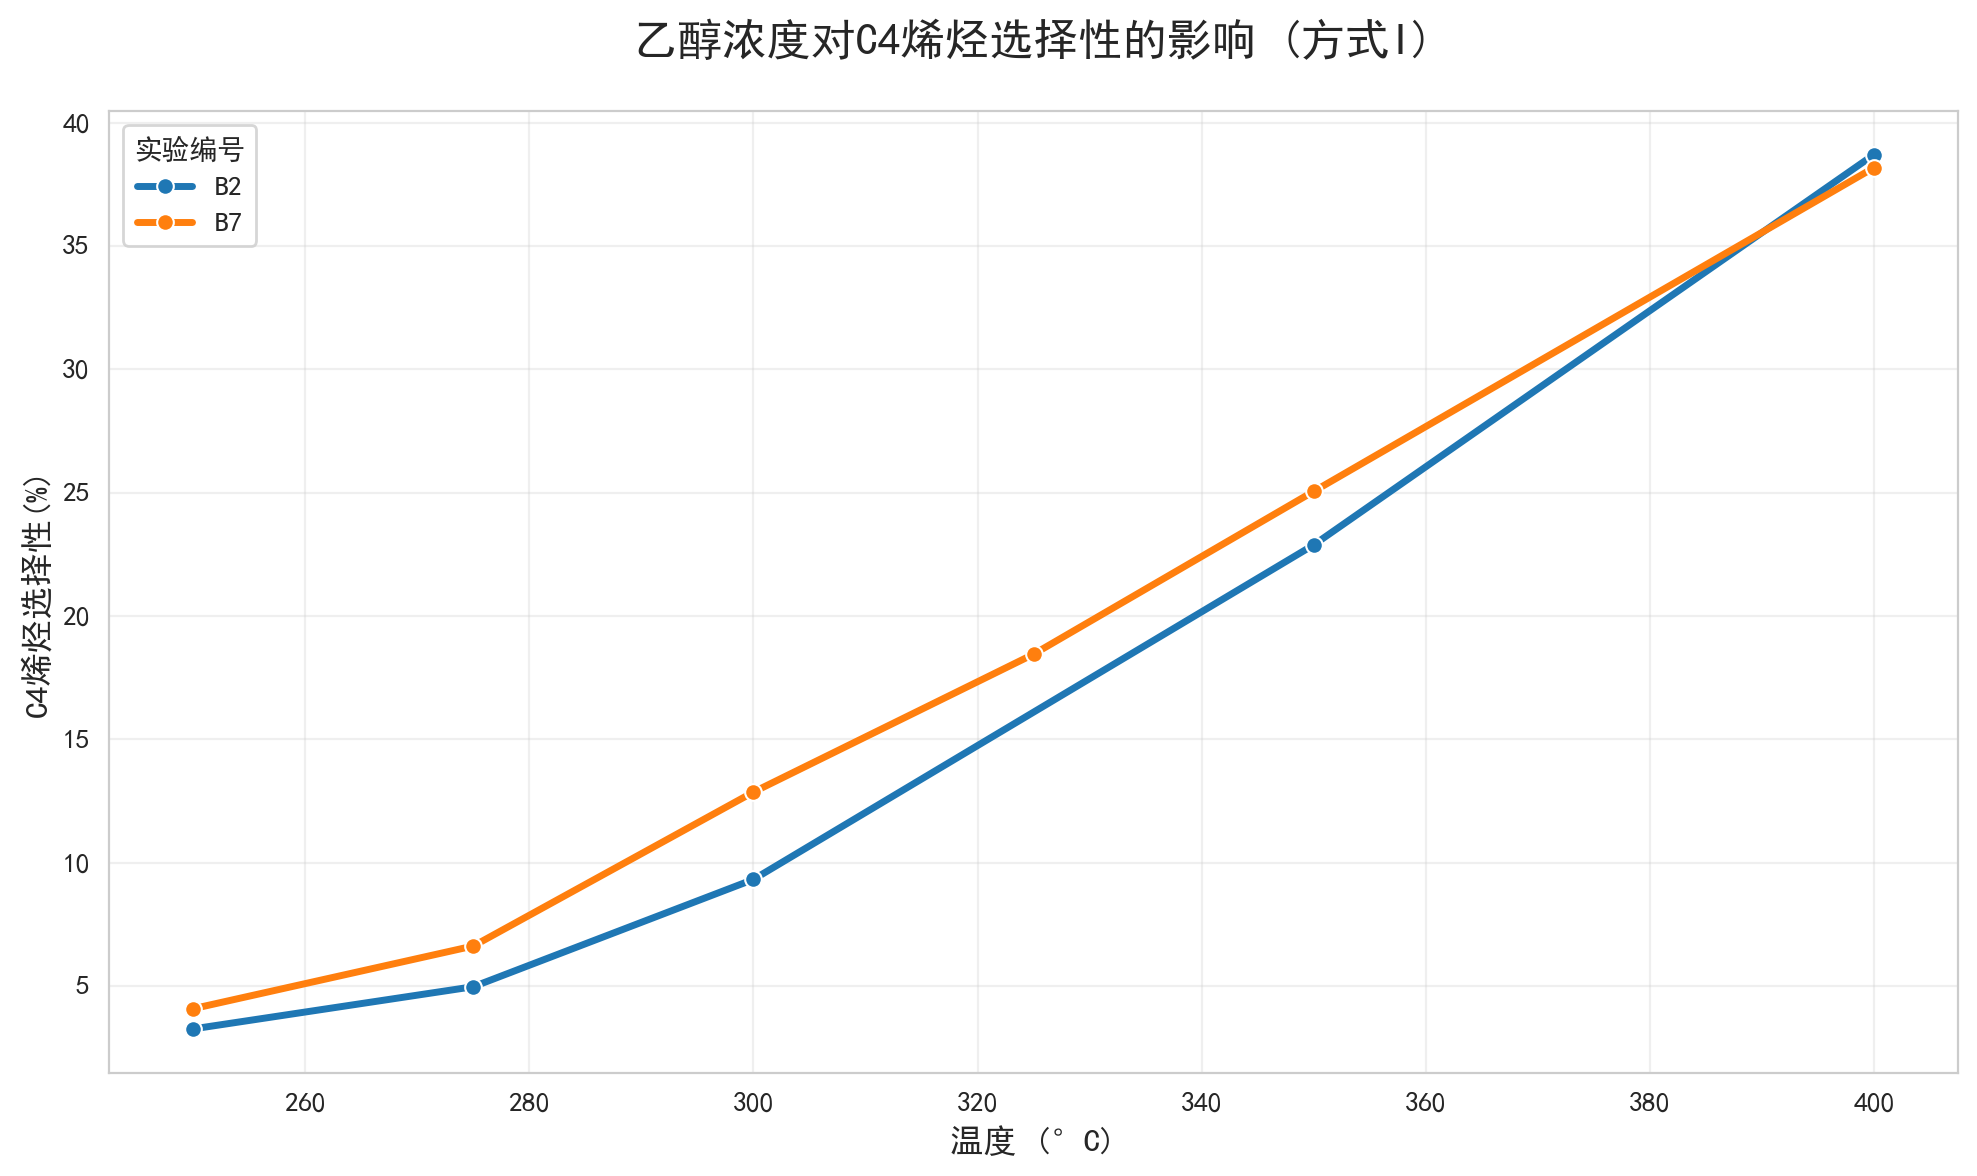

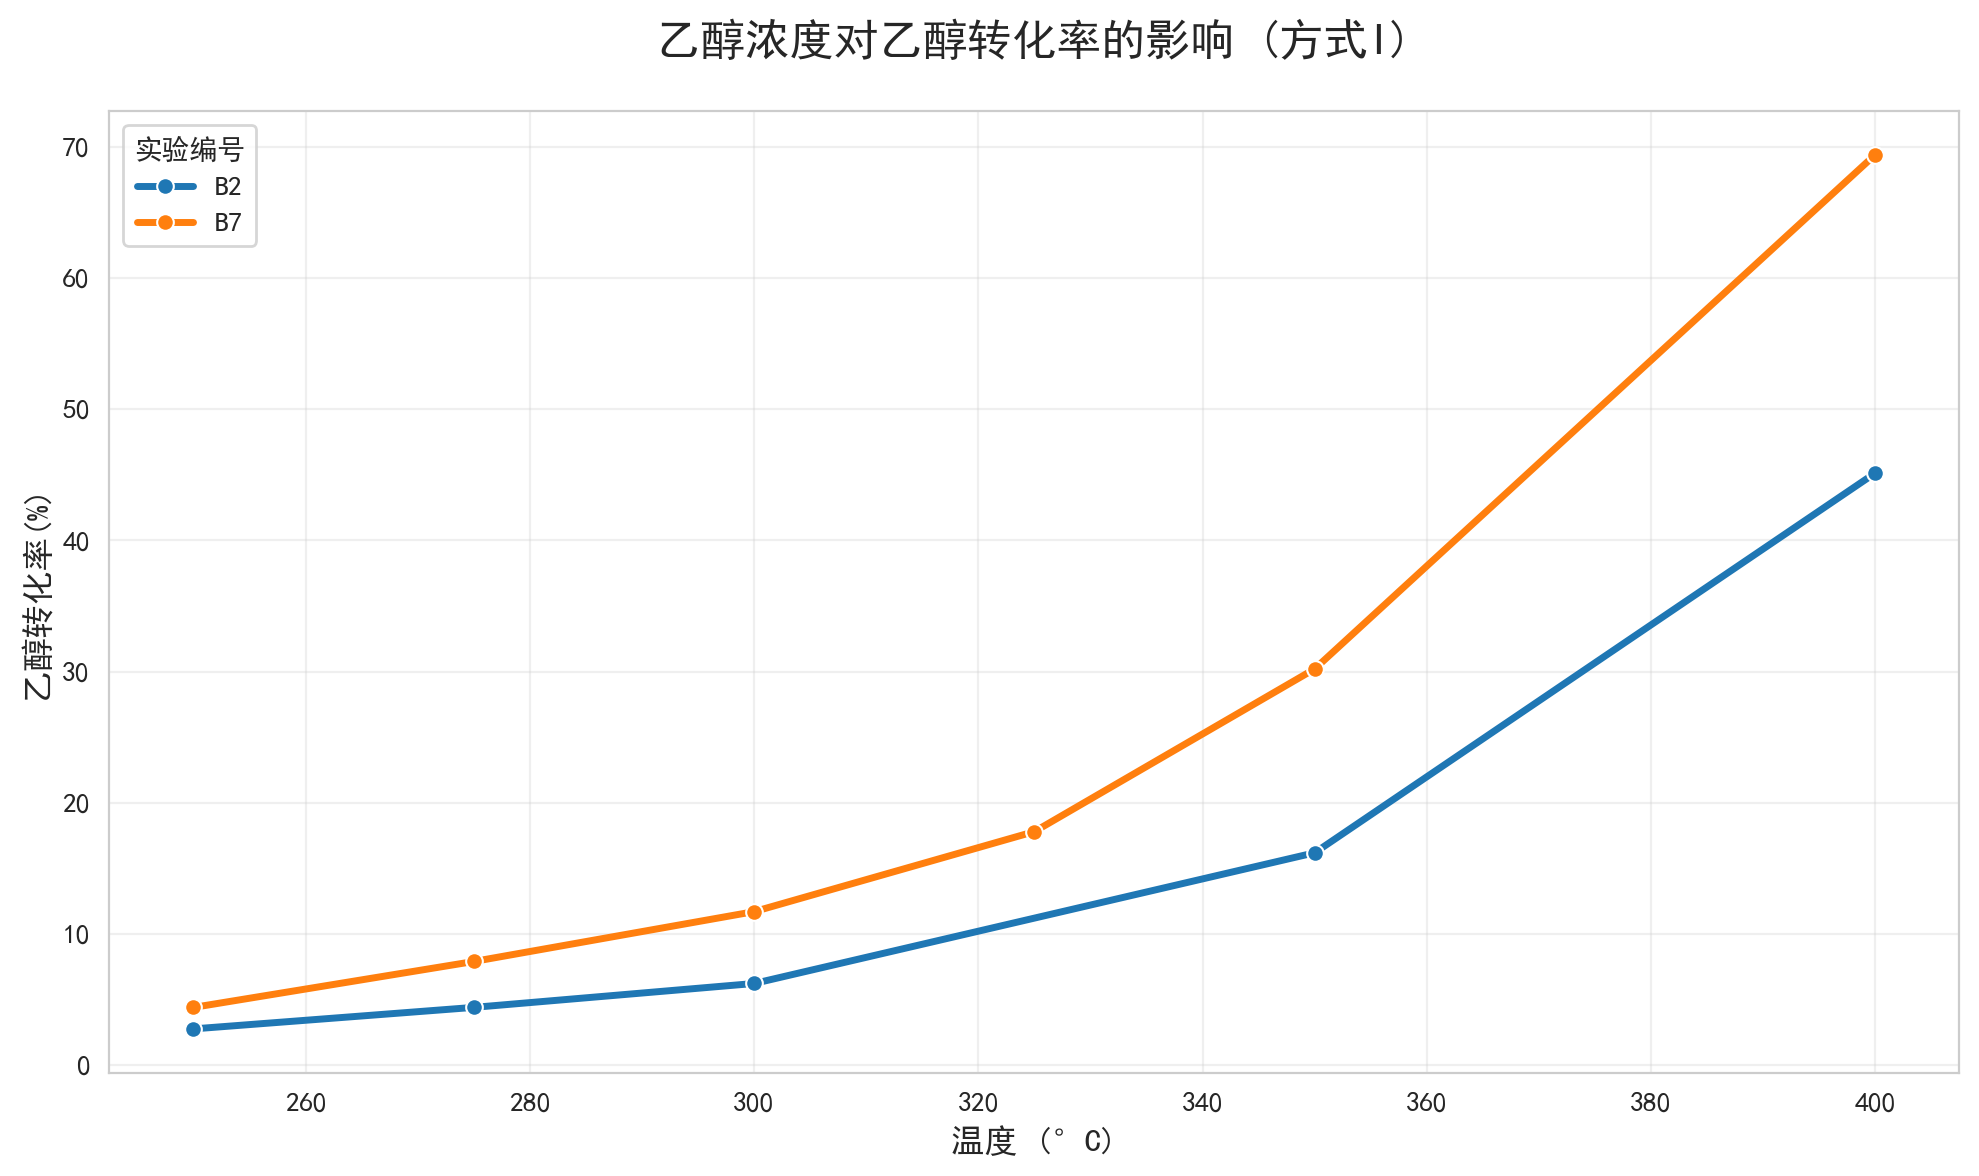

--- 乙醇浓度对照 (B2 vs B7) 在 350°C ---
B2 (1.68ml/min): 转化率=16.2%，C4选择性=22.88%
B7 (0.9ml/min): 转化率=30.2%，C4选择性=25.05%


In [11]:
group_2e = ['B2', 'B7']
plot_comparison(df_clean, group_2e, '乙醇浓度对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_2e, '乙醇浓度对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 乙醇浓度对照 (B2 vs B7) 在 350°C ---")
b2_350 = df_clean[(df_clean['编号']=='B2') & (df_clean['温度']==350)]
b7_350 = df_clean[(df_clean['编号']=='B7') & (df_clean['温度']==350)]
print(f"B2 (1.68ml/min): 转化率={b2_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={b2_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"B7 (0.9ml/min): 转化率={b7_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={b7_350['C4烯烃选择性(%)'].values[0]:.2f}%")

## 3. Co负载量不同：

### A1 vs A2 vs A4 vs A6

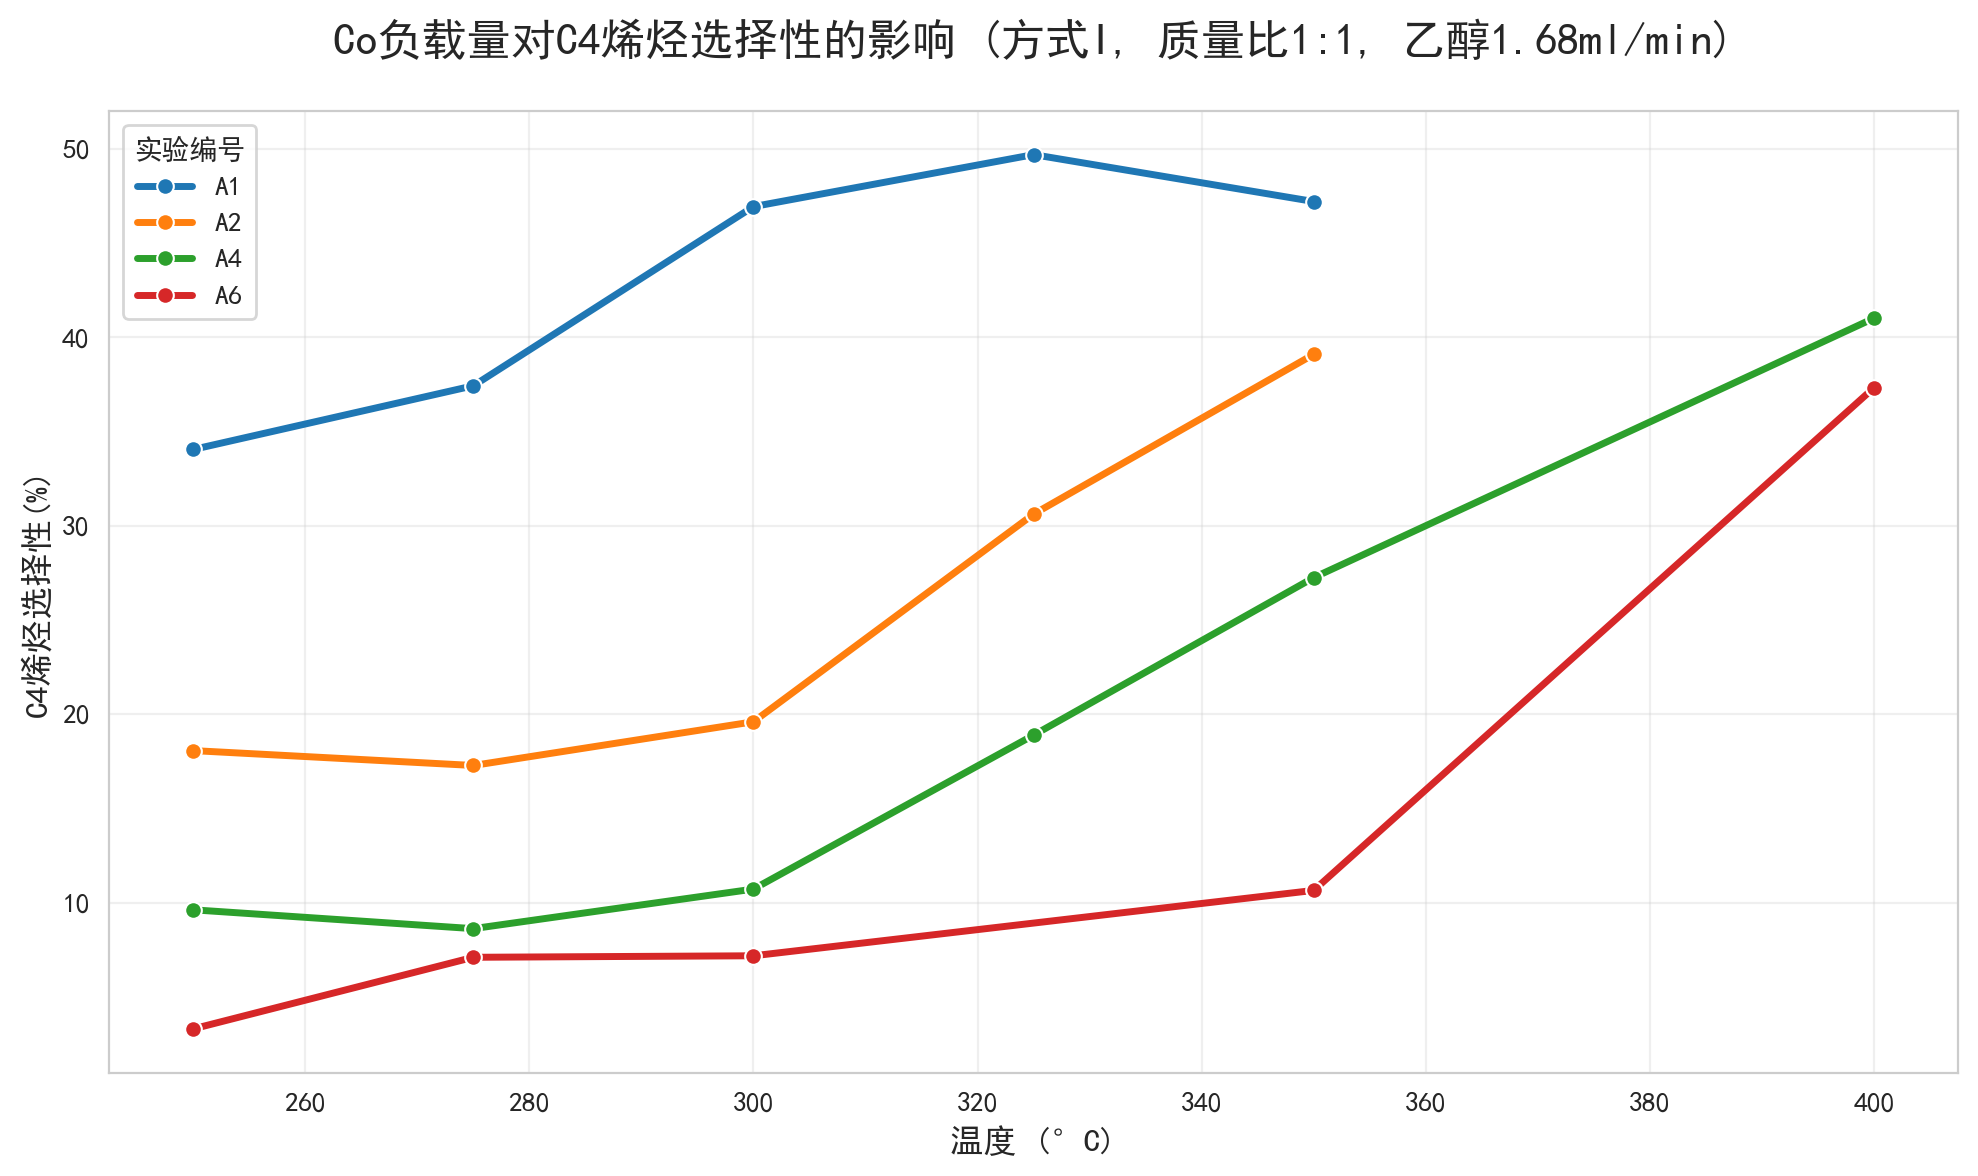

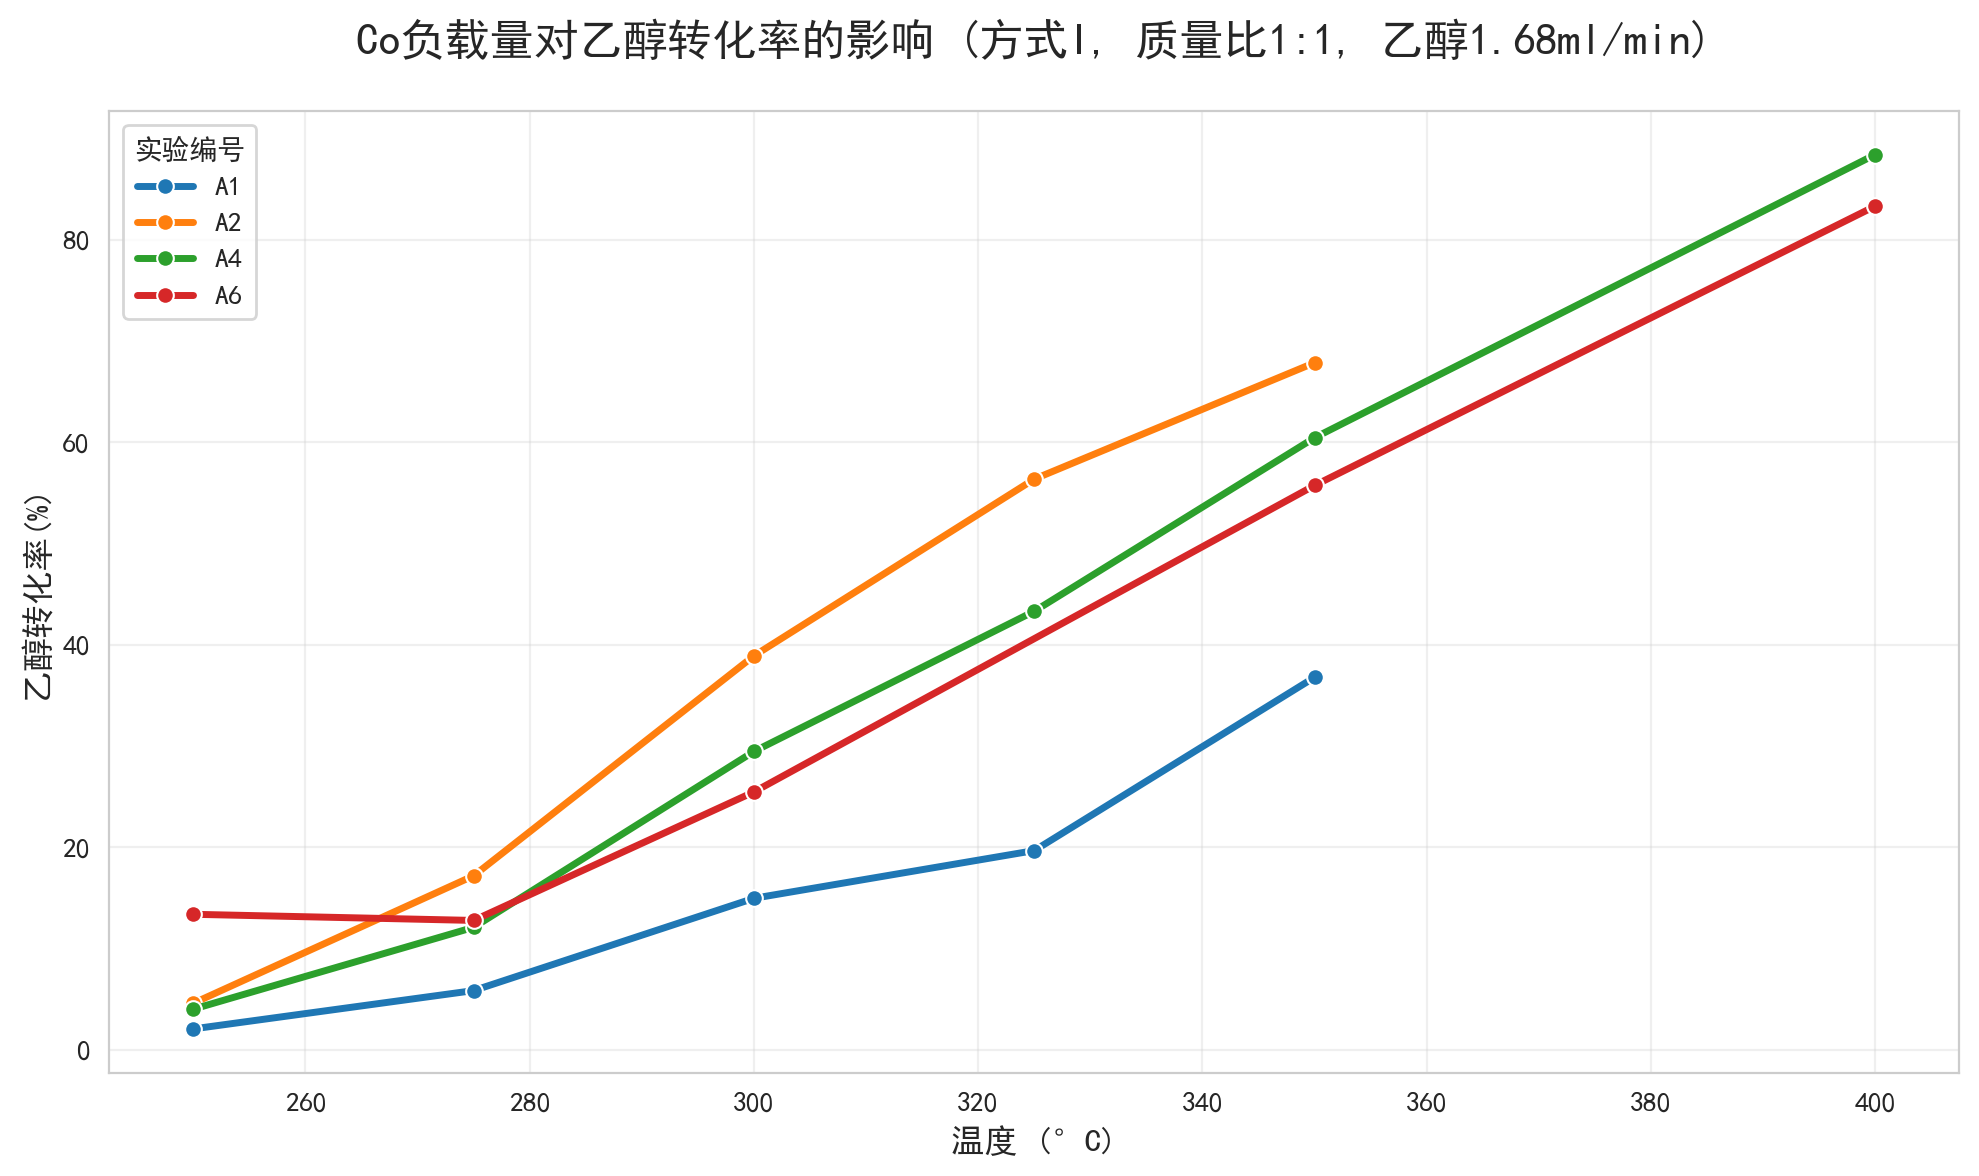

--- Co负载量对照 (A1, A2, A4, A6) 在 350°C ---
A1 (1.0wt%): 转化率=36.80%，C4选择性=47.21%
A2 (2.0wt%): 转化率=67.88%，C4选择性=39.10%
A4 (0.5wt%): 转化率=60.47%，C4选择性=27.25%
A6 (5.0wt%): 转化率=55.76%，C4选择性=10.65%


In [12]:
# 均为方式I, 质量比1:1, 乙醇1.68ml/min
group_3a = ['A1', 'A2', 'A4', 'A6']  
plot_comparison(df_clean, group_3a, 'Co负载量对C4烯烃选择性的影响 (方式I, 质量比1:1, 乙醇1.68ml/min)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_3a, 'Co负载量对乙醇转化率的影响 (方式I, 质量比1:1, 乙醇1.68ml/min)', '乙醇转化率(%)')

print(f"--- Co负载量对照 (A1, A2, A4, A6) 在 350°C ---")
for id_ in group_3a:
    data = df_clean[(df_clean['编号']==id_) & (df_clean['温度']==350)]
    co_load = data['Co负载量(wt%)'].values[0]
    selectivity = data['C4烯烃选择性(%)'].values[0]
    choices = data['乙醇转化率(%)'].values[0]
    print(f"{id_} ({co_load}wt%): 转化率={choices:.2f}%，C4选择性={selectivity:.2f}%")

### A9 vs A10

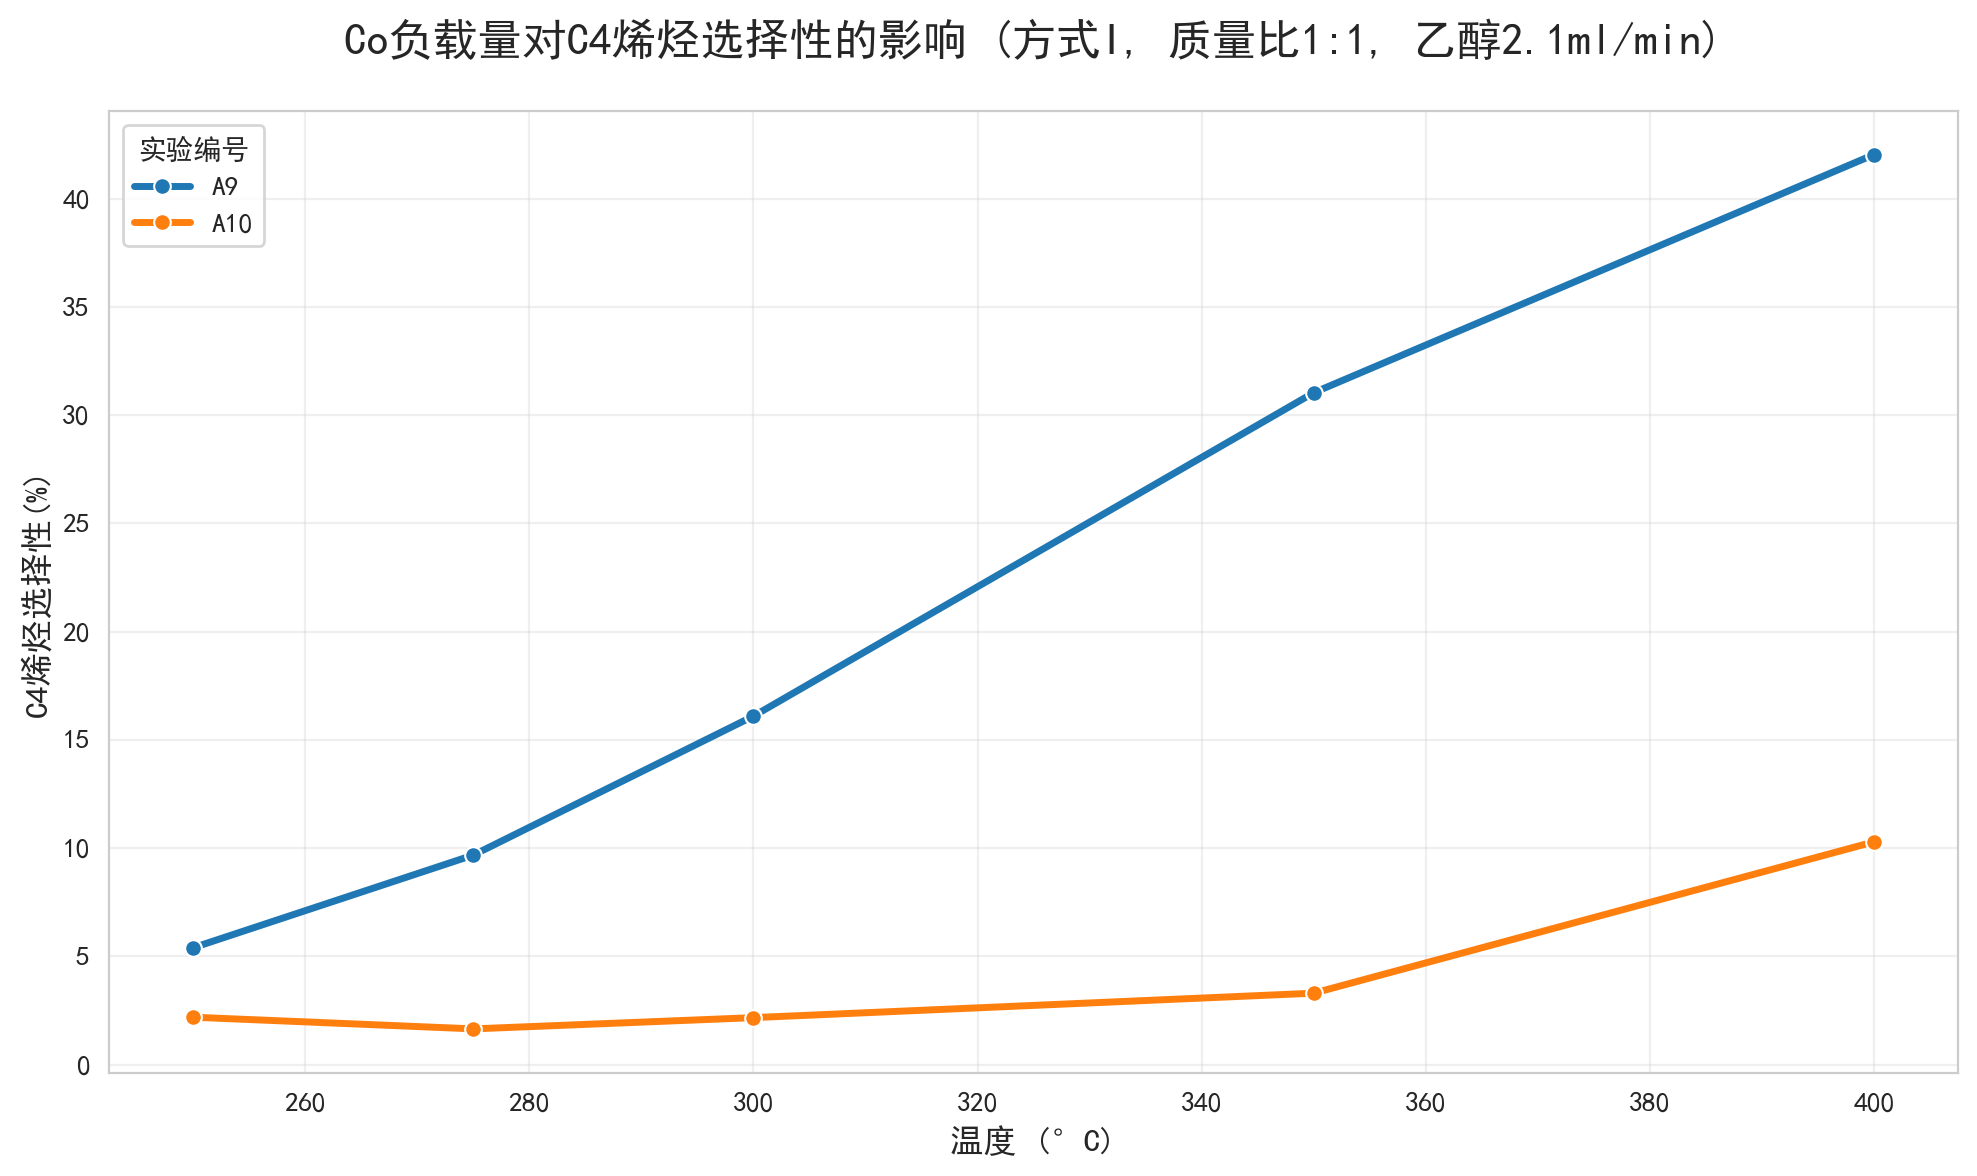

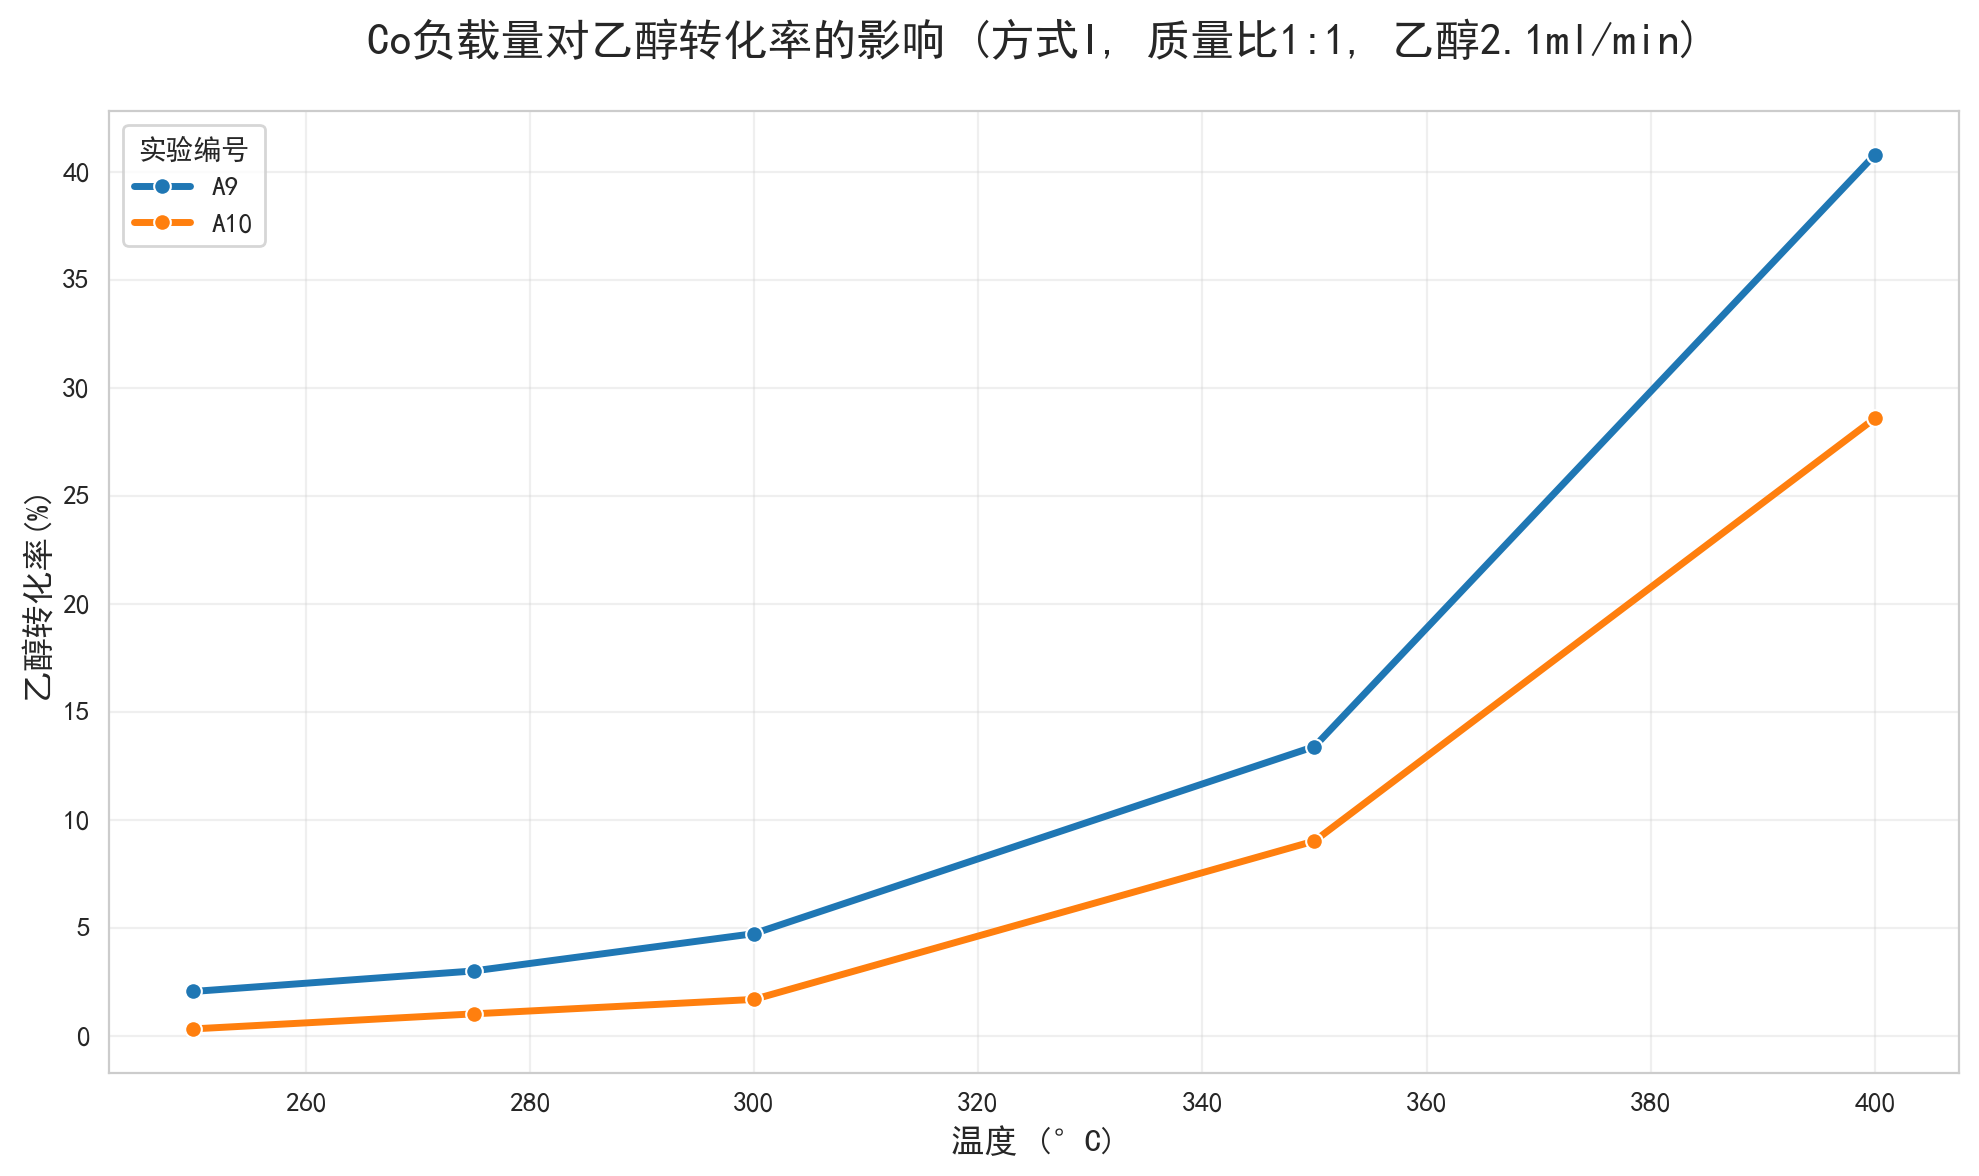

--- Co负载量对照 (A9, A10) 在 400°C ---
A9 (1.0wt%): 转化率=40.80%，C4选择性=42.04%
A10 (5.0wt%): 转化率=28.59%，C4选择性=10.29%


In [13]:
# 均为方式I, 质量比1:1, 乙醇2.1ml/min
group_3b = ['A9', 'A10']  
plot_comparison(df_clean, group_3b, 'Co负载量对C4烯烃选择性的影响 (方式I, 质量比1:1, 乙醇2.1ml/min)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_3b, 'Co负载量对乙醇转化率的影响 (方式I, 质量比1:1, 乙醇2.1ml/min)', '乙醇转化率(%)')

print(f"--- Co负载量对照 (A9, A10) 在 400°C ---")
for id_ in group_3b:
    data = df_clean[(df_clean['编号']==id_) & (df_clean['温度']==400)]
    co_load = data['Co负载量(wt%)'].values[0]
    selectivity = data['C4烯烃选择性(%)'].values[0]
    choices = data['乙醇转化率(%)'].values[0]
    print(f"{id_} ({co_load}wt%): 转化率={choices:.2f}%，C4选择性={selectivity:.2f}%")

## 4. 有无HAP

### A11 vs A12

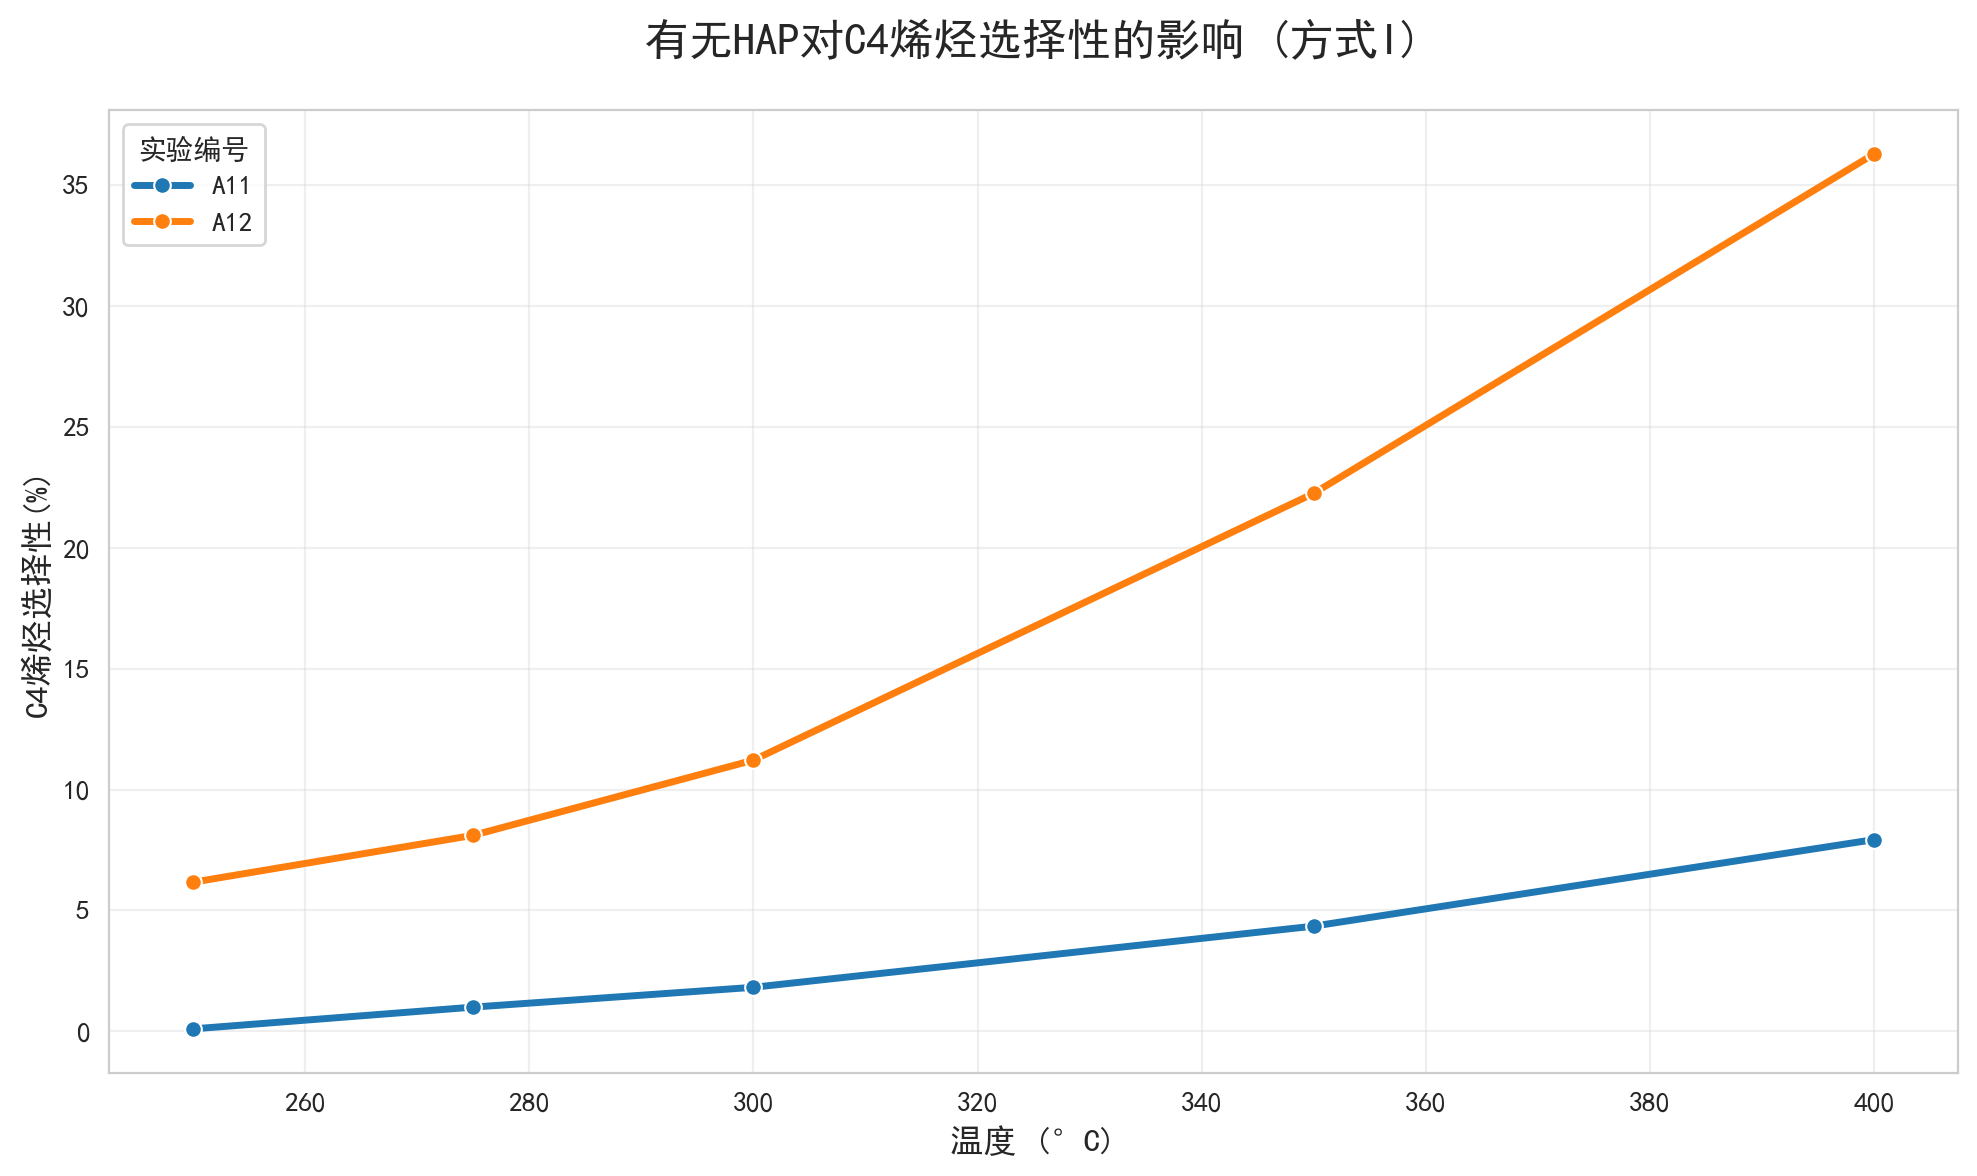

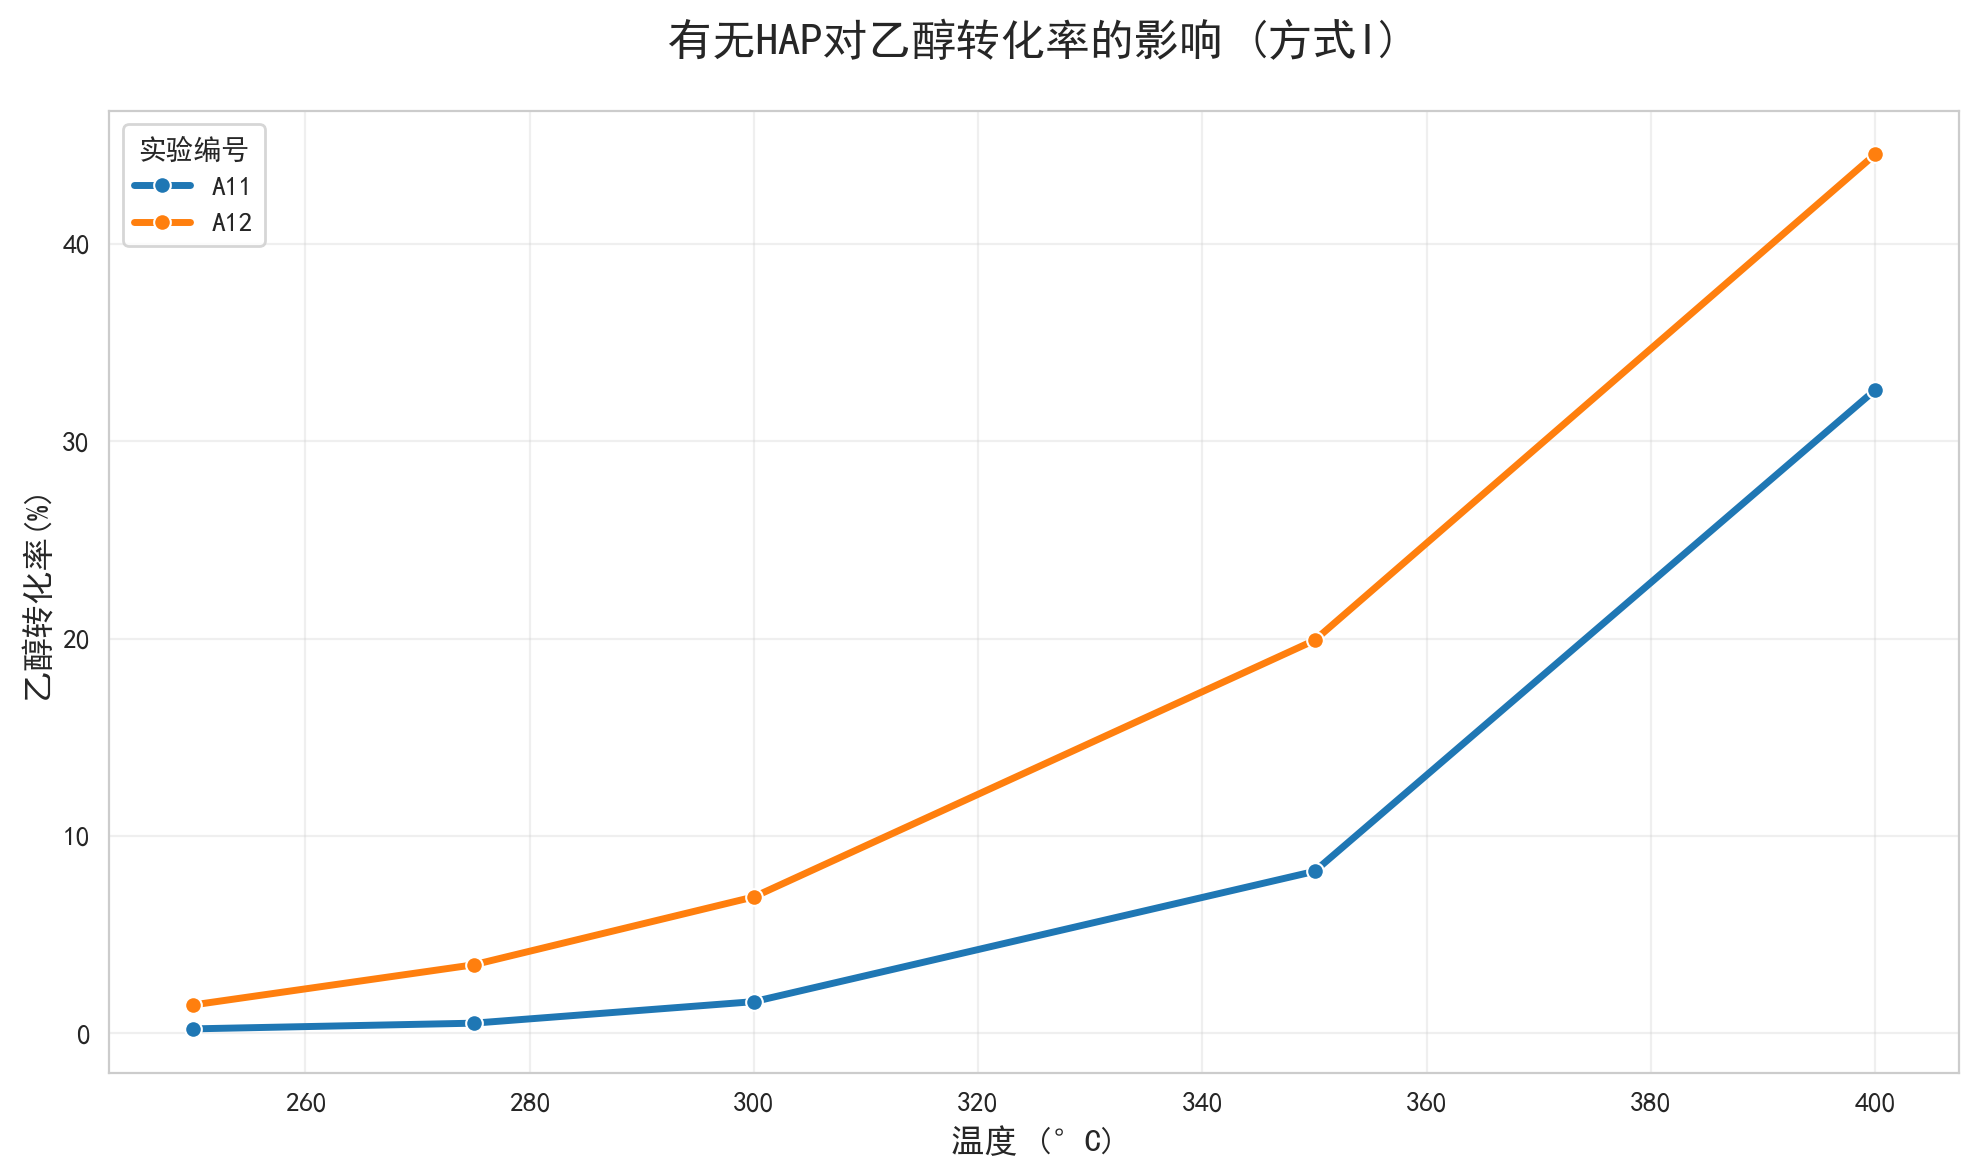

--- 有无HAP对照 (A11 vs A12) 在 400°C ---
A11 (无HAP): 转化率=32.6%，C4选择性=7.93%
A12 (有HAP): 转化率=44.5%，C4选择性=36.30%


In [14]:
# Co负载1wt%, 乙醇1.68ml/min, 方式I
group_4 = ['A11', 'A12']  
plot_comparison(df_clean, group_4, '有无HAP对C4烯烃选择性的影响 (方式I)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_4, '有无HAP对乙醇转化率的影响 (方式I)', '乙醇转化率(%)')

print(f"--- 有无HAP对照 (A11 vs A12) 在 400°C ---")
a11_350 = df_clean[(df_clean['编号']=='A11') & (df_clean['温度']==400)]
a12_350 = df_clean[(df_clean['编号']=='A12') & (df_clean['温度']==400)]
print(f"A11 (无HAP): 转化率={a11_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a11_350['C4烯烃选择性(%)'].values[0]:.2f}%")
print(f"A12 (有HAP): 转化率={a12_350['乙醇转化率(%)'].values[0]:.1f}%，C4选择性={a12_350['C4烯烃选择性(%)'].values[0]:.2f}%")

# 5. 总质量不变，Co与HAP质量比不同

### A12 vs A13 vs A14

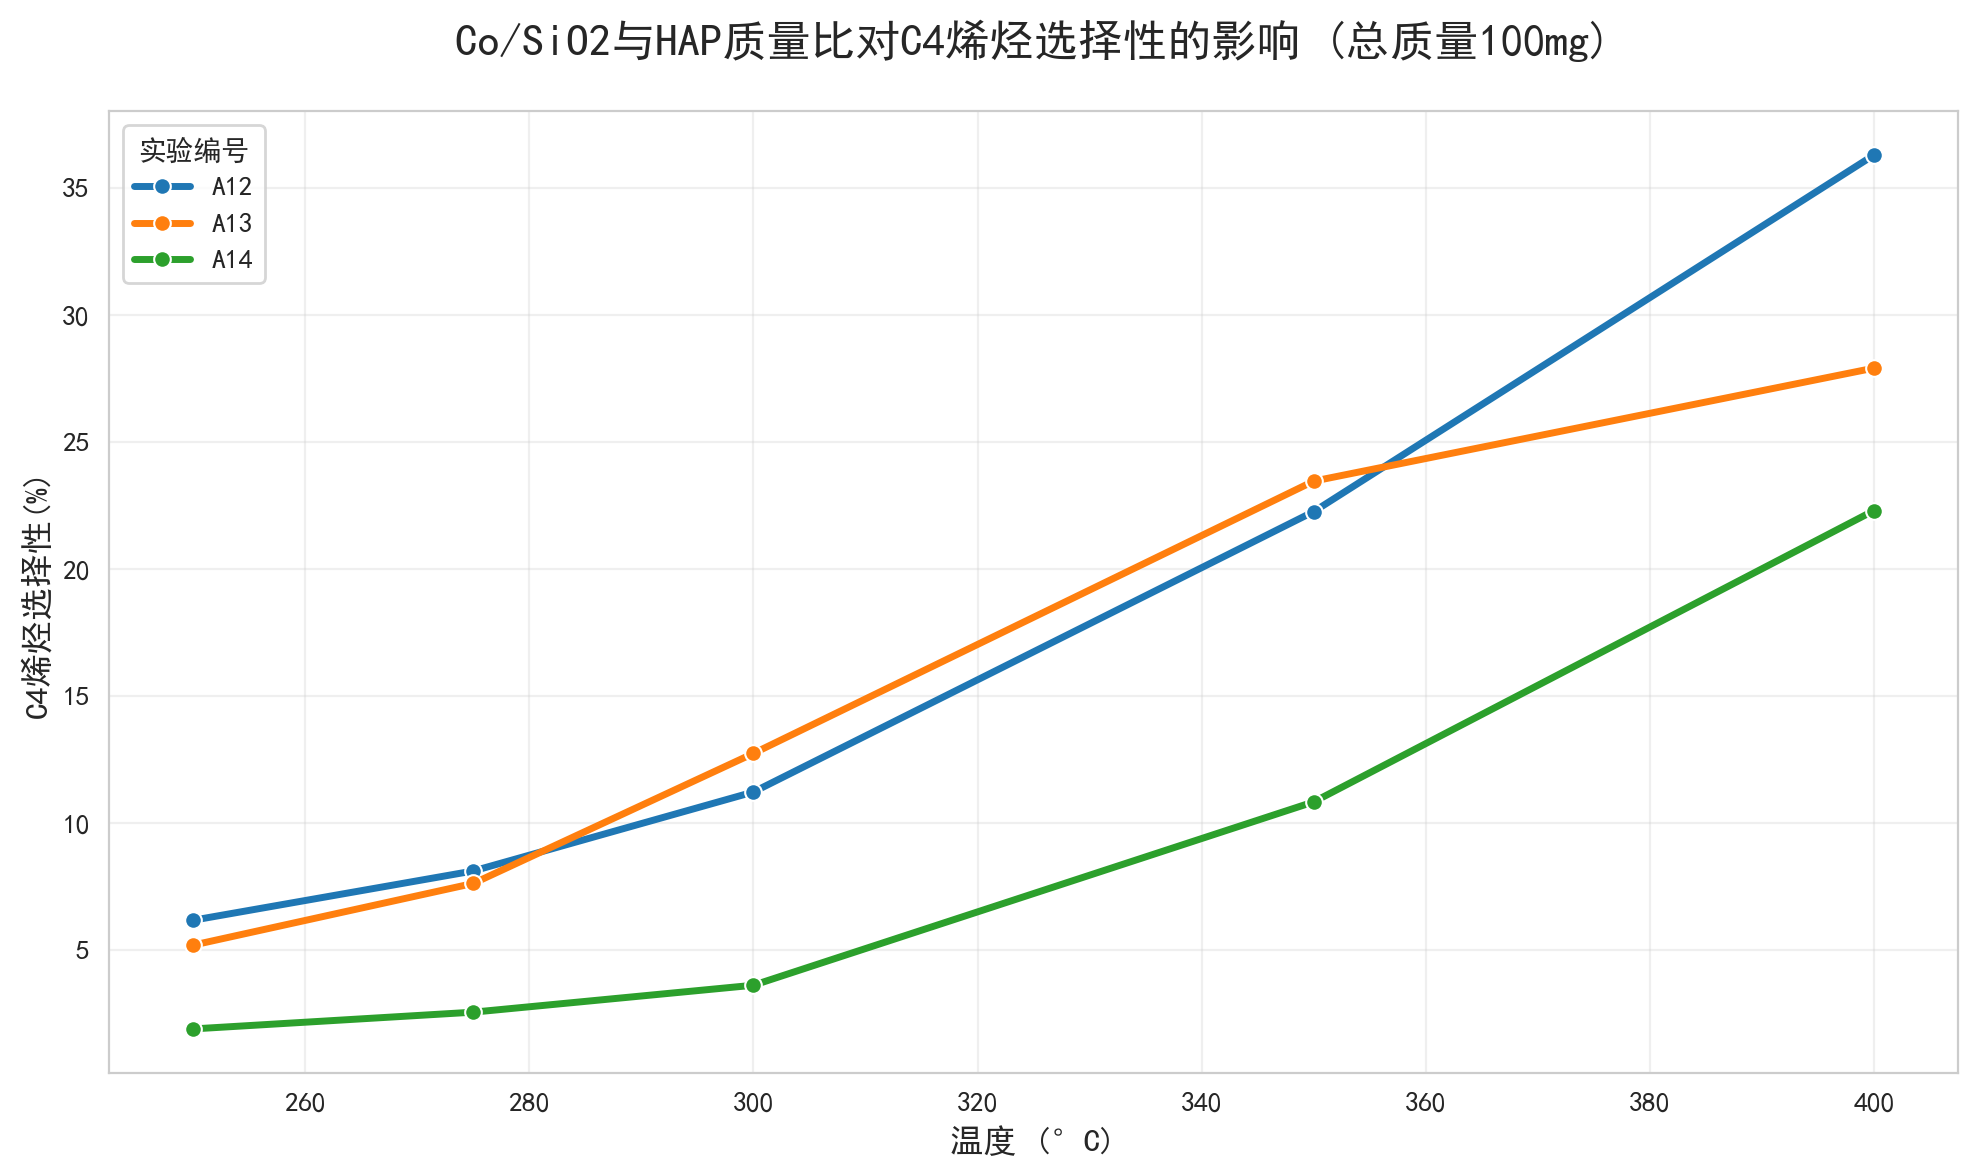

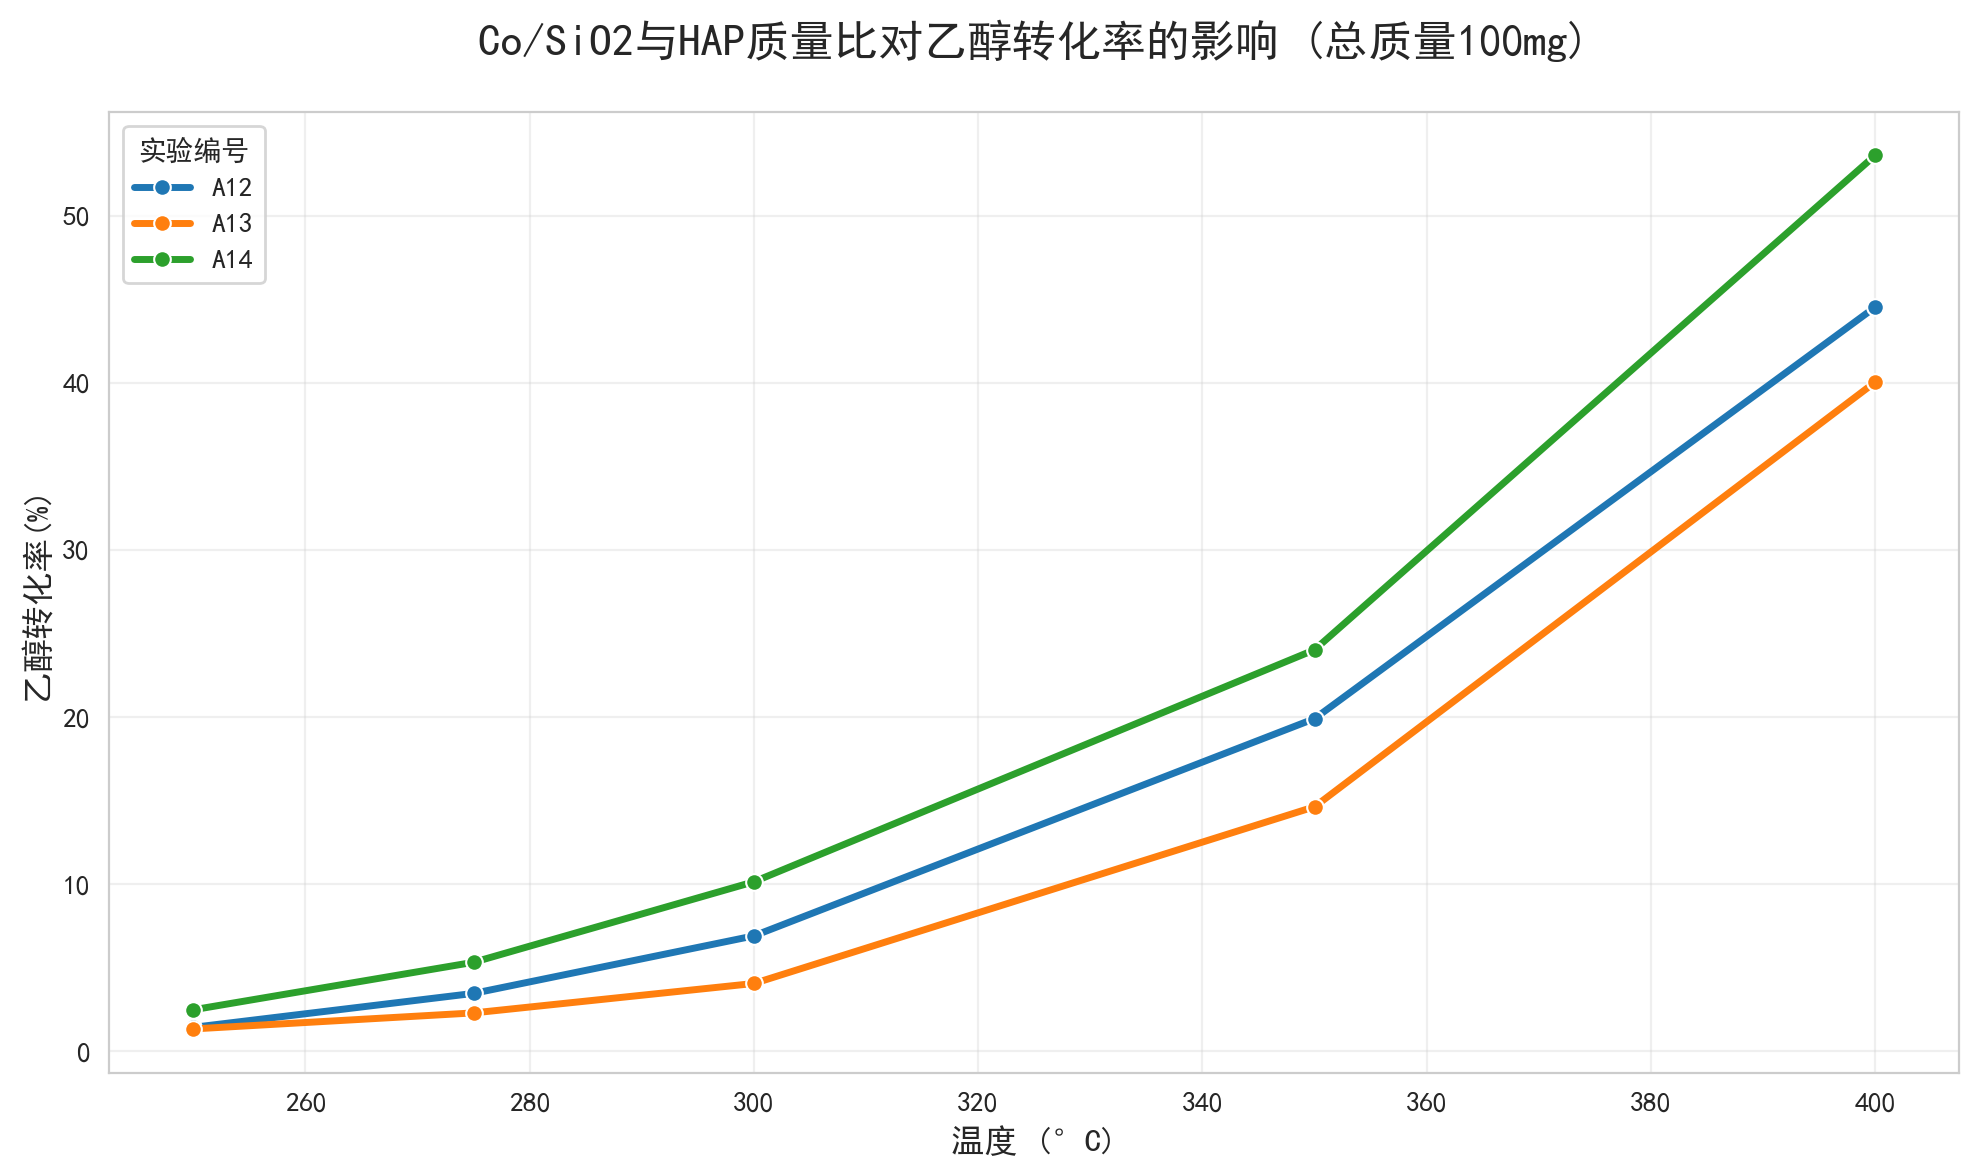


--- 质量比对照 (A12, A13, A14) 在 400°C ---
A12 (质量比 1.00): 转化率=44.53%，C4选择性=36.30%
A13 (质量比 2.03): 转化率=40.05%，C4选择性=27.91%
A14 (质量比 0.49): 转化率=53.62%，C4选择性=22.30%


In [15]:
# Co负载1wt%, 乙醇1.68ml/min, 方式I, 总质量100mg
group_5 = ['A12', 'A13', 'A14']  
plot_comparison(df_clean, group_5, 'Co/SiO2与HAP质量比对C4烯烃选择性的影响 (总质量100mg)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_5, 'Co/SiO2与HAP质量比对乙醇转化率的影响 (总质量100mg)', '乙醇转化率(%)')

print(f"\n--- 质量比对照 (A12, A13, A14) 在 400°C ---")
for id_ in group_5:
    data = df_clean[(df_clean['编号']==id_) & (df_clean['温度']==400)]
    ratio = data['质量比(Co/SiO2:HAP)'].values[0]
    selectivity = data['C4烯烃选择性(%)'].values[0]
    choices = data['乙醇转化率(%)'].values[0]
    print(f"{id_} (质量比 {ratio:.2f}): 转化率={choices:.2f}%，C4选择性={selectivity:.2f}%")

# 6. Co与HAP质量比1:1，总质量不同

### B1 vs B2 vs B3 vs B4 vs B6

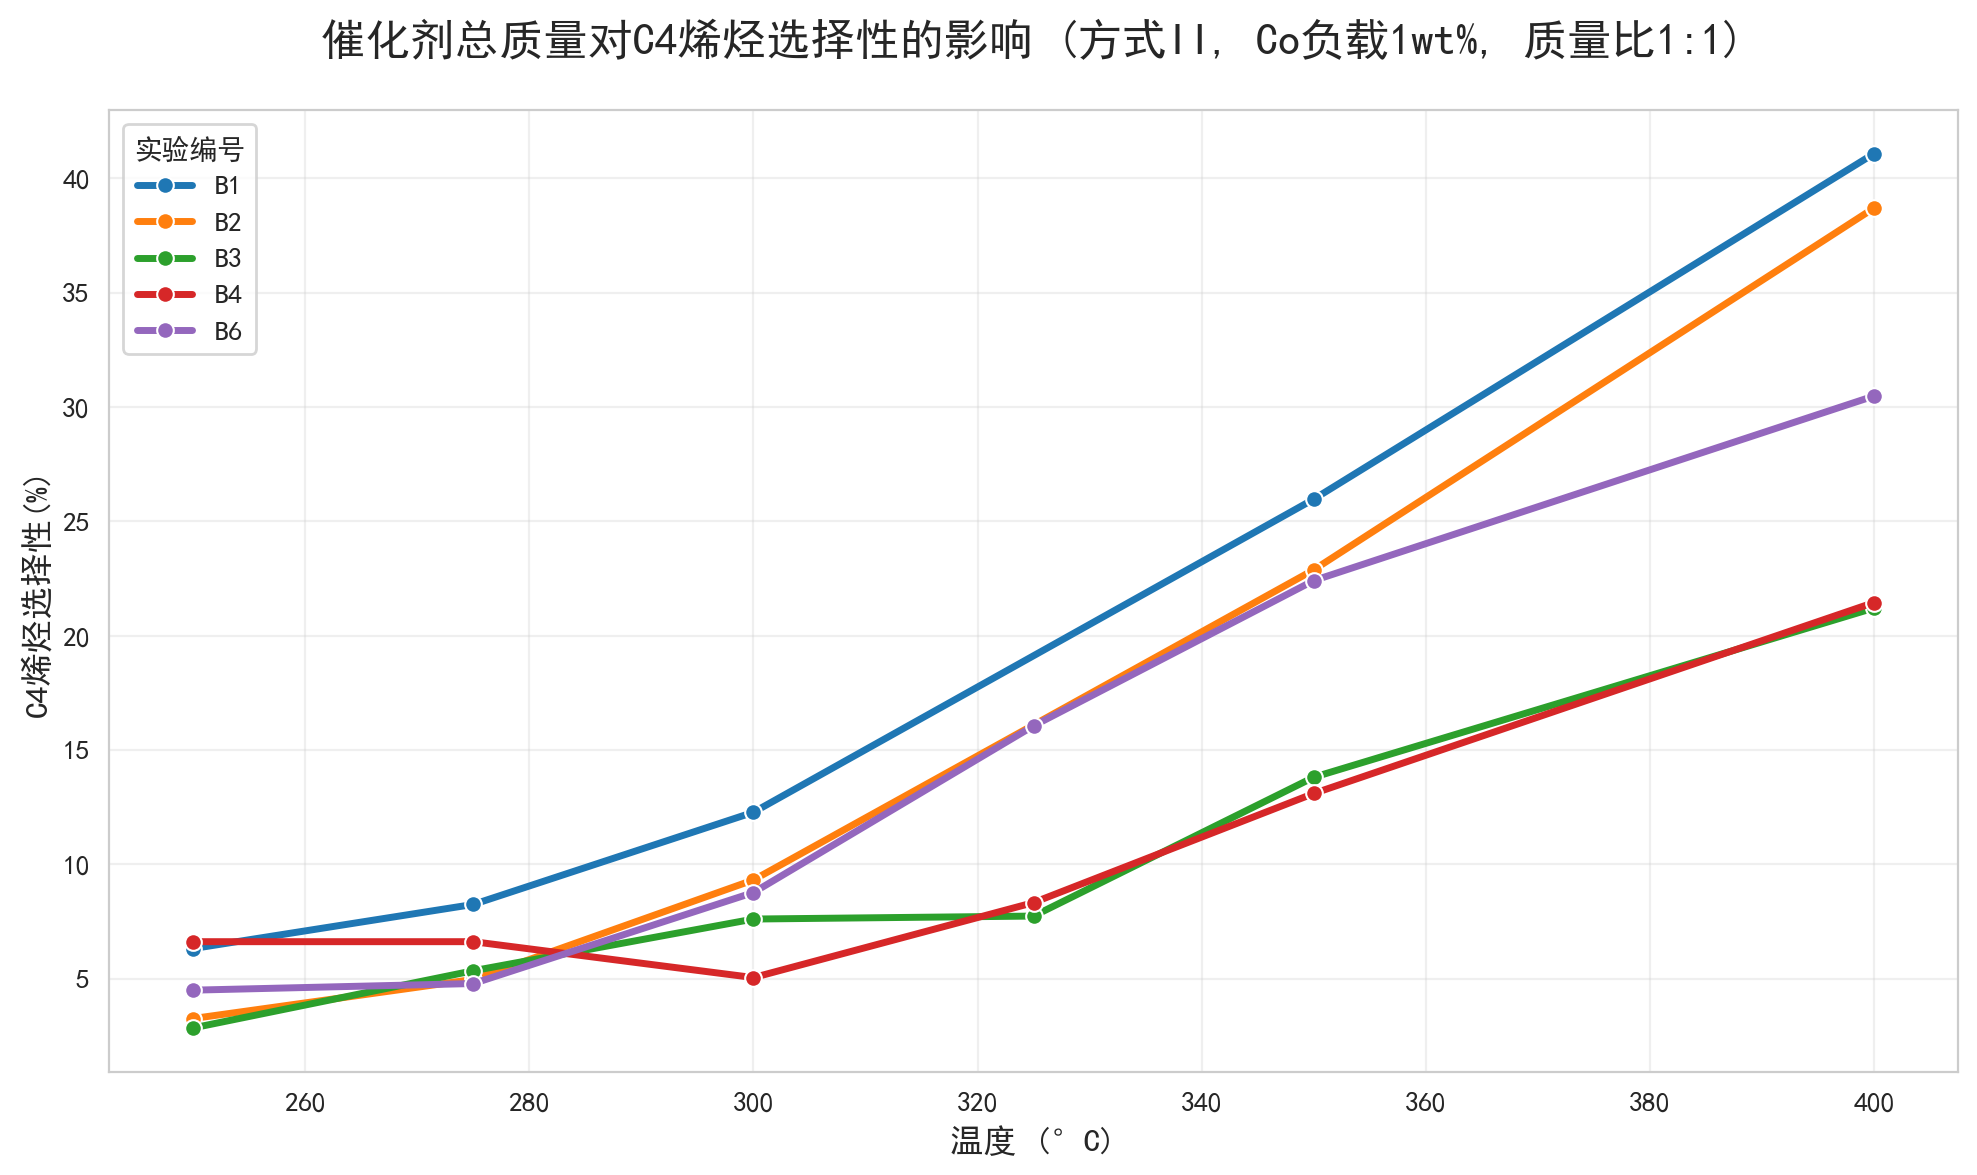

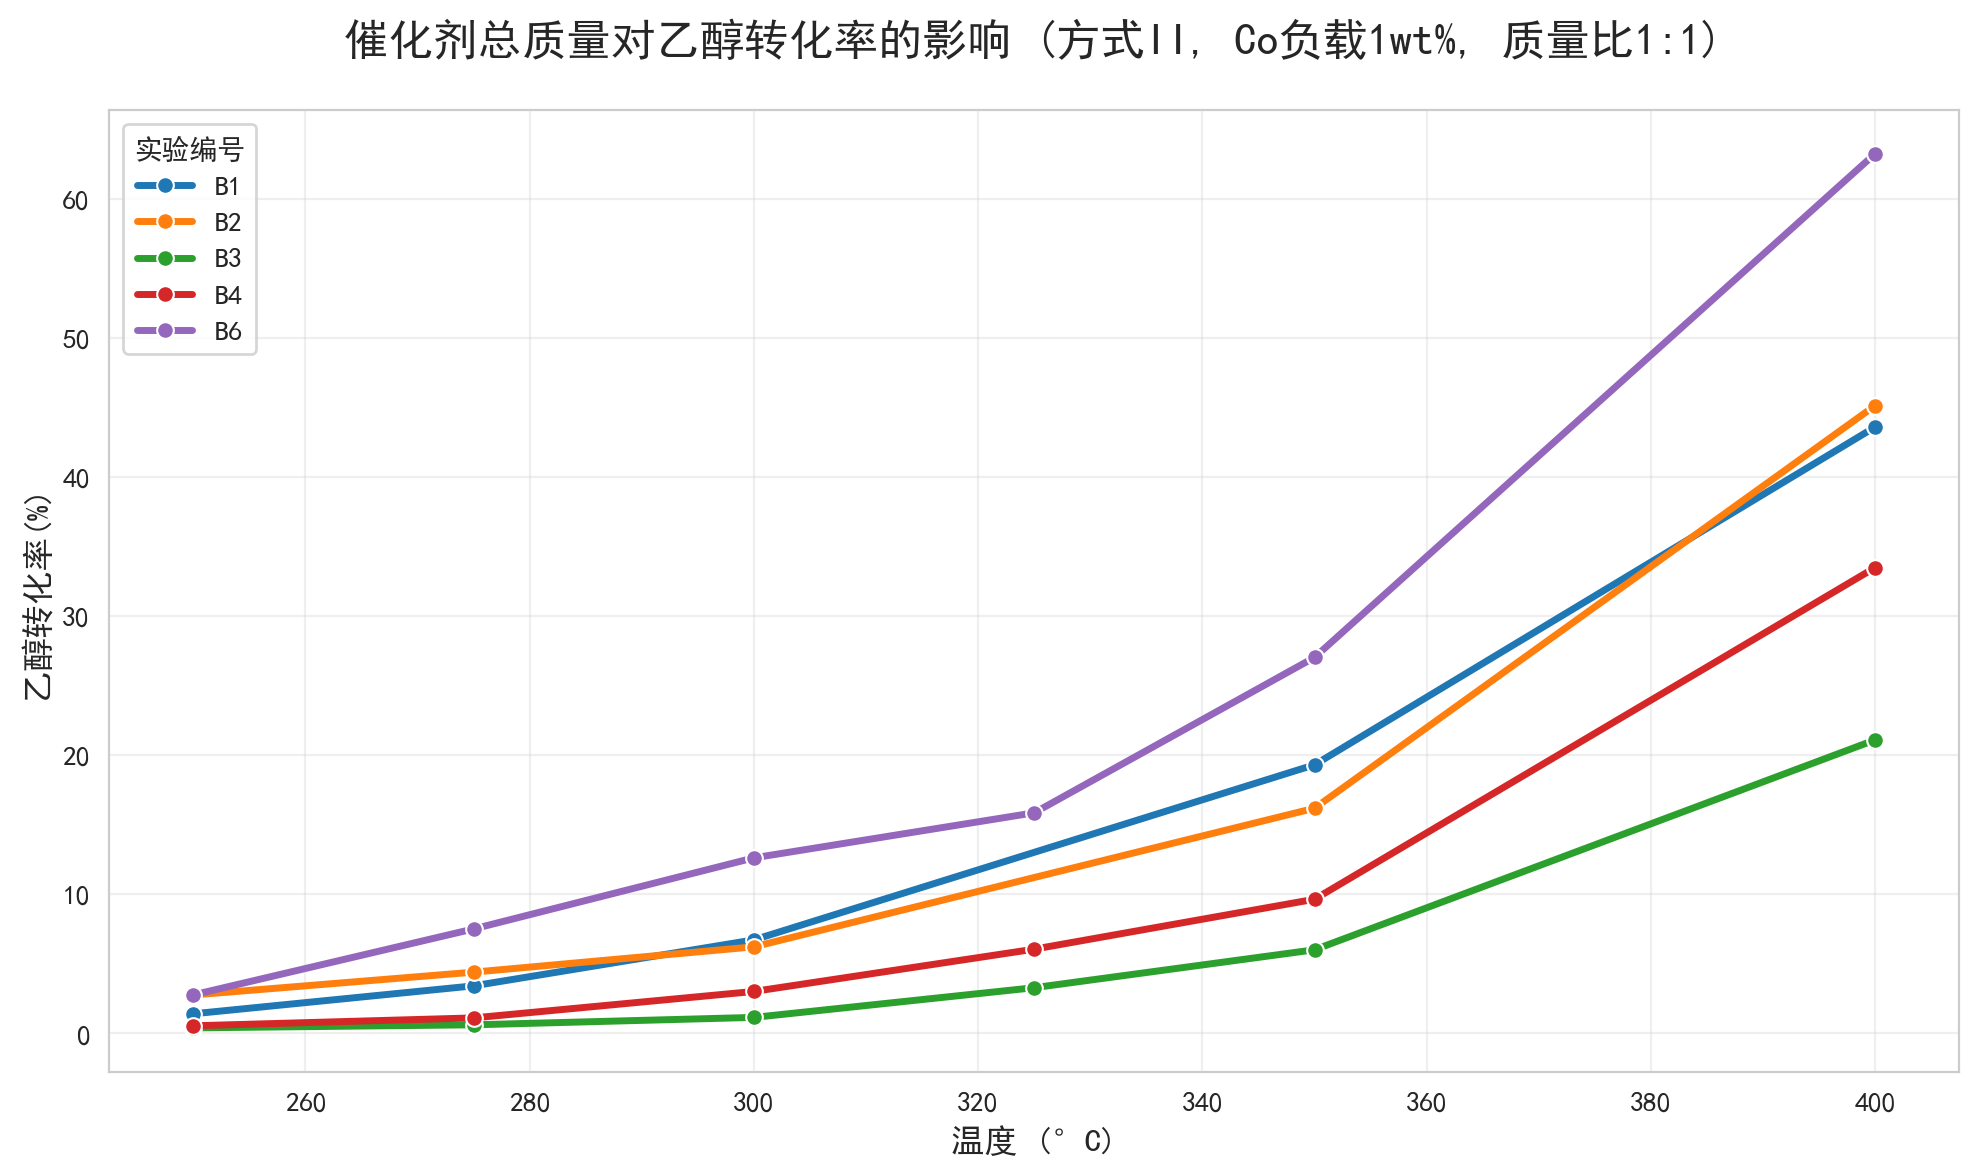


--- 总质量对照 (B组, 方式II) 在 400°C ---
B3 (20.0mg): 转化率=21.10%，C4选择性=21.21%
B4 (50.0mg): 转化率=33.49%，C4选择性=21.45%
B1 (100.0mg): 转化率=43.60%，C4选择性=41.08%
B6 (150.0mg): 转化率=63.25%，C4选择性=30.48%
B2 (200.0mg): 转化率=45.14%，C4选择性=38.70%


In [16]:
# 方式II, Co负载1wt%, 质量比1:1, 乙醇1.68ml/min
group_6b = ['B3', 'B4', 'B1', 'B6', 'B2']
plot_comparison(df_clean, group_6b, '催化剂总质量对C4烯烃选择性的影响 (方式II, Co负载1wt%, 质量比1:1)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_6b, '催化剂总质量对乙醇转化率的影响 (方式II, Co负载1wt%, 质量比1:1)', '乙醇转化率(%)')

print(f"\n--- 总质量对照 (B组, 方式II) 在 400°C ---")
for id_ in group_6b:
    data = df_clean[(df_clean['编号']==id_) & (df_clean['温度']==400)]
    total_mass = data['总质量(mg)'].values[0]
    selectivity = data['C4烯烃选择性(%)'].values[0]
    choices = data['乙醇转化率(%)'].values[0]
    print(f"{id_} ({total_mass}mg): 转化率={choices:.2f}%，C4选择性={selectivity:.2f}%")

### A1 vs A12

乙醇转化率(%)
转化率={b1_350['乙醇转化率(%)'].values[0]:.1f}%，

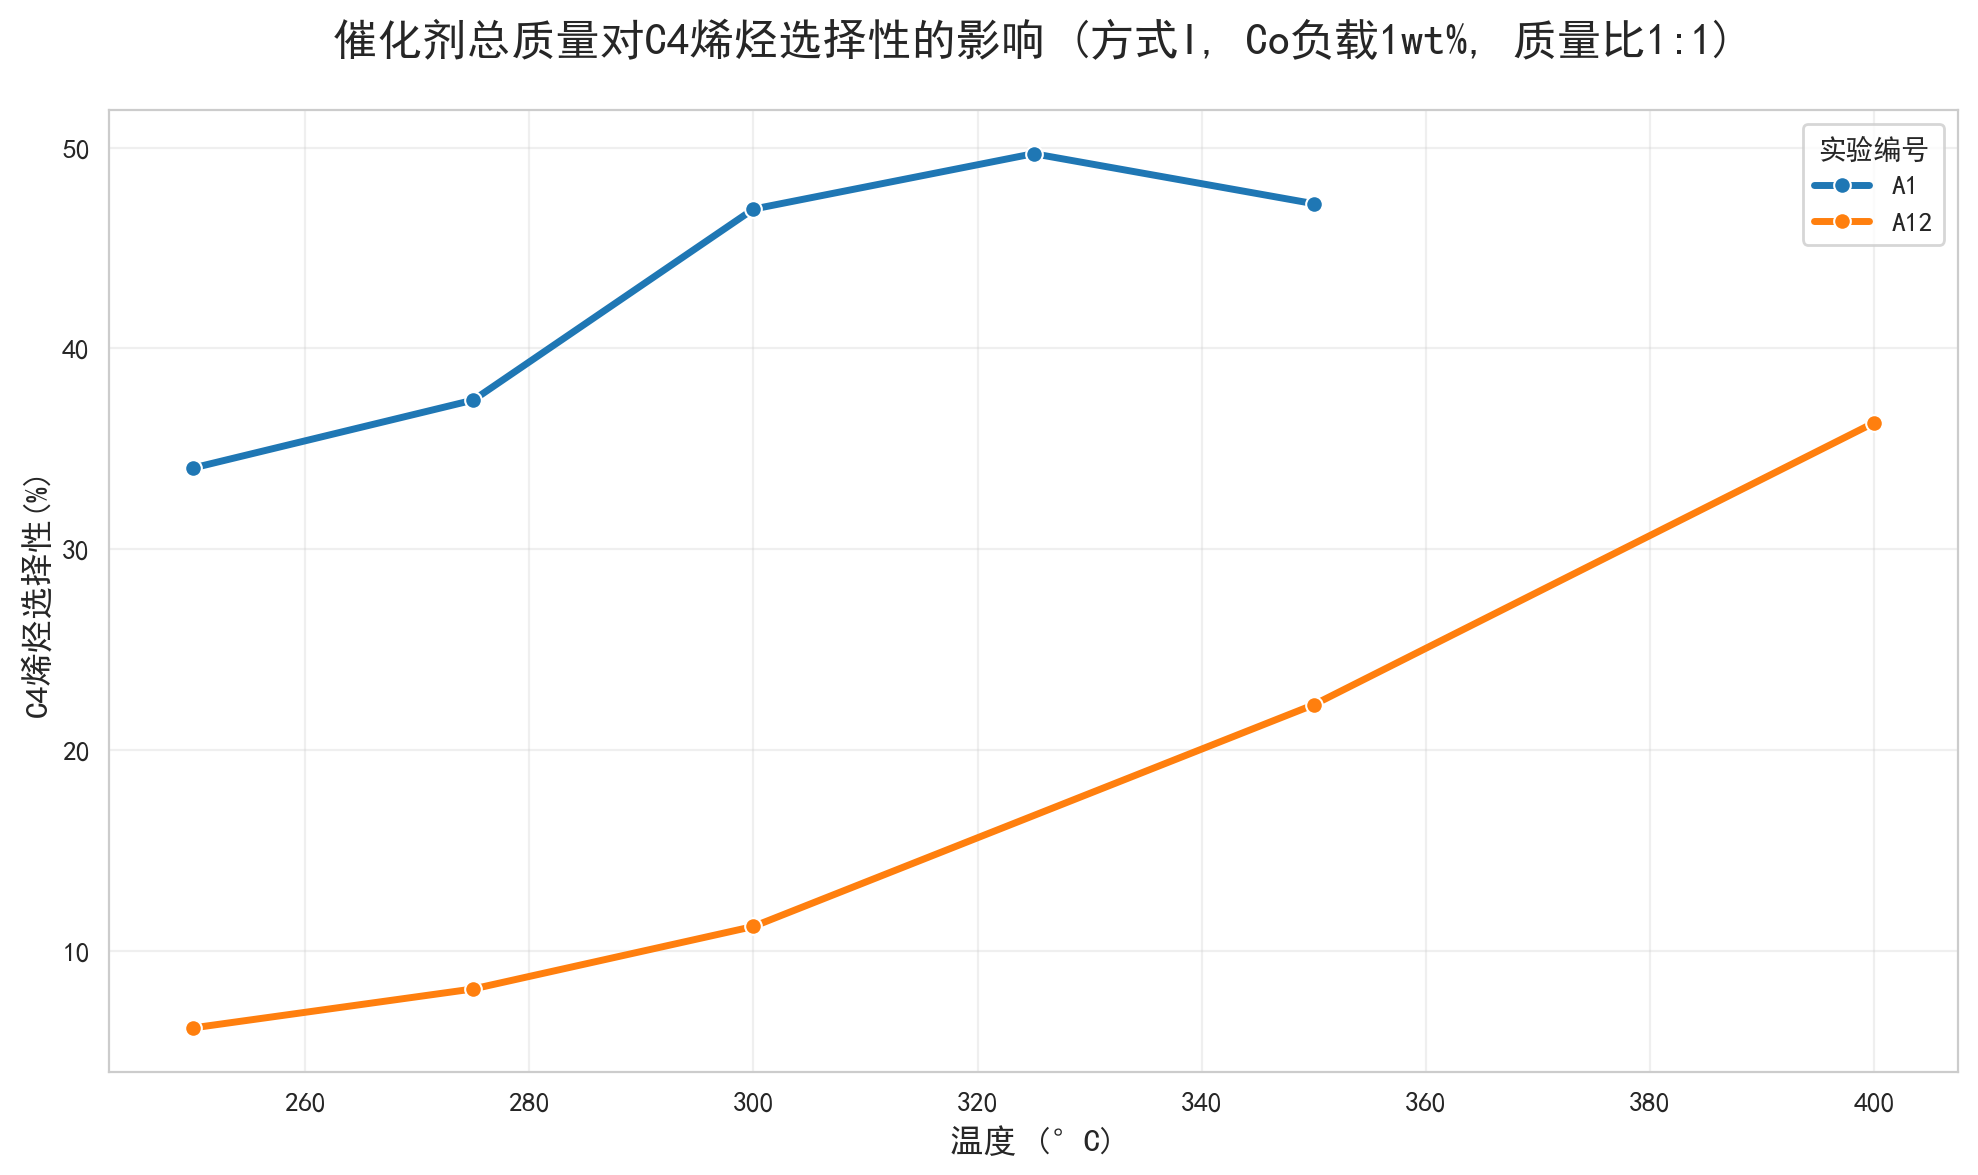

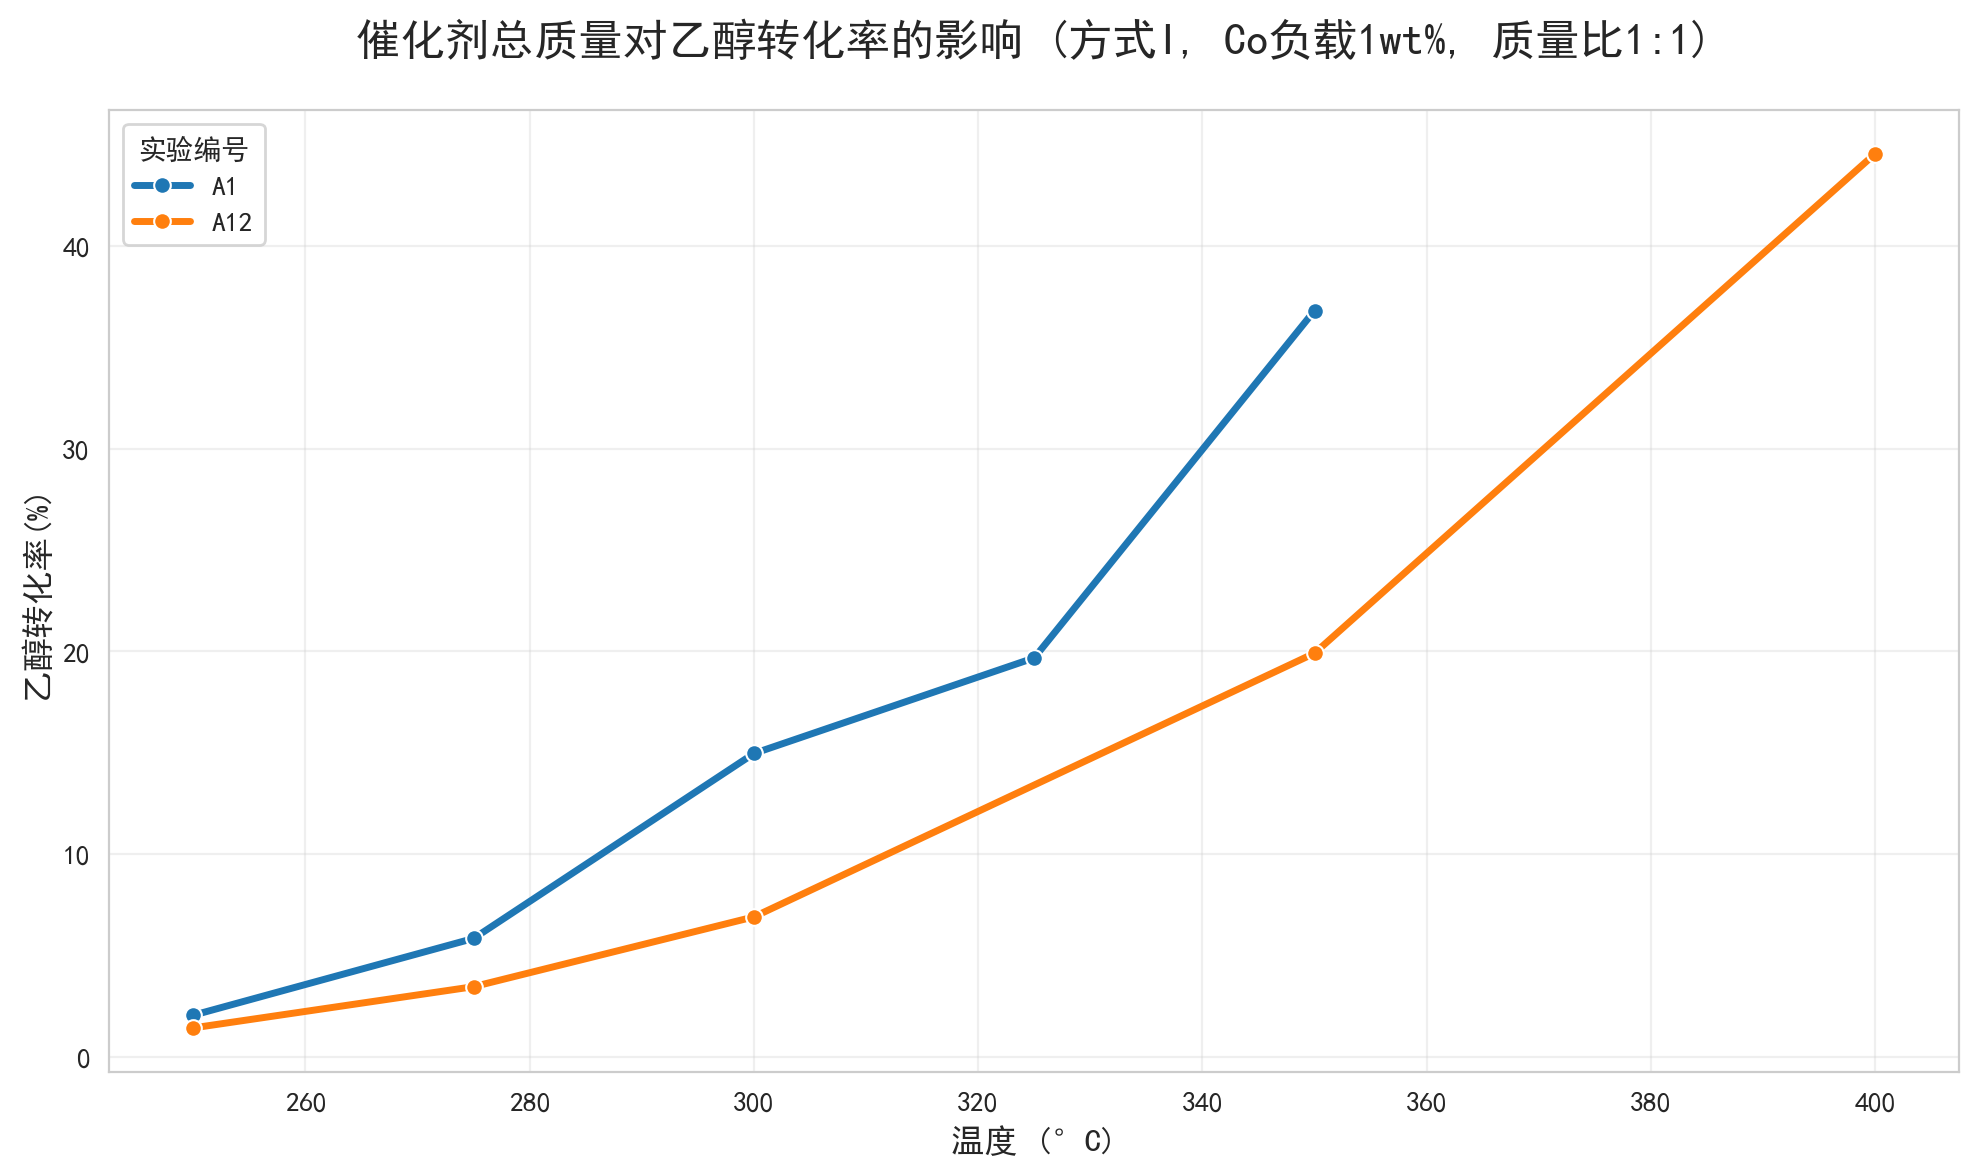

--- 总质量对照 (A组, 方式I) 在 350°C ---
A1 (400.0mg): 转化率=36.80%，C4选择性=47.21%
A12 (100.0mg): 转化率=19.91%，C4选择性=22.26%


In [17]:
# 方式I, Co负载1wt%, 质量比1:1, 乙醇1.68ml/min
group_6a = ['A1', 'A12']
plot_comparison(df_clean, group_6a, '催化剂总质量对C4烯烃选择性的影响 (方式I, Co负载1wt%, 质量比1:1)', 'C4烯烃选择性(%)')
plot_comparison(df_clean, group_6a, '催化剂总质量对乙醇转化率的影响 (方式I, Co负载1wt%, 质量比1:1)', '乙醇转化率(%)')

print(f"--- 总质量对照 (A组, 方式I) 在 350°C ---")
for id_ in group_6a:
    data = df_clean[(df_clean['编号']==id_) & (df_clean['温度']==350)]
    total_mass = data['总质量(mg)'].values[0]
    selectivity = data['C4烯烃选择性(%)'].values[0]
    choices = data['乙醇转化率(%)'].values[0]
    print(f"{id_} ({total_mass}mg): 转化率={choices:.2f}%，C4选择性={selectivity:.2f}%")

## 以上只能算是表面分析，我们从各个组合内看到不同的变化，现在要对不同催化剂组合内的东西进行回归拟合

In [18]:
df_clean.to_excel('回归拟合.xlsx')

## 搞个岭回归很妙，每个特征只有几条数据，数据量少容易过拟合，同时是高维数据，最终可解释性强，岭回归很合适

## 分别对乙醇转化率和选择性做两个回归

In [19]:
# 定义特征和目标
features = [
    'Co负载量(wt%)',
    'Co/SiO2质量(mg)',
    'HAP质量(mg)',
    '乙醇浓度(ml/min)',
    '温度'
]

X = df_clean[features]
y_conversion = df_clean['乙醇转化率(%)']      # 因变量1
y_selectivity = df_clean['C4烯烃选择性(%)']    # 因变量2

In [20]:
# ================== 3. 构建岭回归管道（标准化 + Ridge）==================
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 参数搜索：自动选最优 alpha
param_grid = {'ridge__alpha': np.logspace(-3, 3, 50)}

In [21]:
# ================== 4. 模型1：乙醇转化率 ==================
grid_conv = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_conv.fit(X, y_conversion)

best_alpha_conv = grid_conv.best_params_['ridge__alpha']
coef_conv = grid_conv.best_estimator_['ridge'].coef_
intercept_conv = grid_conv.best_estimator_['ridge'].intercept_

print("========== 模型1：乙醇转化率 岭回归结果 ==========")
print(f"最优 alpha: {best_alpha_conv:.4f}")
print(f"截距: {intercept_conv:.4f}")
print("标准化回归系数:")
for feat, coef in zip(features, coef_conv):
    print(f"  {feat}: {coef:.4f}")

========== 模型1：乙醇转化率 岭回归结果 ==========
最优 alpha: 8.2864
截距: 21.9892
标准化回归系数:
  Co负载量(wt%): 0.1697
  Co/SiO2质量(mg): 2.4395
  HAP质量(mg): 5.1538
  乙醇浓度(ml/min): -4.3307
  温度: 16.1869


In [22]:
# ================== 5. 模型2：C4烯烃选择性 ==================
grid_sel = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_sel.fit(X, y_selectivity)

best_alpha_sel = grid_sel.best_params_['ridge__alpha']
coef_sel = grid_sel.best_estimator_['ridge'].coef_
intercept_sel = grid_sel.best_estimator_['ridge'].intercept_

print("========== 模型2：C4烯烃选择性 岭回归结果 ==========")
print(f"最优 alpha: {best_alpha_sel:.4f}")
print(f"截距: {intercept_sel:.4f}")
print("标准化回归系数:")
for feat, coef in zip(features, coef_sel):
    print(f"  {feat}: {coef:.4f}")
print("\n")

========== 模型2：C4烯烃选择性 岭回归结果 ==========
最优 alpha: 4.7149
截距: 16.4508
标准化回归系数:
  Co负载量(wt%): -3.4383
  Co/SiO2质量(mg): 2.1327
  HAP质量(mg): 4.0744
  乙醇浓度(ml/min): 1.2088
  温度: 9.0609




In [23]:
# ================== 6. 系数对比（可选）==================
coef_df = pd.DataFrame({
    '特征': features,
    '乙醇转化率系数': coef_conv,
    'C4选择性系数': coef_sel
})
print("========== 两个模型系数对比 ==========")
print(coef_df.round(4))
print('\n')
print("系数正负表示影响方向，绝对值表示影响大小")

========== 两个模型系数对比 ==========
              特征  乙醇转化率系数  C4选择性系数
0     Co负载量(wt%)   0.1697  -3.4383
1  Co/SiO2质量(mg)   2.4395   2.1327
2      HAP质量(mg)   5.1538   4.0744
3   乙醇浓度(ml/min)  -4.3307   1.2088
4             温度  16.1869   9.0609


系数正负表示影响方向，绝对值表示影响大小


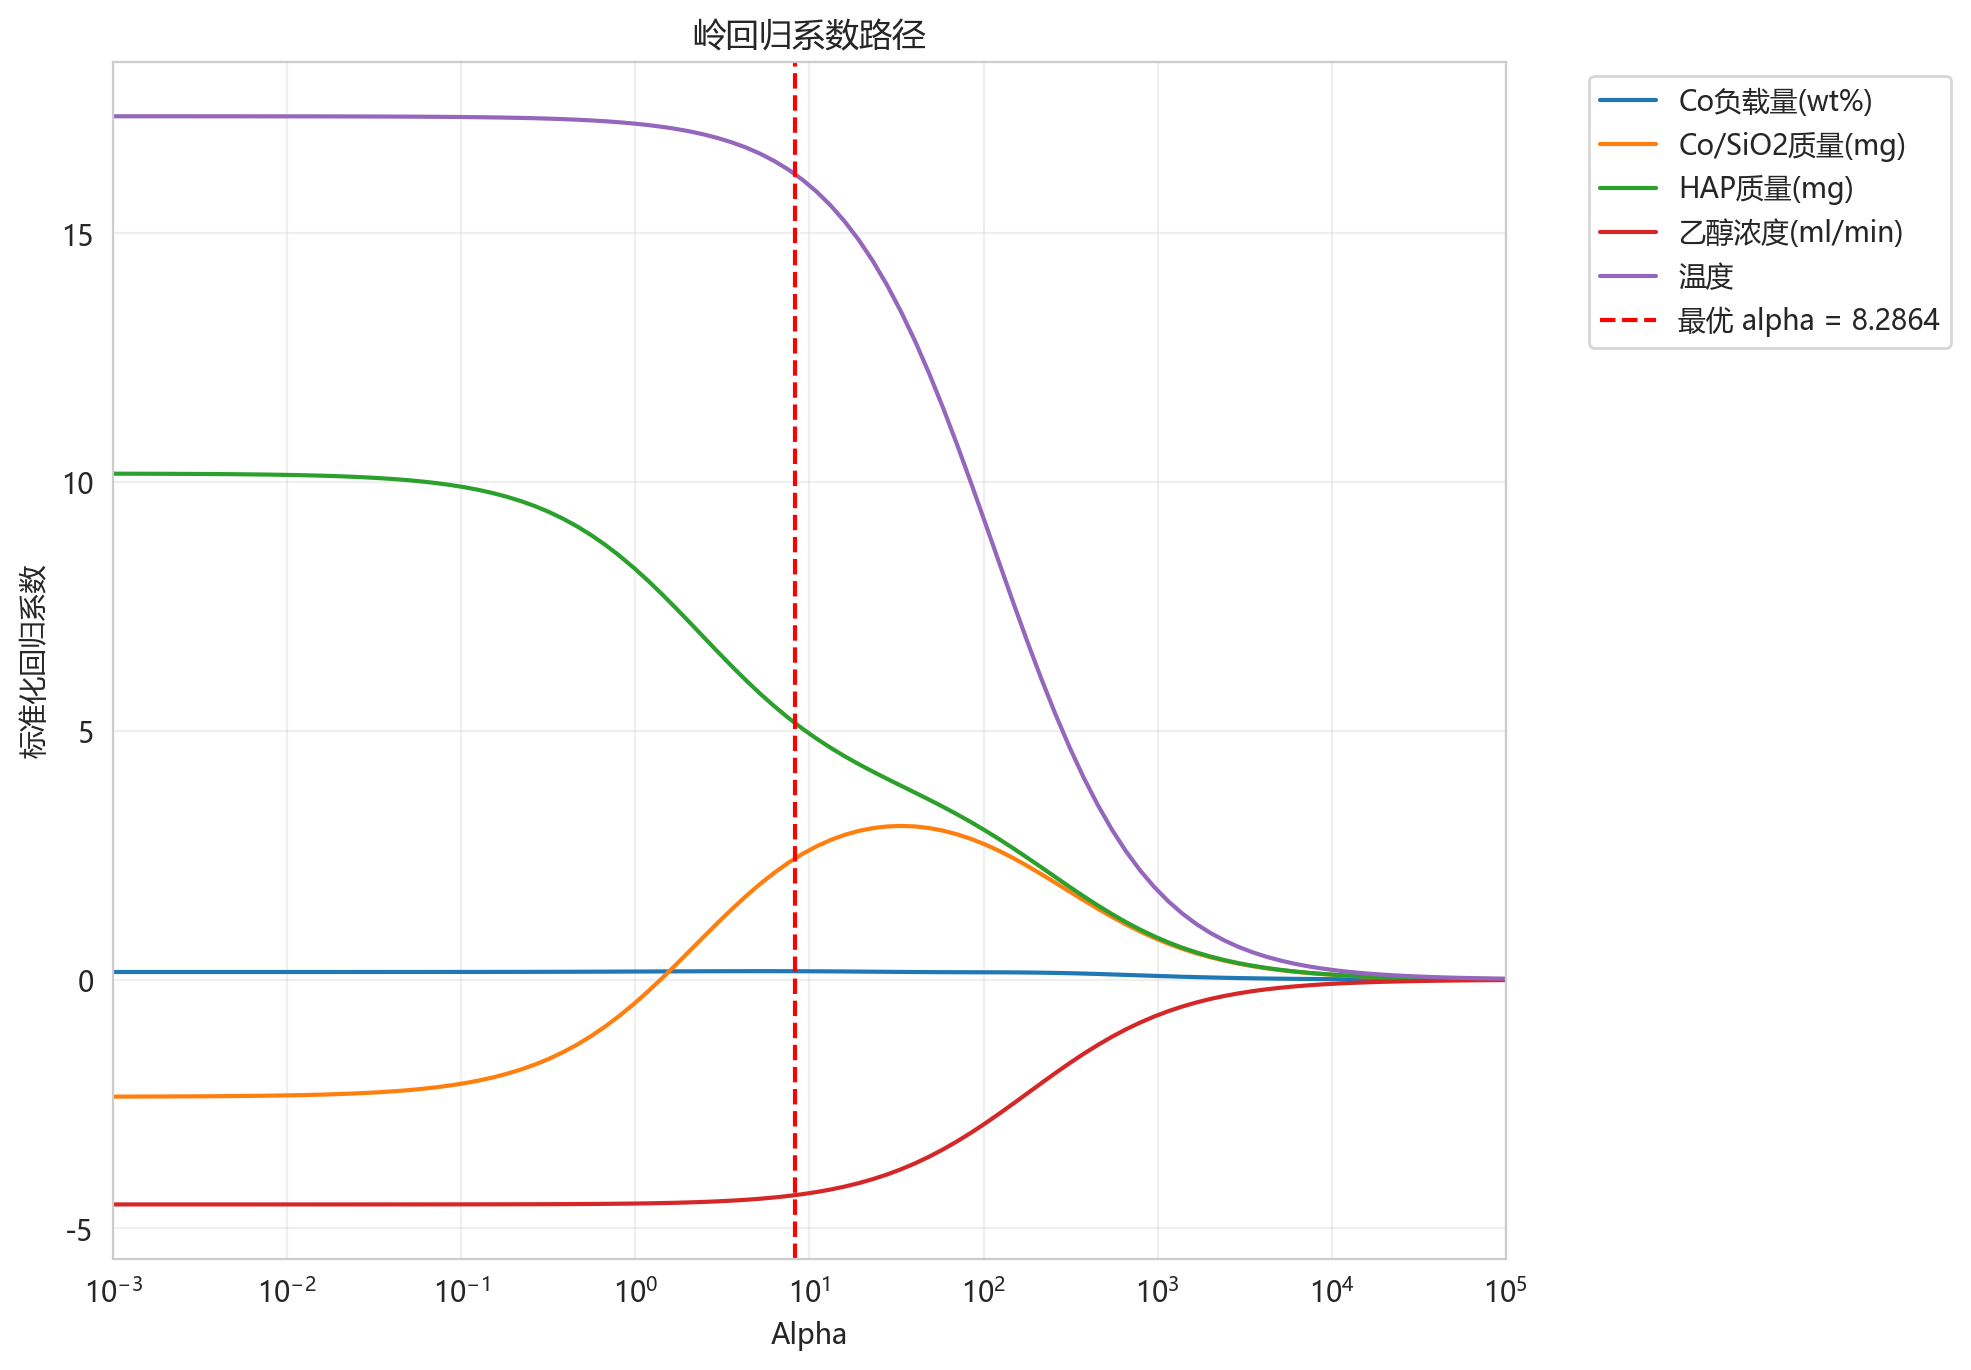

In [27]:
# 处理中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 坐标轴负号的处理
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 手动在多个 alpha 上拟合，获取系数路径
alphas_ = np.logspace(-3, 5, 100)
coefs = []

for a in alphas_:
    ridge = Ridge(alpha=a)
    pipeline_temp = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', ridge)
    ])
    pipeline_temp.fit(X, y_conversion)
    coefs.append(pipeline_temp['ridge'].coef_)

# 绘图
plt.figure(figsize=(10, 7))
coefs = np.array(coefs)
for i, feat in enumerate(features):
    plt.plot(alphas_, coefs[:, i], label=feat)

plt.axvline(best_alpha_conv, color='red', linestyle='--', label=f'最优 alpha = {best_alpha_conv:.4f}')
plt.xscale('log')
plt.xlim(1e-3, 1e5)
plt.xlabel('Alpha')
plt.ylabel('标准化回归系数')
plt.title('岭回归系数路径')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

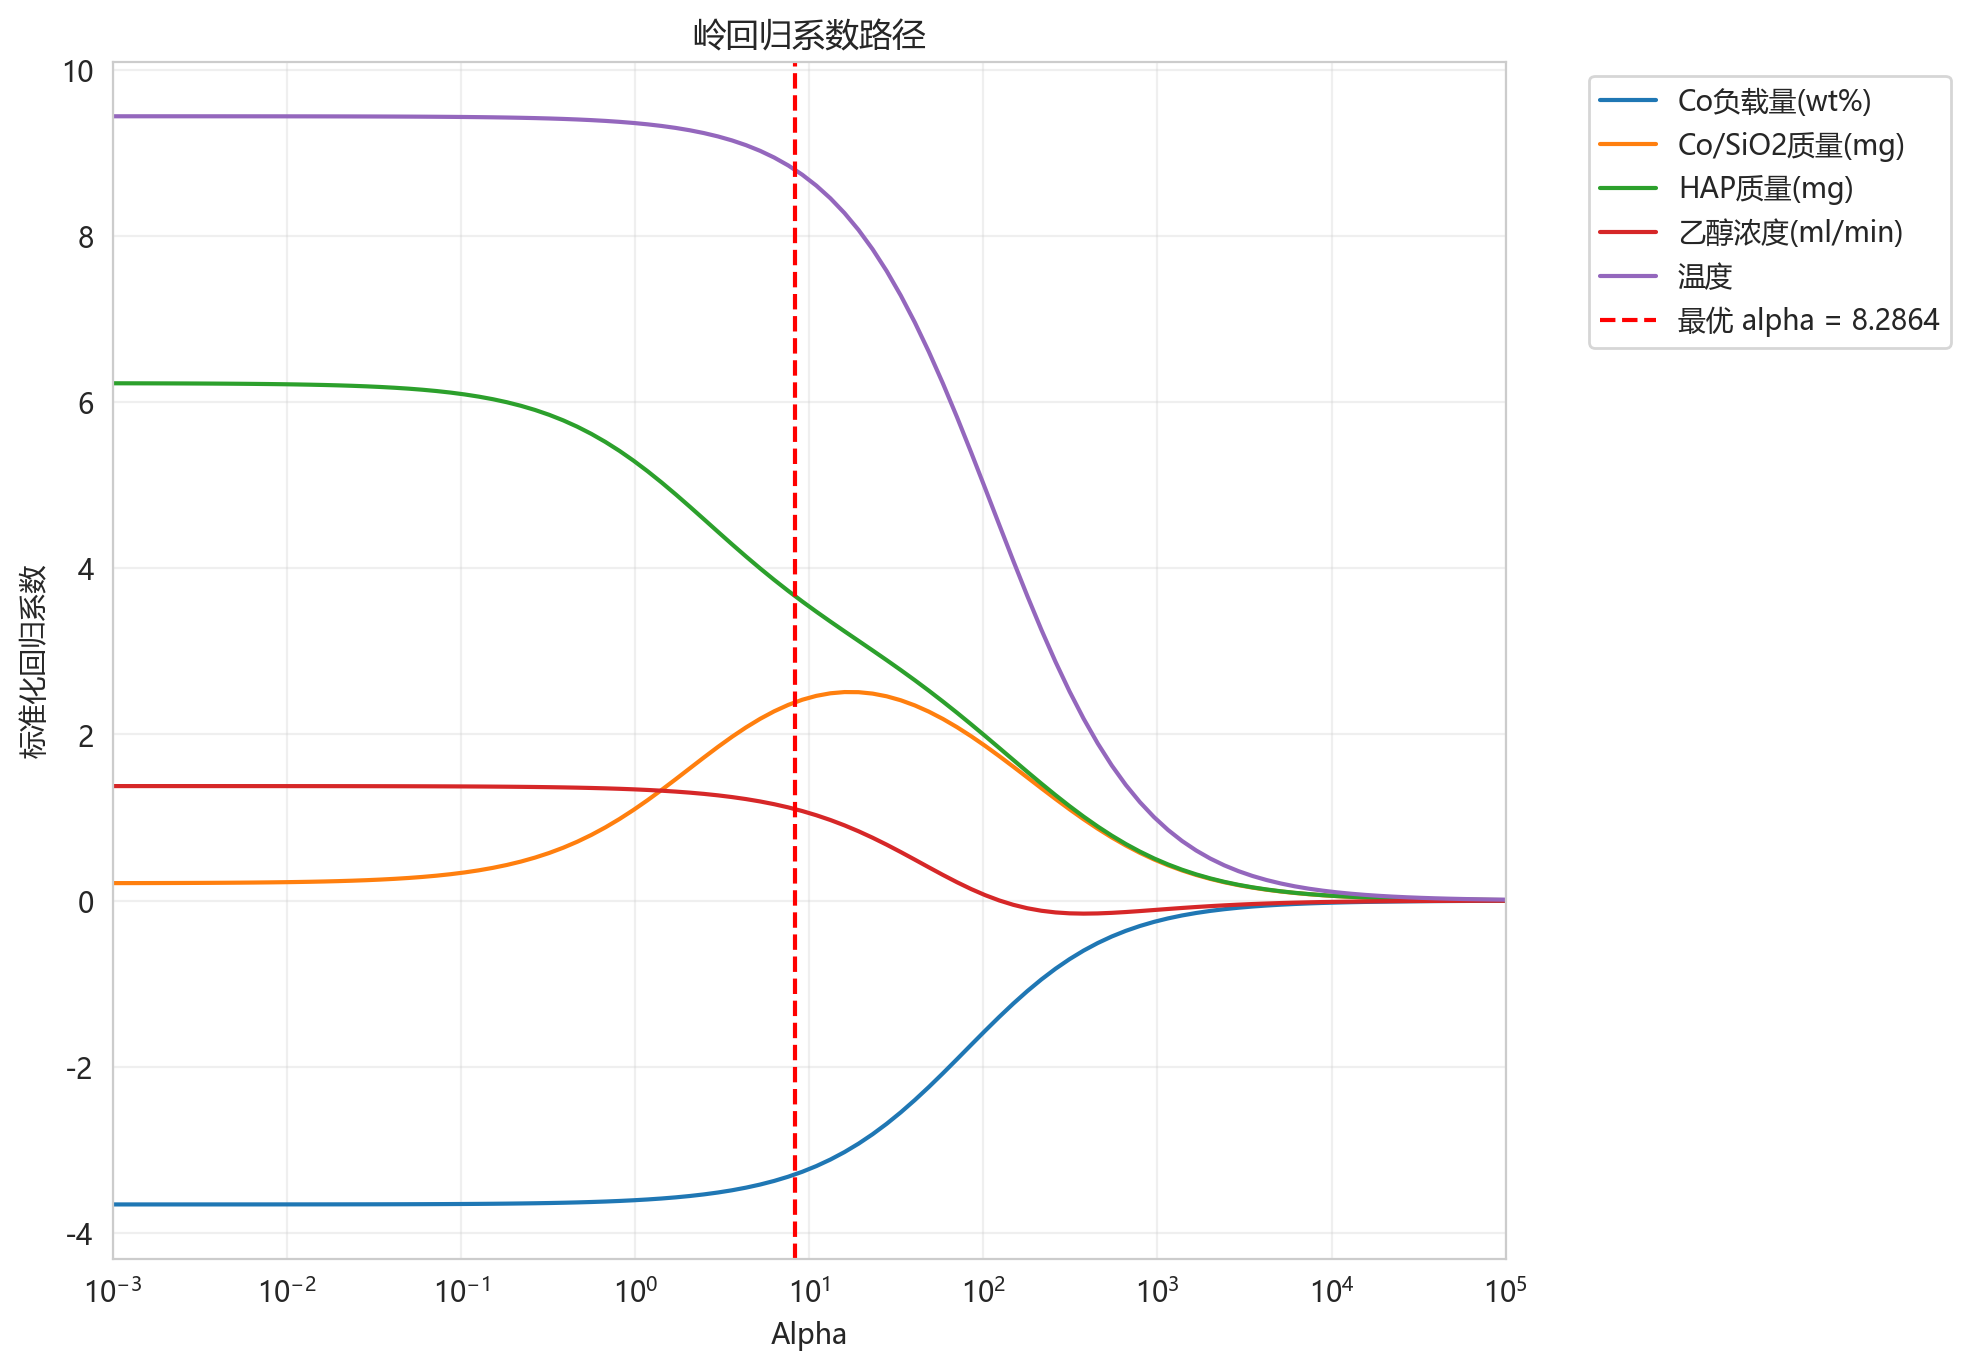

In [28]:
# 手动在多个 alpha 上拟合，获取系数路径
alphas_ = np.logspace(-3, 5, 100)
coefs_1 = []

for a in alphas_:
    ridge = Ridge(alpha=a)
    pipeline_temp_temp = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', ridge)
    ])
    pipeline_temp_temp.fit(X, y_selectivity)
    coefs_1.append(pipeline_temp_temp['ridge'].coef_)

# 绘图
plt.figure(figsize=(10, 7))
coefs_1 = np.array(coefs_1)
for i, feat in enumerate(features):
    plt.plot(alphas_, coefs_1[:, i], label=feat)

plt.axvline(best_alpha_conv, color='red', linestyle='--', label=f'最优 alpha = {best_alpha_conv:.4f}')
plt.xscale('log')
plt.xlim(1e-3, 1e5)
plt.xlabel('Alpha')
plt.ylabel('标准化回归系数')
plt.title('岭回归系数路径')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()